<a href="https://www.kaggle.com/code/mohammadbilal88766/baseline-model-1?scriptVersionId=233165702" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Text Model

Using device: cuda
MELD Emotion Recognition - Text Only (BERT)
Initializing BERT tokenizer...

Creating datasets...
Loaded 9988 samples from /kaggle/input/meld-preprocessed/preprocessed_data/train
Loaded 1108 samples from /kaggle/input/meld-preprocessed/preprocessed_data/dev
Loaded 2610 samples from /kaggle/input/meld-preprocessed/preprocessed_data/test

Creating DataLoaders with batch size 32...

Initializing BERT model...

Training for 1 epochs...


Epoch 1/1 [Val]: 100%|██████████| 35/35 [00:09<00:00,  3.58it/s]


Epoch 1/1:
  Train Loss: 1.2360, Train Accuracy: 0.5922
  Val Loss: 1.1878, Val Accuracy: 0.5975


Testing: 100%|██████████| 82/82 [00:21<00:00,  3.80it/s]



Test Accuracy: 0.6215

Classification Report:
              precision    recall  f1-score   support

     neutral       0.78      0.77      0.77      1256
    surprise       0.42      0.75      0.54       281
        fear       0.00      0.00      0.00        50
     sadness       0.50      0.19      0.28       208
         joy       0.63      0.51      0.56       402
     disgust       0.00      0.00      0.00        68
       anger       0.43      0.57      0.49       345

    accuracy                           0.62      2610
   macro avg       0.39      0.40      0.38      2610
weighted avg       0.61      0.62      0.60      2610


Creating plots...


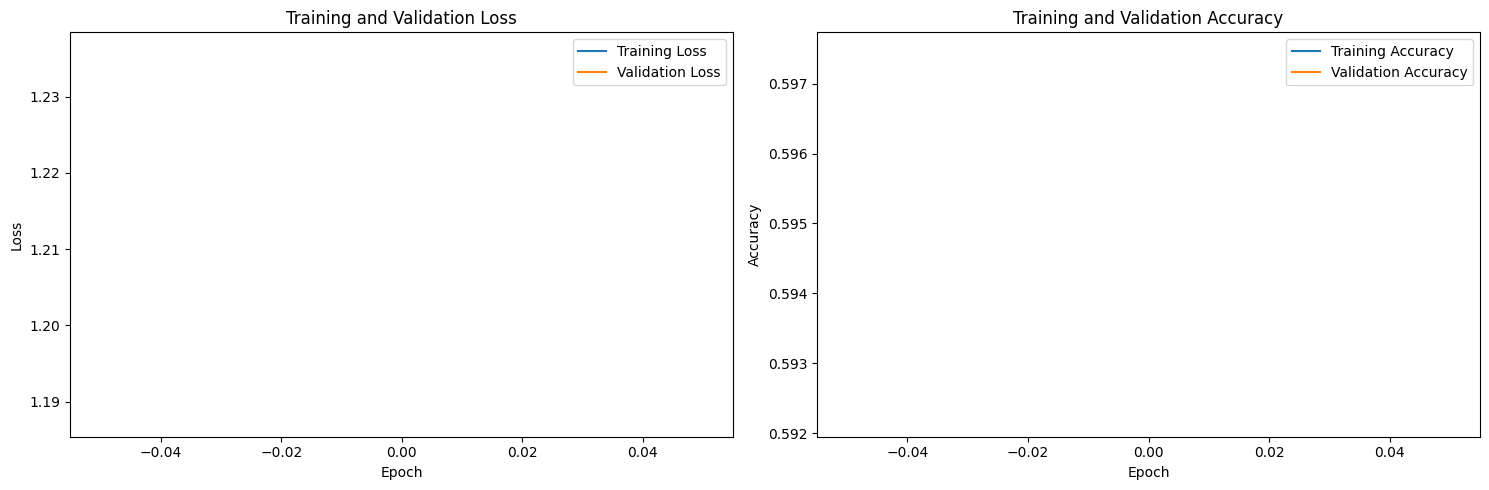

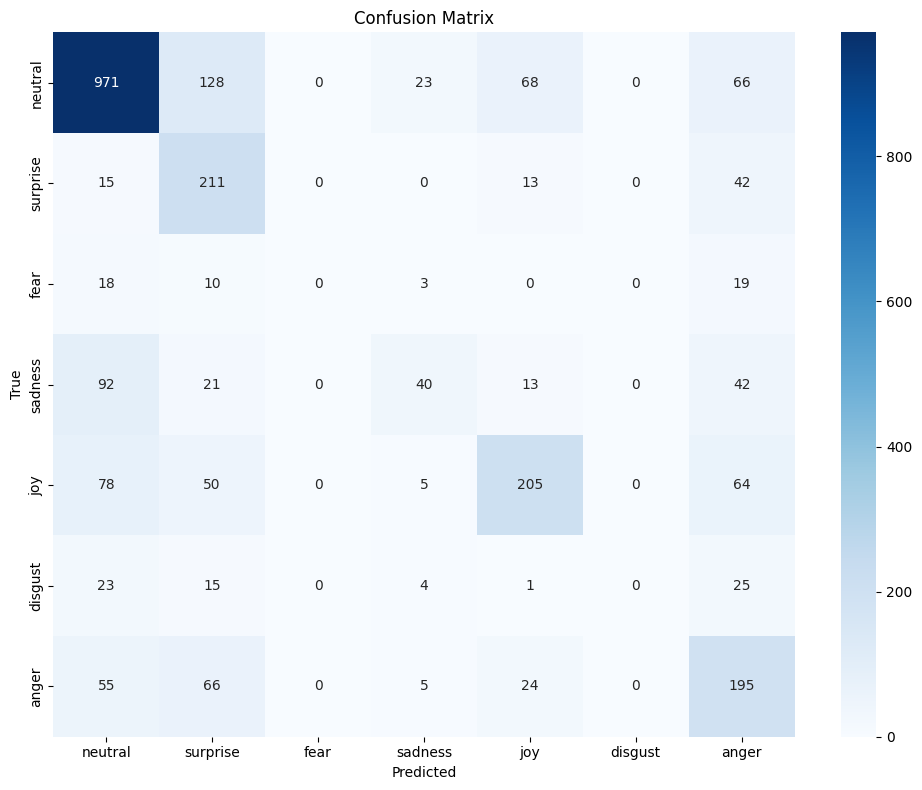

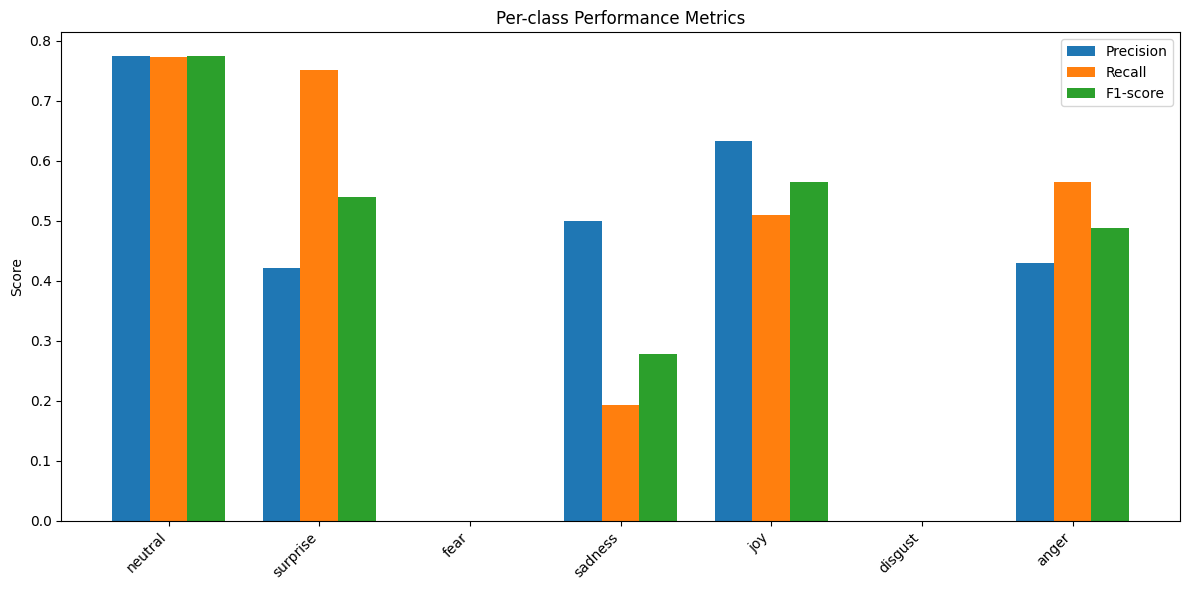


Saving model...
Model saved as 'meld_bert_emotion_model.pt'


In [31]:
import os
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Check if CUDA is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Data paths - these are the correct paths based on your Kaggle structure
DATA_PATHS = {
    'train': '/kaggle/input/meld-preprocessed/preprocessed_data/train',
    'dev': '/kaggle/input/meld-preprocessed/preprocessed_data/dev',
    'test': '/kaggle/input/meld-preprocessed/preprocessed_data/test'
}

# Custom Dataset for MELD
class MELDTextDataset(Dataset):
    def __init__(self, data_dir, tokenizer, max_len=128):
        """
        Args:
            data_dir: Directory containing preprocessed .pt files
            tokenizer: BERT tokenizer
            max_len: Maximum sequence length for BERT
        """
        self.data_dir = data_dir
        self.tokenizer = tokenizer
        self.max_len = max_len
        self.files = [os.path.join(data_dir, f) for f in os.listdir(data_dir) if f.endswith('.pt')]
        
        # Define emotion to index mapping
        self.emotion_to_idx = {
            'neutral': 0,
            'surprise': 1,
            'fear': 2,
            'sadness': 3,
            'joy': 4,
            'disgust': 5,
            'anger': 6
        }
        
        # Define index to emotion mapping for later use
        self.idx_to_emotion = {v: k for k, v in self.emotion_to_idx.items()}
        
        print(f"Loaded {len(self.files)} samples from {data_dir}")
        
    def __len__(self):
        return len(self.files)
    
    def __getitem__(self, idx):
        # Load sample from file
        sample_path = self.files[idx]
        sample = torch.load(sample_path)
        
        # Extract text and emotion
        text = sample['utterance']
        
        # Handle different emotion formats (string or integer)
        if isinstance(sample['emotion'], str):
            emotion_idx = self.emotion_to_idx.get(sample['emotion'].lower(), 0)
        else:
            emotion_idx = sample['emotion']
            
        # Tokenize text for BERT
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )
        
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'emotion': torch.tensor(emotion_idx, dtype=torch.long)
        }

# Train the model
def train_and_evaluate(model, train_loader, val_loader, test_loader, num_epochs=5, learning_rate=2e-5):
    # Initialize optimizer
    optimizer = AdamW(model.parameters(), lr=learning_rate)
    
    # To track metrics
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []
    
    # Training loop
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_loss = 0
        train_correct = 0
        train_total = 0
        
        progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Train]")
        for batch in progress_bar:
            # Reset gradients
            optimizer.zero_grad()
            
            # Move batch to device
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            emotions = batch['emotion'].to(device)
            
            # Forward pass
            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=emotions)
            loss = outputs.loss
            
            # Update metrics
            predictions = torch.argmax(outputs.logits, dim=1)
            train_correct += (predictions == emotions).sum().item()
            train_total += emotions.size(0)
            train_loss += loss.item()
            
            # Backward pass and optimization
            loss.backward()
            optimizer.step()
            
            # Update progress bar
            progress_bar.set_postfix({'loss': loss.item()})
        
        # Calculate average metrics
        avg_train_loss = train_loss / len(train_loader)
        train_accuracy = train_correct / train_total
        train_losses.append(avg_train_loss)
        train_accuracies.append(train_accuracy)
        
        # Validation phase
        model.eval()
        val_loss = 0
        val_correct = 0
        val_total = 0
        
        with torch.no_grad():
            for batch in tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Val]"):
                # Move batch to device
                input_ids = batch['input_ids'].to(device)
                attention_mask = batch['attention_mask'].to(device)
                emotions = batch['emotion'].to(device)
                
                # Forward pass
                outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=emotions)
                loss = outputs.loss
                
                # Update metrics
                predictions = torch.argmax(outputs.logits, dim=1)
                val_correct += (predictions == emotions).sum().item()
                val_total += emotions.size(0)
                val_loss += loss.item()
        
        # Calculate average metrics
        avg_val_loss = val_loss / len(val_loader)
        val_accuracy = val_correct / val_total
        val_losses.append(avg_val_loss)
        val_accuracies.append(val_accuracy)
        
        # Print epoch results
        print(f"Epoch {epoch+1}/{num_epochs}:")
        print(f"  Train Loss: {avg_train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}")
        print(f"  Val Loss: {avg_val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}")
    
    # Final evaluation on test set
    model.eval()
    all_predictions = []
    all_true_labels = []
    
    with torch.no_grad():
        for batch in tqdm(test_loader, desc="Testing"):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            emotions = batch['emotion'].to(device)
            
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            predictions = torch.argmax(outputs.logits, dim=1)
            
            all_predictions.extend(predictions.cpu().tolist())
            all_true_labels.extend(emotions.cpu().tolist())
    
    # Calculate test metrics
    accuracy = accuracy_score(all_true_labels, all_predictions)
    
    # Get class names for report
    idx_to_emotion = train_dataset.idx_to_emotion
    class_names = [idx_to_emotion[i] for i in range(len(idx_to_emotion))]
    
    report = classification_report(
        all_true_labels, 
        all_predictions, 
        target_names=class_names,
        zero_division=0
    )
    
    # Generate confusion matrix
    cm = confusion_matrix(all_true_labels, all_predictions)
    
    # Return everything for plotting
    return {
        'train_losses': train_losses,
        'val_losses': val_losses,
        'train_accuracies': train_accuracies,
        'val_accuracies': val_accuracies,
        'test_accuracy': accuracy,
        'classification_report': report,
        'confusion_matrix': cm,
        'class_names': class_names,
        'predictions': all_predictions,
        'true_labels': all_true_labels
    }

# Create plots
def create_plots(results):
    # 1. Training metrics plot
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Plot loss
    ax1.plot(results['train_losses'], label='Training Loss')
    ax1.plot(results['val_losses'], label='Validation Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.set_title('Training and Validation Loss')
    ax1.legend()
    
    # Plot accuracy
    ax2.plot(results['train_accuracies'], label='Training Accuracy')
    ax2.plot(results['val_accuracies'], label='Validation Accuracy')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.set_title('Training and Validation Accuracy')
    ax2.legend()
    
    plt.tight_layout()
    plt.savefig('training_metrics.png')
    plt.show()
    
    # 2. Confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(
        results['confusion_matrix'], 
        annot=True, 
        fmt='d', 
        cmap='Blues', 
        xticklabels=results['class_names'], 
        yticklabels=results['class_names']
    )
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.tight_layout()
    plt.savefig('confusion_matrix.png')
    plt.show()
    
    # 3. Per-class metrics
    report_dict = classification_report(
        results['true_labels'], 
        results['predictions'], 
        target_names=results['class_names'],
        output_dict=True,
        zero_division=0
    )
    
    # Extract class-wise metrics
    classes = []
    precisions = []
    recalls = []
    f1_scores = []
    
    for class_name, metrics in report_dict.items():
        if class_name not in ['accuracy', 'macro avg', 'weighted avg']:
            classes.append(class_name)
            precisions.append(metrics['precision'])
            recalls.append(metrics['recall'])
            f1_scores.append(metrics['f1-score'])
    
    # Plot
    x = np.arange(len(classes))
    width = 0.25
    
    plt.figure(figsize=(12, 6))
    plt.bar(x - width, precisions, width, label='Precision')
    plt.bar(x, recalls, width, label='Recall')
    plt.bar(x + width, f1_scores, width, label='F1-score')
    
    plt.ylabel('Score')
    plt.title('Per-class Performance Metrics')
    plt.xticks(x, classes, rotation=45, ha='right')
    plt.legend()
    
    plt.tight_layout()
    plt.savefig('per_class_metrics.png')
    plt.show()

# Main execution
if __name__ == "__main__":
    print("MELD Emotion Recognition - Text Only (BERT)")
    print("===========================================")
    
    # Initialize tokenizer
    print("Initializing BERT tokenizer...")
    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
    
    # Create datasets
    print("\nCreating datasets...")
    try:
        train_dataset = MELDTextDataset(DATA_PATHS['train'], tokenizer)
        val_dataset = MELDTextDataset(DATA_PATHS['dev'], tokenizer)
        test_dataset = MELDTextDataset(DATA_PATHS['test'], tokenizer)
        
        # Create dataloaders
        batch_size = 32
        print(f"\nCreating DataLoaders with batch size {batch_size}...")
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
        test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
        
        # Initialize model
        print("\nInitializing BERT model...")
        model = BertForSequenceClassification.from_pretrained(
            'bert-base-uncased', 
            num_labels=7  # 7 emotion classes
        )
        model.to(device)
        
        # Train and evaluate
        num_epochs = 1  # You can adjust this
        print(f"\nTraining for {num_epochs} epochs...")
        results = train_and_evaluate(
            model, 
            train_loader, 
            val_loader, 
            test_loader, 
            num_epochs=num_epochs
        )
        
        # Print results
        print("\n" + "="*50)
        print(f"Test Accuracy: {results['test_accuracy']:.4f}")
        print("\nClassification Report:")
        print(results['classification_report'])
        
        # Create and save plots
        print("\nCreating plots...")
        create_plots(results)
        
        # Save model
        print("\nSaving model...")
        torch.save(model.state_dict(), 'meld_bert_emotion_model.pt')
        print("Model saved as 'meld_bert_emotion_model.pt'")
        
    except Exception as e:
        print(f"Error: {e}")

# Audio Model

In [29]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torchaudio
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from transformers import Wav2Vec2Model, Wav2Vec2FeatureExtractor, Wav2Vec2ForSequenceClassification
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm
import librosa
import librosa.display
from IPython.display import Audio, display

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Check if CUDA is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Define paths - to be configured based on Kaggle environment
# This path should point to the directory containing train, dev, test folders
preprocessed_dir = "/kaggle/input/meld-preprocessed/preprocessed_data"

# Custom Dataset for MELD Audio Processing
class MELDAudioDataset(Dataset):
    def __init__(self, directory, feature_extractor=None, target_sample_rate=16000):
        """
        Args:
            directory (str): Directory with preprocessed .pt files
            feature_extractor: Wav2Vec2 feature extractor
            target_sample_rate (int): Target sample rate for audio
        """
        self.directory = directory
        self.feature_extractor = feature_extractor
        self.target_sample_rate = target_sample_rate
        self.files = [os.path.join(directory, f) for f in os.listdir(directory) if f.endswith('.pt')]
        print(f"Found {len(self.files)} samples in {directory}")
        
        # Define emotion to index mapping
        self.emotion_to_idx = {
            'neutral': 0,
            'surprise': 1,
            'fear': 2,
            'sadness': 3,
            'joy': 4,
            'disgust': 5,
            'anger': 6
        }
        
        # Define index to emotion mapping for later use
        self.idx_to_emotion = {v: k for k, v in self.emotion_to_idx.items()}
        
        # Check a sample to understand the audio format
        try:
            sample = torch.load(self.files[0])
            print(f"Sample audio shape: {sample['audio'].shape}")
            print(f"Sample audio sample rate: {sample['audio_sample_rate']}")
            print(f"Sample mel spectrogram shape: {sample['audio_mel'].shape}")
        except Exception as e:
            print(f"Error checking sample: {e}")
    
    def __len__(self):
        return len(self.files)
    
    def extract_mfcc(self, waveform, sample_rate):
        """Extract MFCC features from an audio waveform with adaptive width parameter"""
        # Convert to mono if stereo
        if waveform.size(0) > 1:
            waveform = torch.mean(waveform, dim=0, keepdim=True)
        
        # Convert to numpy for librosa
        waveform_np = waveform.squeeze().numpy()
        
        # Extract MFCC features
        mfccs = librosa.feature.mfcc(y=waveform_np, sr=sample_rate, n_mfcc=13)
        
        # Determine appropriate width for delta calculation
        # The width parameter should be <= the length of the data
        time_dim = mfccs.shape[1]  # Time dimension size
        width = min(9, time_dim - 1)  # Default is 9, but reduce if needed
        width = width if width % 2 == 1 else width - 1  # Ensure odd width for librosa.feature.delta
        
        # Only calculate deltas if we have enough frames
        if time_dim > 2:  # Need at least 3 frames for meaningful deltas
            # Add deltas and delta-deltas with adaptive width
            delta_mfccs = librosa.feature.delta(mfccs, width=width) if width >= 3 else np.zeros_like(mfccs)
            delta2_mfccs = librosa.feature.delta(mfccs, order=2, width=width) if width >= 3 else np.zeros_like(mfccs)
            
            # Combine features
            features = np.concatenate([mfccs, delta_mfccs, delta2_mfccs])
        else:
            # For very short samples, just use the MFCCs and pad with zeros
            features = np.concatenate([mfccs, np.zeros_like(mfccs), np.zeros_like(mfccs)])
        
        # Standardize
        features_mean = np.mean(features, axis=1, keepdims=True)
        features_std = np.std(features, axis=1, keepdims=True)
        features = (features - features_mean) / (features_std + 1e-8)
        
        return torch.from_numpy(features)
    
    def __getitem__(self, idx):
        try:
            sample_path = self.files[idx]
            sample = torch.load(sample_path)
            
            # Get audio waveform
            audio = sample['audio']
            sample_rate = sample['audio_sample_rate']
            
            # Convert to mono if stereo
            if audio.size(0) > 1:
                audio = torch.mean(audio, dim=0, keepdim=True)
            
            # Resample if necessary
            if sample_rate != self.target_sample_rate:
                resampler = torchaudio.transforms.Resample(
                    orig_freq=sample_rate, 
                    new_freq=self.target_sample_rate
                )
                audio = resampler(audio)
                sample_rate = self.target_sample_rate
            
            # Get emotion label
            if isinstance(sample['emotion'], str):
                emotion_idx = self.emotion_to_idx.get(sample['emotion'].lower(), 0)
            else:
                emotion_idx = sample['emotion']
            
            # Extract Mel spectrogram for MFCC visualization
            mel_spec = sample['audio_mel']
            
            # Extract MFCC features
            mfcc_features = self.extract_mfcc(audio, sample_rate)
            
            # Process for wav2vec - direct approach without feature extractor
            # Normalize audio to [-1, 1] range which is expected by wav2vec
            audio_norm = audio.squeeze()
            if audio_norm.abs().max() > 0:
                audio_norm = audio_norm / audio_norm.abs().max()
            
            # Limit to reasonable length to prevent memory issues
            max_length = 160000  # ~10 seconds at 16kHz
            if audio_norm.shape[0] > max_length:
                audio_norm = audio_norm[:max_length]
            
            return {
                'input_values': audio_norm,
                'emotion': torch.tensor(emotion_idx, dtype=torch.long),
                'mfcc': mfcc_features,
                'mel_spec': mel_spec,
                'audio': audio.squeeze(),
                'sample_rate': sample_rate,
                'utterance': sample['utterance'],
                'file_path': sample_path
            }
        except Exception as e:
            print(f"Error processing sample {idx}, file {self.files[idx]}: {e}")
            # Return a dummy sample to avoid breaking the dataloader
            return {
                'input_values': torch.zeros(16000),
                'emotion': torch.tensor(0, dtype=torch.long),
                'mfcc': torch.zeros((39, 100)),
                'mel_spec': torch.zeros((1, 64, 100)),
                'audio': torch.zeros(16000),
                'sample_rate': 16000,
                'utterance': "",
                'file_path': self.files[idx]
            }

# Custom collate function for batching
def audio_collate_fn(batch):
    # Find max length
    max_len = max([item['input_values'].shape[0] for item in batch])
    
    # Limit max length to prevent excessive padding
    max_len = min(max_len, 160000)  # ~10 seconds at 16kHz
    
    # Prepare tensors
    input_values = []
    attention_masks = []
    emotions = []
    mfccs = []
    mel_specs = []
    utterances = []
    file_paths = []
    
    for item in batch:
        # Get the length of the current input
        curr_len = min(item['input_values'].shape[0], max_len)
        
        # Pad input values
        padded = torch.zeros(max_len)
        padded[:curr_len] = item['input_values'][:curr_len]
        input_values.append(padded)
        
        # Create attention mask
        mask = torch.zeros(max_len)
        mask[:curr_len] = 1
        attention_masks.append(mask)
        
        # Add other data
        emotions.append(item['emotion'])
        mfccs.append(item['mfcc'])
        mel_specs.append(item['mel_spec'])
        utterances.append(item['utterance'])
        file_paths.append(item['file_path'])
    
    return {
        'input_values': torch.stack(input_values),
        'attention_mask': torch.stack(attention_masks),
        'emotion': torch.stack(emotions),
        'mfcc': mfccs,  # List of tensors of different sizes
        'mel_spec': mel_specs,  # List of tensors
        'utterance': utterances,  # List of strings
        'file_path': file_paths  # List of strings
    }

# Wav2Vec2 model with a classification head
class Wav2VecForEmotionClassification(nn.Module):
    def __init__(self, num_classes=7, dropout=0.1):
        super().__init__()
        self.wav2vec = Wav2Vec2Model.from_pretrained("facebook/wav2vec2-base-960h")
        # Freeze feature encoder
        for param in self.wav2vec.feature_extractor.parameters():
            param.requires_grad = False
            
        # Get the output dimension of wav2vec
        hidden_size = self.wav2vec.config.hidden_size
        
        # Classification head
        self.classifier = nn.Sequential(
            nn.Linear(hidden_size, 256),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(128, num_classes)
        )
        
    def forward(self, input_values, attention_mask=None):
        # Get Wav2Vec2 outputs
        outputs = self.wav2vec(input_values=input_values, attention_mask=attention_mask)
        
        # Use the last hidden state
        hidden_states = outputs.last_hidden_state
        
        # Mean pooling
        if attention_mask is not None:
            # Make sure the mask matches the hidden states dimension
            # First ensure attention_mask has the same sequence length as hidden_states
            if attention_mask.shape[1] != hidden_states.shape[1]:
                # We need to adjust the attention mask to match the hidden states length
                # This is because wav2vec2 may change the sequence length in its processing
                seq_length = hidden_states.shape[1]
                # Create a new mask of the right length
                new_mask = torch.zeros(
                    (attention_mask.shape[0], seq_length), 
                    dtype=attention_mask.dtype, 
                    device=attention_mask.device
                )
                
                # Fill with 1s up to the minimum length
                for i in range(attention_mask.shape[0]):
                    valid_length = int(attention_mask[i].sum().item())
                    # Scale to new length
                    valid_length = min(valid_length * seq_length // attention_mask.shape[1], seq_length)
                    new_mask[i, :valid_length] = 1
                
                attention_mask = new_mask
            
            # Now expand the adjusted mask for multiplication
            mask_expanded = attention_mask.unsqueeze(-1).expand(hidden_states.size())
            # Sum the hidden states where mask is 1
            sum_hidden = torch.sum(hidden_states * mask_expanded, dim=1)
            # Count the number of mask values
            mask_sum = torch.clamp(torch.sum(attention_mask, dim=1, keepdim=True), min=1e-9)
            # Average by dividing by the mask sum
            pooled = sum_hidden / mask_sum
        else:
            # Simple mean pooling
            pooled = torch.mean(hidden_states, dim=1)
        
        # Classify
        logits = self.classifier(pooled)
        
        return logits

# Initialize the model, feature extractor, datasets
try:
    # Initialize feature extractor
    feature_extractor = Wav2Vec2FeatureExtractor.from_pretrained("facebook/wav2vec2-base-960h")
    
    # Create dataset instances
    train_dir = os.path.join(preprocessed_dir, 'train')
    dev_dir = os.path.join(preprocessed_dir, 'dev')
    test_dir = os.path.join(preprocessed_dir, 'test')
    
    # Check if directories exist
    for dir_path in [train_dir, dev_dir, test_dir]:
        if not os.path.exists(dir_path):
            print(f"WARNING: Directory not found: {dir_path}")
    
    # Create datasets
    print("Creating datasets...")
    train_dataset = MELDAudioDataset(train_dir, feature_extractor)
    dev_dataset = MELDAudioDataset(dev_dir, feature_extractor)
    test_dataset = MELDAudioDataset(test_dir, feature_extractor)
    
    print(f"Created datasets with sizes: Train: {len(train_dataset)}, Dev: {len(dev_dataset)}, Test: {len(test_dataset)}")
    
    # Create dataloaders
    batch_size = 16  # Smaller batch size for audio processing
    train_dataloader = DataLoader(
        train_dataset, 
        batch_size=batch_size, 
        shuffle=True, 
        collate_fn=audio_collate_fn
    )
    dev_dataloader = DataLoader(
        dev_dataset, 
        batch_size=batch_size, 
        shuffle=False, 
        collate_fn=audio_collate_fn
    )
    test_dataloader = DataLoader(
        test_dataset, 
        batch_size=batch_size, 
        shuffle=False, 
        collate_fn=audio_collate_fn
    )
    
    print(f"Created DataLoaders with batch size: {batch_size}")
    
    # Initialize model
    model = Wav2VecForEmotionClassification(num_classes=7)
    model.to(device)
    print("Model initialized and moved to device")
    
except Exception as e:
    print(f"Error setting up model and datasets: {e}")
    import traceback
    traceback.print_exc()

# Visualization functions
def plot_waveform(waveform, sample_rate, title="Waveform", emotion=None):
    """Plot a waveform"""
    plt.figure(figsize=(10, 4))
    waveform_np = waveform.numpy()
    time = np.arange(0, len(waveform_np)) / sample_rate
    plt.plot(time, waveform_np)
    plt.title(f"{title} - Emotion: {emotion}" if emotion else title)
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude")
    plt.tight_layout()
    return plt.gcf()

def plot_spectrogram(spec, title="Mel Spectrogram", emotion=None):
    """Plot a spectrogram"""
    plt.figure(figsize=(10, 4))
    if isinstance(spec, torch.Tensor):
        spec = spec.squeeze().numpy()
    if len(spec.shape) > 2:
        spec = spec[0]  # Take the first channel if multiple
    plt.imshow(spec, aspect='auto', origin='lower')
    plt.title(f"{title} - Emotion: {emotion}" if emotion else title)
    plt.colorbar(format='%+2.0f dB')
    plt.xlabel("Time")
    plt.ylabel("Mel Frequency Bin")
    plt.tight_layout()
    return plt.gcf()

def plot_mfcc(mfcc, title="MFCC", emotion=None):
    """Plot MFCC features"""
    plt.figure(figsize=(10, 4))
    if isinstance(mfcc, torch.Tensor):
        mfcc = mfcc.numpy()
    plt.imshow(mfcc, aspect='auto', origin='lower')
    plt.title(f"{title} - Emotion: {emotion}" if emotion else title)
    plt.colorbar()
    plt.xlabel("Time")
    plt.ylabel("MFCC Coefficients")
    plt.tight_layout()
    return plt.gcf()

def visualize_audio_sample(sample, idx_to_emotion):
    """Visualize an audio sample with waveform, mel spectrogram, and MFCC"""
    emotion_idx = sample['emotion'].item()
    emotion = idx_to_emotion[emotion_idx]
    
    # Create figure with subplots
    fig, axes = plt.subplots(3, 1, figsize=(12, 12))
    
    # Plot waveform
    waveform = sample['audio']
    sample_rate = sample['sample_rate']
    waveform_np = waveform.numpy()
    time = np.arange(0, len(waveform_np)) / sample_rate
    axes[0].plot(time, waveform_np)
    axes[0].set_title(f"Waveform - Emotion: {emotion}")
    axes[0].set_xlabel("Time (s)")
    axes[0].set_ylabel("Amplitude")
    
    # Plot mel spectrogram
    mel_spec = sample['mel_spec']
    if isinstance(mel_spec, torch.Tensor):
        mel_spec = mel_spec.squeeze().numpy()
    if len(mel_spec.shape) > 2:
        mel_spec = mel_spec[0]  # Take the first channel if multiple
    axes[1].imshow(mel_spec, aspect='auto', origin='lower')
    axes[1].set_title(f"Mel Spectrogram - Emotion: {emotion}")
    axes[1].set_xlabel("Time")
    axes[1].set_ylabel("Mel Frequency Bin")
    
    # Plot MFCC
    mfcc = sample['mfcc']
    if isinstance(mfcc, torch.Tensor):
        mfcc = mfcc.numpy()
    axes[2].imshow(mfcc, aspect='auto', origin='lower')
    axes[2].set_title(f"MFCC - Emotion: {emotion}")
    axes[2].set_xlabel("Time")
    axes[2].set_ylabel("MFCC Coefficients")
    
    plt.tight_layout()
    plt.savefig(f"audio_sample_emotion_{emotion}.png")
    plt.close()
    return fig

# Visualize a few samples from each emotion
def visualize_samples_per_emotion(dataset, num_samples=2):
    """Visualize a few audio samples for each emotion"""
    # Create a dictionary to store samples by emotion
    samples_by_emotion = {emotion: [] for emotion in dataset.idx_to_emotion.values()}
    
    # Collect samples
    for i in range(min(100, len(dataset))):  # Limit to first 100 to avoid long processing
        try:
            sample = dataset[i]
            emotion_idx = sample['emotion'].item()
            emotion = dataset.idx_to_emotion[emotion_idx]
            
            if len(samples_by_emotion[emotion]) < num_samples:
                samples_by_emotion[emotion].append(sample)
            
            # Check if we have enough samples for each emotion
            if all(len(samples) >= num_samples for samples in samples_by_emotion.values()):
                break
        except Exception as e:
            print(f"Error processing sample {i}: {e}")
    
    # Visualize samples
    for emotion, samples in samples_by_emotion.items():
        for i, sample in enumerate(samples):
            try:
                visualize_audio_sample(sample, dataset.idx_to_emotion)
                print(f"Visualized sample {i+1} for emotion {emotion}")
            except Exception as e:
                print(f"Error visualizing sample for emotion {emotion}: {e}")

# Visualize distribution of emotions
def plot_emotion_distribution(dataset, title="Emotion Distribution"):
    """Plot the distribution of emotions in a dataset"""
    emotion_counts = {}
    for i in range(len(dataset)):
        try:
            sample = dataset[i]
            emotion_idx = sample['emotion'].item()
            emotion = dataset.idx_to_emotion[emotion_idx]
            emotion_counts[emotion] = emotion_counts.get(emotion, 0) + 1
        except Exception as e:
            print(f"Error processing sample {i} for emotion distribution: {e}")
    
    # Plot
    plt.figure(figsize=(10, 6))
    emotions = list(emotion_counts.keys())
    counts = list(emotion_counts.values())
    
    # Sort by count
    sorted_indices = np.argsort(counts)
    emotions = [emotions[i] for i in sorted_indices]
    counts = [counts[i] for i in sorted_indices]
    
    plt.bar(emotions, counts)
    plt.title(title)
    plt.xlabel("Emotion")
    plt.ylabel("Count")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig(f"emotion_distribution_{title.replace(' ', '_')}.png")
    plt.close()
    return plt.gcf()

# Compare audio features across emotions
def compare_features_across_emotions(dataset, feature='mfcc'):
    """Compare audio features across different emotions"""
    # Collect features by emotion
    features_by_emotion = {emotion: [] for emotion in dataset.idx_to_emotion.values()}
    
    # Collect samples
    for i in range(min(500, len(dataset))):  # Limit to first 500 to avoid long processing
        try:
            sample = dataset[i]
            emotion_idx = sample['emotion'].item()
            emotion = dataset.idx_to_emotion[emotion_idx]
            
            if feature == 'mfcc':
                # For MFCC, compute mean and std of each coefficient
                mfcc = sample['mfcc']
                if isinstance(mfcc, torch.Tensor):
                    mfcc = mfcc.numpy()
                mfcc_mean = np.mean(mfcc, axis=1)
                features_by_emotion[emotion].append(mfcc_mean)
            
            elif feature == 'mel_spec':
                # For mel spectrograms, compute mean energy
                mel_spec = sample['mel_spec']
                if isinstance(mel_spec, torch.Tensor):
                    mel_spec = mel_spec.squeeze().numpy()
                if len(mel_spec.shape) > 2:
                    mel_spec = mel_spec[0]
                mel_mean = np.mean(mel_spec, axis=1)
                features_by_emotion[emotion].append(mel_mean)
        except Exception as e:
            print(f"Error processing sample {i} for feature comparison: {e}")
    
    # Compute average features for each emotion
    avg_features = {}
    for emotion, feature_list in features_by_emotion.items():
        if feature_list:
            # Make sure all features have the same length
            min_len = min(f.shape[0] for f in feature_list)
            feature_list = [f[:min_len] for f in feature_list]
            avg_features[emotion] = np.mean(feature_list, axis=0)
    
    # Plot
    plt.figure(figsize=(12, 8))
    for emotion, avg_feature in avg_features.items():
        plt.plot(avg_feature, label=emotion)
    
    plt.title(f"Average {feature.upper()} by Emotion")
    plt.xlabel("Coefficient Index")
    plt.ylabel("Average Value")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(f"average_{feature}_by_emotion.png")
    plt.close()
    return plt.gcf()

# Train the model
def train_model(model, train_dataloader, val_dataloader, num_epochs=5, learning_rate=1e-4):
    optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
    criterion = nn.CrossEntropyLoss()
    
    # Initialize lists to store metrics
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []
    
    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch+1}/{num_epochs}")
        
        # Training phase
        model.train()
        train_loss = 0
        train_correct = 0
        train_total = 0
        
        for batch in tqdm(train_dataloader, desc="Training"):
            optimizer.zero_grad()
            
            input_values = batch['input_values'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            emotions = batch['emotion'].to(device)
            
            # Forward pass
            logits = model(input_values=input_values, attention_mask=attention_mask)
            loss = criterion(logits, emotions)
            
            # Calculate accuracy
            predictions = torch.argmax(logits, dim=1)
            train_correct += (predictions == emotions).sum().item()
            train_total += emotions.size(0)
            
            train_loss += loss.item()
            
            # Backward pass
            loss.backward()
            optimizer.step()
        
        avg_train_loss = train_loss / len(train_dataloader)
        train_accuracy = train_correct / train_total
        train_losses.append(avg_train_loss)
        train_accuracies.append(train_accuracy)
        
        print(f"Training Loss: {avg_train_loss:.4f}, Training Accuracy: {train_accuracy:.4f}")
        
        # Validation phase
        model.eval()
        val_loss = 0
        val_correct = 0
        val_total = 0
        
        with torch.no_grad():
            for batch in tqdm(val_dataloader, desc="Validation"):
                input_values = batch['input_values'].to(device)
                attention_mask = batch['attention_mask'].to(device)
                emotions = batch['emotion'].to(device)
                
                # Forward pass
                logits = model(input_values=input_values, attention_mask=attention_mask)
                loss = criterion(logits, emotions)
                
                # Calculate accuracy
                predictions = torch.argmax(logits, dim=1)
                val_correct += (predictions == emotions).sum().item()
                val_total += emotions.size(0)
                
                val_loss += loss.item()
        
        avg_val_loss = val_loss / len(val_dataloader)
        val_accuracy = val_correct / val_total
        val_losses.append(avg_val_loss)
        val_accuracies.append(val_accuracy)
        
        print(f"Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")
    
    return train_losses, val_losses, train_accuracies, val_accuracies

# Evaluate the model
def evaluate_model(model, test_dataloader, idx_to_emotion):
    model.eval()
    criterion = nn.CrossEntropyLoss()
    
    all_predictions = []
    all_true_labels = []
    test_loss = 0
    test_correct = 0
    test_total = 0
    
    with torch.no_grad():
        for batch in tqdm(test_dataloader, desc="Testing"):
            input_values = batch['input_values'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            emotions = batch['emotion'].to(device)
            
            # Forward pass
            logits = model(input_values=input_values, attention_mask=attention_mask)
            loss = criterion(logits, emotions)
            
            # Calculate accuracy
            predictions = torch.argmax(logits, dim=1)
            test_correct += (predictions == emotions).sum().item()
            test_total += emotions.size(0)
            
            test_loss += loss.item()
            
            all_predictions.extend(predictions.cpu().tolist())
            all_true_labels.extend(emotions.cpu().tolist())
    
    avg_test_loss = test_loss / len(test_dataloader)
    test_accuracy = test_correct / test_total
    
    print(f"Test Loss: {avg_test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")
    
    # Calculate metrics
    accuracy = accuracy_score(all_true_labels, all_predictions)
    report = classification_report(
        all_true_labels, 
        all_predictions, 
        target_names=[idx_to_emotion[i] for i in range(len(idx_to_emotion))],
        zero_division=0
    )
    
    # Generate confusion matrix
    cm = confusion_matrix(all_true_labels, all_predictions)
    
    return accuracy, report, cm, all_predictions, all_true_labels

# Plot training metrics
def plot_training_metrics(train_losses, val_losses, train_accuracies, val_accuracies):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Plot loss
    ax1.plot(train_losses, label='Training Loss')
    ax1.plot(val_losses, label='Validation Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.set_title('Training and Validation Loss')
    ax1.legend()
    
    # Plot accuracy
    ax2.plot(train_accuracies, label='Training Accuracy')
    ax2.plot(val_accuracies, label='Validation Accuracy')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.set_title('Training and Validation Accuracy')
    ax2.legend()
    
    plt.tight_layout()
    plt.savefig('training_metrics.png')
    plt.close()
    
    return fig

# Plot confusion matrix
def plot_confusion_matrix(cm, class_names):
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.tight_layout()
    plt.savefig('confusion_matrix.png')
    plt.close()
    
    return plt.gcf()

# Plot per-class metrics
def plot_per_class_metrics(report_dict):
    # Extract class-wise metrics
    classes = []
    precisions = []
    recalls = []
    f1_scores = []
    
    for class_name, metrics in report_dict.items():
        if class_name not in ['accuracy', 'macro avg', 'weighted avg']:
            classes.append(class_name)
            precisions.append(metrics['precision'])
            recalls.append(metrics['recall'])
            f1_scores.append(metrics['f1-score'])
    
    # Plot
    x = np.arange(len(classes))
    width = 0.25
    
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.bar(x - width, precisions, width, label='Precision')
    ax.bar(x, recalls, width, label='Recall')
    ax.bar(x + width, f1_scores, width, label='F1-score')
    
    ax.set_ylabel('Score')
    ax.set_title('Per-class Performance Metrics')
    ax.set_xticks(x)
    ax.set_xticklabels(classes, rotation=45, ha='right')
    ax.legend()
    
    plt.tight_layout()
    plt.savefig('per_class_metrics.png')
    plt.close()
    
    return fig

# Main execution
try:
    # Visualize data distribution
    print("\nVisualizing emotion distribution in datasets...")
    plot_emotion_distribution(train_dataset, "Train Set")
    plot_emotion_distribution(dev_dataset, "Dev Set")
    plot_emotion_distribution(test_dataset, "Test Set")
    
    # Visualize audio samples
    print("\nVisualizing audio samples for each emotion...")
    visualize_samples_per_emotion(train_dataset)
    
    # Compare features across emotions
    print("\nComparing MFCC features across emotions...")
    compare_features_across_emotions(train_dataset, feature='mfcc')
    
    print("\nComparing Mel Spectrogram features across emotions...")
    compare_features_across_emotions(train_dataset, feature='mel_spec')
    
    # Train the model
    num_epochs = 1  # You can adjust this
    print(f"\nTraining for {num_epochs} epochs...")
    
    train_losses, val_losses, train_accuracies, val_accuracies = train_model(
        model, 
        train_dataloader, 
        dev_dataloader, 
        num_epochs=num_epochs
    )
    
    # Evaluate the model
    print("\nEvaluating the model on test set...")
    accuracy, report, cm, predictions, true_labels = evaluate_model(model, test_dataloader, train_dataset.idx_to_emotion)
    
    print(f"\nTest Accuracy: {accuracy:.4f}")
    print("\nClassification Report:")
    print(report)
    
    # Plot training metrics
    print("\nPlotting training metrics...")
    metrics_fig = plot_training_metrics(train_losses, val_losses, train_accuracies, val_accuracies)
    
    # Plot confusion matrix
    print("Plotting confusion matrix...")
    class_names = [train_dataset.idx_to_emotion[i] for i in range(len(train_dataset.idx_to_emotion))]
    cm_fig = plot_confusion_matrix(cm, class_names)
    
    # Plot per-class metrics
    print("Plotting per-class metrics...")
    report_dict = classification_report(
        true_labels, 
        predictions, 
        target_names=class_names,
        output_dict=True,
        zero_division=0
    )
    per_class_fig = plot_per_class_metrics(report_dict)
    
    # Save the model
    torch.save(model.state_dict(), 'meld_wav2vec_emotion_model.pt')
    print("Model saved successfully!")
    
    # Analysis of results
    # Identify most confused emotion pairs
    emotion_pairs = []
    for i in range(len(class_names)):
        for j in range(len(class_names)):
            if i != j:
                confusion_count = cm[i, j]
                if confusion_count > 0:
                    emotion_pairs.append((class_names[i], class_names[j], confusion_count))
    
    # Sort by confusion count
    emotion_pairs.sort(key=lambda x: x[2], reverse=True)
    
    print("\nTop confused emotion pairs:")
    for true_emotion, pred_emotion, count in emotion_pairs[:5]:
        print(f"True: {true_emotion}, Predicted: {pred_emotion}, Count: {count}")
    
    # Analyze samples with high confusion
    print("\nAnalyzing samples with high confusion...")
    
    # Create a dataset for failure analysis
    class MELDFailureAnalysisDataset(MELDAudioDataset):
        def __init__(self, directory, predictions, true_labels, file_paths, feature_extractor=None, target_sample_rate=16000):
            super().__init__(directory, feature_extractor, target_sample_rate)
            self.predictions = predictions
            self.true_labels = true_labels
            self.file_paths = file_paths
            
            # Map file paths to indices
            self.file_to_idx = {os.path.basename(path): i for i, path in enumerate(self.files)}
            
        def get_mispredicted_samples(self, true_emotion, pred_emotion, max_samples=3):
            """Get samples where true_emotion was mispredicted as pred_emotion"""
            samples = []
            
            # Convert emotion names to indices if needed
            if isinstance(true_emotion, str):
                true_emotion_idx = self.emotion_to_idx.get(true_emotion.lower(), 0)
            else:
                true_emotion_idx = true_emotion
                
            if isinstance(pred_emotion, str):
                pred_emotion_idx = self.emotion_to_idx.get(pred_emotion.lower(), 0)
            else:
                pred_emotion_idx = pred_emotion
            
            # Find samples with this confusion
            mispredicted_indices = [i for i in range(len(self.true_labels)) 
                                   if self.true_labels[i] == true_emotion_idx and 
                                      self.predictions[i] == pred_emotion_idx]
            
            # Get the corresponding samples
            for idx in mispredicted_indices[:max_samples]:
                file_path = self.file_paths[idx]
                file_name = os.path.basename(file_path)
                
                # Get the dataset index for this file
                if file_name in self.file_to_idx:
                    dataset_idx = self.file_to_idx[file_name]
                    samples.append(self.__getitem__(dataset_idx))
            
            return samples
    
    # Collect file paths from test dataloader
    test_file_paths = []
    for batch in test_dataloader:
        test_file_paths.extend(batch['file_path'])
    
    # Create failure analysis dataset
    failure_analysis_dataset = MELDFailureAnalysisDataset(
        test_dir, 
        predictions, 
        true_labels, 
        test_file_paths, 
        feature_extractor
    )
    
    # Analyze top confusion pairs
    for true_emotion, pred_emotion, _ in emotion_pairs[:3]:
        print(f"\nAnalyzing confusion between true {true_emotion} and predicted {pred_emotion}...")
        confused_samples = failure_analysis_dataset.get_mispredicted_samples(true_emotion, pred_emotion)
        
        # Visualize the confused samples
        for i, sample in enumerate(confused_samples):
            try:
                # Create figure with subplots
                fig, axes = plt.subplots(3, 1, figsize=(12, 12))
                
                # Get sample details
                emotion_idx = sample['emotion'].item()
                true_emotion_name = failure_analysis_dataset.idx_to_emotion[emotion_idx]
                utterance = sample['utterance']
                
                # Set figure title
                fig.suptitle(f"True: {true_emotion_name}, Predicted: {pred_emotion}\nText: '{utterance}'", fontsize=14)
                
                # Plot waveform
                waveform = sample['audio']
                sample_rate = sample['sample_rate']
                waveform_np = waveform.numpy()
                time = np.arange(0, len(waveform_np)) / sample_rate
                axes[0].plot(time, waveform_np)
                axes[0].set_title("Waveform")
                axes[0].set_xlabel("Time (s)")
                axes[0].set_ylabel("Amplitude")
                
                # Plot mel spectrogram
                mel_spec = sample['mel_spec']
                if isinstance(mel_spec, torch.Tensor):
                    mel_spec = mel_spec.squeeze().numpy()
                if len(mel_spec.shape) > 2:
                    mel_spec = mel_spec[0]  # Take the first channel if multiple
                axes[1].imshow(mel_spec, aspect='auto', origin='lower')
                axes[1].set_title("Mel Spectrogram")
                axes[1].set_xlabel("Time")
                axes[1].set_ylabel("Mel Frequency Bin")
                
                # Plot MFCC
                mfcc = sample['mfcc']
                if isinstance(mfcc, torch.Tensor):
                    mfcc = mfcc.numpy()
                axes[2].imshow(mfcc, aspect='auto', origin='lower')
                axes[2].set_title("MFCC")
                axes[2].set_xlabel("Time")
                axes[2].set_ylabel("MFCC Coefficients")
                
                plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust for suptitle
                plt.savefig(f"confusion_{true_emotion}_{pred_emotion}_sample_{i+1}.png")
                plt.close()
                
                print(f"  Visualized sample {i+1}")
            except Exception as e:
                print(f"  Error visualizing sample {i+1}: {e}")
    
    # Additional analysis - Correlation between audio features and emotions
    print("\nAnalyzing correlation between audio features and emotions...")
    
    # Collect audio features and emotions from a subset of training data
    max_samples = 1000
    audio_features = []
    emotion_labels = []
    
    for i in range(min(max_samples, len(train_dataset))):
        try:
            sample = train_dataset[i]
            # Extract simple audio features
            waveform = sample['audio'].numpy()
            
            # Extract basic features
            features = {
                'rms_energy': np.sqrt(np.mean(waveform**2)),
                'zero_crossing_rate': np.sum(np.abs(np.diff(np.signbit(waveform)))) / (2 * len(waveform)),
                'spectral_centroid': np.sum(np.abs(np.fft.rfft(waveform)) * np.fft.rfftfreq(len(waveform), 1/sample['sample_rate'])) / np.sum(np.abs(np.fft.rfft(waveform)) + 1e-8),
                'emotion': sample['emotion'].item()
            }
            
            audio_features.append(features)
            emotion_labels.append(sample['emotion'].item())
        except Exception as e:
            print(f"Error processing sample {i} for feature correlation: {e}")
    
    # Convert to DataFrame
    if audio_features:
        feature_df = pd.DataFrame(audio_features)
        
        # Plot feature distributions by emotion
        for feature in ['rms_energy', 'zero_crossing_rate', 'spectral_centroid']:
            plt.figure(figsize=(10, 6))
            for emotion_idx, emotion_name in train_dataset.idx_to_emotion.items():
                # Filter data for this emotion
                emotion_data = feature_df[feature_df['emotion'] == emotion_idx][feature]
                if not emotion_data.empty:
                    # Plot KDE
                    sns.kdeplot(emotion_data, label=emotion_name)
            
            plt.title(f"{feature.replace('_', ' ').title()} Distribution by Emotion")
            plt.xlabel(feature.replace('_', ' ').title())
            plt.ylabel("Density")
            plt.legend()
            plt.tight_layout()
            plt.savefig(f"{feature}_by_emotion.png")
            plt.close()
    
    print("Analysis complete!")
    
except Exception as e:
    print(f"Error in main execution: {e}")
    import traceback
    traceback.print_exc()

Using device: cuda
Creating datasets...
Found 9988 samples in /kaggle/input/meld-preprocessed/preprocessed_data/train
Sample audio shape: torch.Size([1, 195243])
Sample audio sample rate: 16000
Sample mel spectrogram shape: torch.Size([1, 64, 1221])
Found 1108 samples in /kaggle/input/meld-preprocessed/preprocessed_data/dev
Sample audio shape: torch.Size([1, 120832])
Sample audio sample rate: 16000
Sample mel spectrogram shape: torch.Size([1, 64, 756])
Found 2610 samples in /kaggle/input/meld-preprocessed/preprocessed_data/test
Sample audio shape: torch.Size([1, 27648])
Sample audio sample rate: 16000
Sample mel spectrogram shape: torch.Size([1, 64, 173])
Created datasets with sizes: Train: 9988, Dev: 1108, Test: 2610
Created DataLoaders with batch size: 16
Model initialized and moved to device

Visualizing emotion distribution in datasets...

Visualizing audio samples for each emotion...
Visualized sample 1 for emotion neutral
Visualized sample 2 for emotion neutral
Visualized sample 

Training: 100%|██████████| 625/625 [19:08<00:00,  1.84s/it]


Training Loss: 1.5625, Training Accuracy: 0.4689


Validation: 100%|██████████| 70/70 [00:47<00:00,  1.49it/s]


Validation Loss: 1.6651, Validation Accuracy: 0.4233

Evaluating the model on test set...


Testing: 100%|██████████| 164/164 [01:54<00:00,  1.43it/s]


Test Loss: 1.5373, Test Accuracy: 0.4812

Test Accuracy: 0.4812

Classification Report:
              precision    recall  f1-score   support

     neutral       0.48      1.00      0.65      1256
    surprise       0.00      0.00      0.00       281
        fear       0.00      0.00      0.00        50
     sadness       0.00      0.00      0.00       208
         joy       0.00      0.00      0.00       402
     disgust       0.00      0.00      0.00        68
       anger       0.00      0.00      0.00       345

    accuracy                           0.48      2610
   macro avg       0.07      0.14      0.09      2610
weighted avg       0.23      0.48      0.31      2610


Plotting training metrics...
Plotting confusion matrix...
Plotting per-class metrics...
Model saved successfully!

Top confused emotion pairs:
True: joy, Predicted: neutral, Count: 402
True: anger, Predicted: neutral, Count: 345
True: surprise, Predicted: neutral, Count: 281
True: sadness, Predicted: neutral, Cou

<Figure size 640x480 with 0 Axes>

# Audio + Text

In [27]:
import os
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torchaudio
import librosa
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from transformers import BertTokenizer, BertModel, Wav2Vec2Model, Wav2Vec2Config
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm
from torch.optim.lr_scheduler import ReduceLROnPlateau

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Check if CUDA is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Define paths to the MELD preprocessed dataset
DATA_PATHS = {
    'train': '/kaggle/input/meld-preprocessed/preprocessed_data/train',
    'dev': '/kaggle/input/meld-preprocessed/preprocessed_data/dev',
    'test': '/kaggle/input/meld-preprocessed/preprocessed_data/test'
}

# Define emotion categories
EMOTION_CATEGORIES = {
    'neutral': 0,
    'surprise': 1,
    'fear': 2,
    'sadness': 3,
    'joy': 4,
    'disgust': 5,
    'anger': 6
}

# Define emotion index to name mapping
IDX_TO_EMOTION = {v: k for k, v in EMOTION_CATEGORIES.items()}

# Visualization functions
def plot_confusion_matrix(cm, class_names, title='Confusion Matrix'):
    """Plot confusion matrix"""
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(title)
    plt.tight_layout()
    plt.savefig(f'{title.lower().replace(" ", "_")}.png')
    plt.close()
    return plt.gcf()

def plot_training_metrics(train_losses, val_losses, train_accuracies, val_accuracies, title='Training Metrics'):
    """Plot training metrics"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Plot loss
    ax1.plot(train_losses, label='Training Loss')
    ax1.plot(val_losses, label='Validation Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.set_title('Training and Validation Loss')
    ax1.legend()
    
    # Plot accuracy
    ax2.plot(train_accuracies, label='Training Accuracy')
    ax2.plot(val_accuracies, label='Validation Accuracy')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.set_title('Training and Validation Accuracy')
    ax2.legend()
    
    plt.tight_layout()
    plt.savefig(f'{title.lower().replace(" ", "_")}.png')
    plt.close()
    return fig

def plot_per_class_metrics(report_dict, title='Per-Class Performance'):
    """Plot per-class performance metrics"""
    # Extract class-wise metrics
    classes = []
    precisions = []
    recalls = []
    f1_scores = []
    
    for class_name, metrics in report_dict.items():
        if class_name not in ['accuracy', 'macro avg', 'weighted avg']:
            classes.append(class_name)
            precisions.append(metrics['precision'])
            recalls.append(metrics['recall'])
            f1_scores.append(metrics['f1-score'])
    
    # Plot
    x = np.arange(len(classes))
    width = 0.25
    
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.bar(x - width, precisions, width, label='Precision')
    ax.bar(x, recalls, width, label='Recall')
    ax.bar(x + width, f1_scores, width, label='F1-score')
    
    ax.set_ylabel('Score')
    ax.set_title(title)
    ax.set_xticks(x)
    ax.set_xticklabels(classes, rotation=45, ha='right')
    ax.legend()
    
    plt.tight_layout()
    plt.savefig(f'{title.lower().replace(" ", "_")}.png')
    plt.close()
    return fig

def plot_emotion_distribution(dataset, title='Emotion Distribution'):
    """Plot emotion distribution"""
    emotion_counts = {}
    for i in range(len(dataset)):
        try:
            sample = dataset[i]
            emotion_idx = sample['emotion'].item()
            emotion = IDX_TO_EMOTION[emotion_idx]
            emotion_counts[emotion] = emotion_counts.get(emotion, 0) + 1
        except Exception as e:
            print(f"Error processing sample {i} for emotion distribution: {e}")
    
    # Plot
    plt.figure(figsize=(10, 6))
    emotions = list(emotion_counts.keys())
    counts = list(emotion_counts.values())
    
    # Sort by count
    sorted_indices = np.argsort(counts)[::-1]  # Descending
    emotions = [emotions[i] for i in sorted_indices]
    counts = [counts[i] for i in sorted_indices]
    
    plt.bar(emotions, counts)
    plt.title(title)
    plt.xlabel("Emotion")
    plt.ylabel("Count")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig(f'{title.lower().replace(" ", "_")}.png')
    plt.close()
    return plt.gcf()

def visualize_audio_features(sample, title='Audio Features'):
    """Visualize audio features for a sample"""
    emotion = IDX_TO_EMOTION[sample['emotion'].item()]
    
    # Create figure with subplots
    fig, axes = plt.subplots(3, 1, figsize=(12, 12))
    
    # Plot waveform
    waveform = sample['audio'].numpy()
    sample_rate = sample['sample_rate']
    time = np.arange(0, len(waveform)) / sample_rate
    axes[0].plot(time, waveform)
    axes[0].set_title(f"Waveform - Emotion: {emotion}")
    axes[0].set_xlabel("Time (s)")
    axes[0].set_ylabel("Amplitude")
    
    # Plot mel spectrogram
    mel_spec = sample['mel_spec']
    if isinstance(mel_spec, torch.Tensor):
        mel_spec = mel_spec.squeeze().numpy()
    if len(mel_spec.shape) > 2:
        mel_spec = mel_spec[0]  # Take the first channel if multiple
    axes[1].imshow(mel_spec, aspect='auto', origin='lower')
    axes[1].set_title(f"Mel Spectrogram - Emotion: {emotion}")
    axes[1].set_xlabel("Time")
    axes[1].set_ylabel("Mel Frequency Bin")
    
    # Plot MFCC
    mfcc = sample['mfcc']
    if isinstance(mfcc, torch.Tensor):
        mfcc = mfcc.numpy()
    axes[2].imshow(mfcc, aspect='auto', origin='lower')
    axes[2].set_title(f"MFCC - Emotion: {emotion}")
    axes[2].set_xlabel("Time")
    axes[2].set_ylabel("MFCC Coefficients")
    
    plt.tight_layout()
    plt.savefig(f'{title.lower().replace(" ", "_")}_{emotion}.png')
    plt.close()
    return fig

# Custom Dataset for MELD Multimodal
class MELDMultimodalDataset(Dataset):
    def __init__(self, directory, tokenizer=None, max_text_len=128, target_sample_rate=16000):
        """
        Args:
            directory (str): Directory with preprocessed .pt files
            tokenizer: BERT tokenizer
            max_text_len (int): Maximum text sequence length for BERT
            target_sample_rate (int): Target sample rate for audio
        """
        self.directory = directory
        self.tokenizer = tokenizer
        self.max_text_len = max_text_len
        self.target_sample_rate = target_sample_rate
        self.files = [os.path.join(directory, f) for f in os.listdir(directory) if f.endswith('.pt')]
        print(f"Found {len(self.files)} samples in {directory}")
        
        # Define emotion to index mapping
        self.emotion_to_idx = EMOTION_CATEGORIES
        
        # Define index to emotion mapping for later use
        self.idx_to_emotion = IDX_TO_EMOTION
        
        # Check a sample to understand the data format
        try:
            sample = torch.load(self.files[0])
            print(f"Sample utterance: {sample['utterance']}")
            print(f"Sample audio shape: {sample['audio'].shape}")
            print(f"Sample audio sample rate: {sample['audio_sample_rate']}")
            print(f"Sample mel spectrogram shape: {sample['audio_mel'].shape}")
        except Exception as e:
            print(f"Error checking sample: {e}")
    
    def extract_mfcc(self, waveform, sample_rate):
        """Extract MFCC features from an audio waveform with adaptive width parameter"""
        # Convert to mono if stereo
        if waveform.size(0) > 1:
            waveform = torch.mean(waveform, dim=0, keepdim=True)
        
        # Convert to numpy for librosa
        waveform_np = waveform.squeeze().numpy()
        
        # Extract MFCC features
        mfccs = librosa.feature.mfcc(y=waveform_np, sr=sample_rate, n_mfcc=13)
        
        # Determine appropriate width for delta calculation
        # The width parameter should be <= the length of the data
        time_dim = mfccs.shape[1]  # Time dimension size
        width = min(9, time_dim - 1)  # Default is 9, but reduce if needed
        width = width if width % 2 == 1 else width - 1  # Ensure odd width for librosa.feature.delta
        
        # Only calculate deltas if we have enough frames
        if time_dim > 2:  # Need at least 3 frames for meaningful deltas
            # Add deltas and delta-deltas with adaptive width
            delta_mfccs = librosa.feature.delta(mfccs, width=width) if width >= 3 else np.zeros_like(mfccs)
            delta2_mfccs = librosa.feature.delta(mfccs, order=2, width=width) if width >= 3 else np.zeros_like(mfccs)
            
            # Combine features
            features = np.concatenate([mfccs, delta_mfccs, delta2_mfccs])
        else:
            # For very short samples, just use the MFCCs and pad with zeros
            features = np.concatenate([mfccs, np.zeros_like(mfccs), np.zeros_like(mfccs)])
        
        # Standardize
        features_mean = np.mean(features, axis=1, keepdims=True)
        features_std = np.std(features, axis=1, keepdims=True)
        features = (features - features_mean) / (features_std + 1e-8)
        
        return torch.from_numpy(features)
    
    def __len__(self):
        return len(self.files)
    
    def __getitem__(self, idx):
        try:
            sample_path = self.files[idx]
            sample = torch.load(sample_path)
            
            # Get text
            text = sample['utterance']
            
            # Tokenize text if tokenizer is provided
            if self.tokenizer:
                encoding = self.tokenizer.encode_plus(
                    text,
                    add_special_tokens=True,
                    max_length=self.max_text_len,
                    return_token_type_ids=False,
                    padding='max_length',
                    truncation=True,
                    return_attention_mask=True,
                    return_tensors='pt'
                )
                text_input_ids = encoding['input_ids'].flatten()
                text_attention_mask = encoding['attention_mask'].flatten()
            else:
                text_input_ids = torch.zeros(self.max_text_len, dtype=torch.long)
                text_attention_mask = torch.zeros(self.max_text_len, dtype=torch.long)
            
            # Get audio waveform
            audio = sample['audio']
            sample_rate = sample['audio_sample_rate']
            
            # Convert to mono if stereo
            if audio.size(0) > 1:
                audio = torch.mean(audio, dim=0, keepdim=True)
            
            # Resample if necessary
            if sample_rate != self.target_sample_rate:
                resampler = torchaudio.transforms.Resample(
                    orig_freq=sample_rate, 
                    new_freq=self.target_sample_rate
                )
                audio = resampler(audio)
                sample_rate = self.target_sample_rate
            
            # Get emotion label
            if isinstance(sample['emotion'], str):
                emotion_idx = self.emotion_to_idx.get(sample['emotion'].lower(), 0)
            else:
                emotion_idx = sample['emotion']
            
            # Extract Mel spectrogram for visualization
            mel_spec = sample['audio_mel']
            
            # Extract MFCC features
            mfcc_features = self.extract_mfcc(audio, sample_rate)
            
            # Process audio for wav2vec - normalize to [-1, 1]
            audio_norm = audio.squeeze()
            if audio_norm.abs().max() > 0:
                audio_norm = audio_norm / audio_norm.abs().max()
            
            # Limit to reasonable length to prevent memory issues
            max_length = 160000  # ~10 seconds at 16kHz
            if audio_norm.shape[0] > max_length:
                audio_norm = audio_norm[:max_length]
            
            return {
                'text_input_ids': text_input_ids,
                'text_attention_mask': text_attention_mask,
                'audio_input': audio_norm,
                'emotion': torch.tensor(emotion_idx, dtype=torch.long),
                'mfcc': mfcc_features,
                'mel_spec': mel_spec,
                'audio': audio.squeeze(),
                'sample_rate': sample_rate,
                'utterance': text,
                'file_path': sample_path
            }
        except Exception as e:
            print(f"Error processing sample {idx}, file {self.files[idx]}: {e}")
            # Return a dummy sample to avoid breaking the dataloader
            return {
                'text_input_ids': torch.zeros(self.max_text_len, dtype=torch.long),
                'text_attention_mask': torch.zeros(self.max_text_len, dtype=torch.long),
                'audio_input': torch.zeros(16000),
                'emotion': torch.tensor(0, dtype=torch.long),
                'mfcc': torch.zeros((39, 100)),
                'mel_spec': torch.zeros((1, 64, 100)),
                'audio': torch.zeros(16000),
                'sample_rate': 16000,
                'utterance': "",
                'file_path': self.files[idx]
            }

# Custom collate function for batching
def multimodal_collate_fn(batch):
    """Custom collate function for multimodal data"""
    # Get audio max length
    audio_max_len = max([item['audio_input'].shape[0] for item in batch])
    
    # Limit max length to prevent excessive padding
    audio_max_len = min(audio_max_len, 160000)  # ~10 seconds at 16kHz
    
    # Prepare tensors
    text_input_ids = []
    text_attention_masks = []
    audio_inputs = []
    audio_attention_masks = []
    emotions = []
    mfccs = []
    mel_specs = []
    utterances = []
    file_paths = []
    
    for item in batch:
        # Text
        text_input_ids.append(item['text_input_ids'])
        text_attention_masks.append(item['text_attention_mask'])
        
        # Audio
        curr_len = min(item['audio_input'].shape[0], audio_max_len)
        padded_audio = torch.zeros(audio_max_len)
        padded_audio[:curr_len] = item['audio_input'][:curr_len]
        audio_inputs.append(padded_audio)
        
        # Audio attention mask
        audio_mask = torch.zeros(audio_max_len)
        audio_mask[:curr_len] = 1
        audio_attention_masks.append(audio_mask)
        
        # Other data
        emotions.append(item['emotion'])
        mfccs.append(item['mfcc'])
        mel_specs.append(item['mel_spec'])
        utterances.append(item['utterance'])
        file_paths.append(item['file_path'])
    
    return {
        'text_input_ids': torch.stack(text_input_ids),
        'text_attention_mask': torch.stack(text_attention_masks),
        'audio_input': torch.stack(audio_inputs),
        'audio_attention_mask': torch.stack(audio_attention_masks),
        'emotion': torch.stack(emotions),
        'mfcc': mfccs,  # List of tensors of different sizes
        'mel_spec': mel_specs,  # List of tensors
        'utterance': utterances,  # List of strings
        'file_path': file_paths  # List of strings
    }

# Attention-based Fusion Module
class AttentionFusion(nn.Module):
    def __init__(self, modality_dim, attn_dim=128):
        super().__init__()
        self.attn_dim = attn_dim
        
        # Projections to common space
        self.text_projection = nn.Linear(modality_dim, attn_dim)
        self.audio_projection = nn.Linear(modality_dim, attn_dim)
        
        # Attention query vector (learned)
        self.query = nn.Parameter(torch.randn(attn_dim))
        
        # Output projection
        self.out_projection = nn.Linear(modality_dim * 2, modality_dim)
        
    def forward(self, text_features, audio_features):
        # Project to common space
        text_proj = self.text_projection(text_features)
        audio_proj = self.audio_projection(audio_features)
        
        # Calculate attention scores
        text_scores = torch.matmul(text_proj, self.query)
        audio_scores = torch.matmul(audio_proj, self.query)
        
        # Normalize scores with softmax
        attn_weights = F.softmax(torch.stack([text_scores, audio_scores], dim=1), dim=1)
        
        # Weighted features
        text_weighted = text_features * attn_weights[:, 0].unsqueeze(1)
        audio_weighted = audio_features * attn_weights[:, 1].unsqueeze(1)
        
        # Concatenate and project
        fused = torch.cat([text_weighted, audio_weighted], dim=1)
        output = self.out_projection(fused)
        
        return output, attn_weights

# Gated Multimodal Unit
class GatedMultimodalUnit(nn.Module):
    def __init__(self, text_dim, audio_dim, output_dim):
        super().__init__()
        
        # Projections to common dimensionality
        self.text_projection = nn.Linear(text_dim, output_dim)
        self.audio_projection = nn.Linear(audio_dim, output_dim)
        
        # Gate mechanism
        self.gate = nn.Sequential(
            nn.Linear(text_dim + audio_dim, output_dim),
            nn.Sigmoid()
        )
        
    def forward(self, text_features, audio_features):
        # Project modalities
        text_proj = self.text_projection(text_features)
        audio_proj = self.audio_projection(audio_features)
        
        # Compute gate values
        gate_features = torch.cat([text_features, audio_features], dim=1)
        gate = self.gate(gate_features)
        
        # Apply gating mechanism
        output = gate * text_proj + (1 - gate) * audio_proj
        
        return output

# Multimodal Emotion Recognition Model
class MultimodalEmotionRecognitionModel(nn.Module):
    def __init__(self, num_classes=7, fusion_type='attn', hidden_dim=256, dropout=0.3):
        super().__init__()
        
        # Text encoder (BERT)
        self.bert = BertModel.from_pretrained('bert-base-uncased')
        # Freeze bert layers to avoid overfitting
        for param in self.bert.parameters():
            param.requires_grad = False
        # Unfreeze the last transformer layer
        for param in self.bert.encoder.layer[-1].parameters():
            param.requires_grad = True
        
        # Audio encoder (Wav2Vec)
        self.wav2vec = Wav2Vec2Model.from_pretrained("facebook/wav2vec2-base-960h")
        # Freeze wav2vec layers
        for param in self.wav2vec.feature_extractor.parameters():
            param.requires_grad = False
        
        # Get dimensions
        text_dim = self.bert.config.hidden_size  # 768
        audio_dim = self.wav2vec.config.hidden_size  # 768
        fusion_output_dim = hidden_dim
        
        # Modality-specific projections
        self.text_projection = nn.Sequential(
            nn.Linear(text_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout)
        )
        
        self.audio_projection = nn.Sequential(
            nn.Linear(audio_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout)
        )
        
        # Fusion mechanism
        self.fusion_type = fusion_type
        if fusion_type == 'concat':
            self.fusion = nn.Sequential(
                nn.Linear(hidden_dim * 2, hidden_dim),
                nn.ReLU(),
                nn.Dropout(dropout)
            )
        elif fusion_type == 'attn':
            self.fusion = AttentionFusion(hidden_dim)
        elif fusion_type == 'gmu':
            self.fusion = GatedMultimodalUnit(hidden_dim, hidden_dim, hidden_dim)
        
        # Classification head
        self.classifier = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim // 2, num_classes)
        )
        
    def forward(self, text_input_ids, text_attention_mask, audio_input, audio_attention_mask=None):
        # Text encoding
        text_outputs = self.bert(input_ids=text_input_ids, attention_mask=text_attention_mask)
        text_cls = text_outputs.last_hidden_state[:, 0]  # CLS token
        text_features = self.text_projection(text_cls)
        
        # Audio encoding
        audio_outputs = self.wav2vec(input_values=audio_input, attention_mask=audio_attention_mask)
        
        # Extract audio features with proper handling of attention mask
        hidden_states = audio_outputs.last_hidden_state
        
        # Mean pooling
        if audio_attention_mask is not None:
            # Make sure the mask matches the hidden states dimension
            if audio_attention_mask.shape[1] != hidden_states.shape[1]:
                # We need to adjust the attention mask to match the hidden states length
                seq_length = hidden_states.shape[1]
                new_mask = torch.zeros(
                    (audio_attention_mask.shape[0], seq_length), 
                    dtype=audio_attention_mask.dtype, 
                    device=audio_attention_mask.device
                )
                
                # Fill with 1s up to the minimum length
                for i in range(audio_attention_mask.shape[0]):
                    valid_length = int(audio_attention_mask[i].sum().item())
                    # Scale to new length
                    valid_length = min(valid_length * seq_length // audio_attention_mask.shape[1], seq_length)
                    new_mask[i, :valid_length] = 1
                
                audio_attention_mask = new_mask
            
            # Now expand the adjusted mask for multiplication
            mask_expanded = audio_attention_mask.unsqueeze(-1).expand(hidden_states.size())
            # Sum the hidden states where mask is 1
            sum_hidden = torch.sum(hidden_states * mask_expanded, dim=1)
            # Count the number of mask values
            mask_sum = torch.clamp(torch.sum(audio_attention_mask, dim=1, keepdim=True), min=1e-9)
            # Average by dividing by the mask sum
            audio_pooled = sum_hidden / mask_sum
        else:
            # Simple mean pooling
            audio_pooled = torch.mean(hidden_states, dim=1)
        
        audio_features = self.audio_projection(audio_pooled)
        
        # Multimodal fusion
        if self.fusion_type == 'concat':
            fused_features = self.fusion(torch.cat([text_features, audio_features], dim=1))
            attn_weights = None
        elif self.fusion_type == 'attn':
            fused_features, attn_weights = self.fusion(text_features, audio_features)
        elif self.fusion_type == 'gmu':
            fused_features = self.fusion(text_features, audio_features)
            attn_weights = None
        
        # Classification
        logits = self.classifier(fused_features)
        
        if attn_weights is not None:
            return logits, attn_weights
        else:
            return logits, None

# Initialize models, datasets, and dataloaders
def initialize_model_and_data():
    """Initialize model, tokenizer, datasets, and dataloaders"""
    print("Initializing model and data...")
    
    # Initialize tokenizer
    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
    
    # Create datasets
    train_dataset = MELDMultimodalDataset(DATA_PATHS['train'], tokenizer)
    dev_dataset = MELDMultimodalDataset(DATA_PATHS['dev'], tokenizer)
    test_dataset = MELDMultimodalDataset(DATA_PATHS['test'], tokenizer)
    
    print(f"Created datasets with sizes: Train: {len(train_dataset)}, Dev: {len(dev_dataset)}, Test: {len(test_dataset)}")
    
    # Create dataloaders
    batch_size = 16  # Adjust based on your memory constraints
    train_dataloader = DataLoader(
        train_dataset, 
        batch_size=batch_size, 
        shuffle=True,
        collate_fn=multimodal_collate_fn
    )
    dev_dataloader = DataLoader(
        dev_dataset, 
        batch_size=batch_size, 
        shuffle=False,
        collate_fn=multimodal_collate_fn
    )
    test_dataloader = DataLoader(
        test_dataset, 
        batch_size=batch_size, 
        shuffle=False,
        collate_fn=multimodal_collate_fn
    )
    
    print(f"Created DataLoaders with batch size: {batch_size}")
    
    # Initialize model
    model = MultimodalEmotionRecognitionModel(
        num_classes=len(EMOTION_CATEGORIES),
        fusion_type='attn',  # Options: 'concat', 'attn', 'gmu'
        hidden_dim=256,
        dropout=0.3
    )
    model.to(device)
    print("Model initialized and moved to device")
    
    return model, tokenizer, train_dataset, dev_dataset, test_dataset, train_dataloader, dev_dataloader, test_dataloader

# Train the model
def train_model(model, train_dataloader, val_dataloader, num_epochs=5, learning_rate=5e-5):
    print(f"Training model for {num_epochs} epochs...")
    
    # Define optimizer and loss function
    optimizer = torch.optim.AdamW(
        [param for param in model.parameters() if param.requires_grad],
        lr=learning_rate
    )
    criterion = nn.CrossEntropyLoss()
    
    # Learning rate scheduler
    scheduler = ReduceLROnPlateau(
        optimizer, 
        mode='min', 
        factor=0.5, 
        patience=1, 
        verbose=True
    )
    
    # Initialize lists to store metrics
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []
    
    best_val_loss = float('inf')
    best_model_state = None
    
    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch+1}/{num_epochs}")
        
        # Training phase
        model.train()
        train_loss = 0
        train_correct = 0
        train_total = 0
        
        for batch in tqdm(train_dataloader, desc="Training"):
            optimizer.zero_grad()
            
            # Move inputs to device
            text_input_ids = batch['text_input_ids'].to(device)
            text_attention_mask = batch['text_attention_mask'].to(device)
            audio_input = batch['audio_input'].to(device)
            audio_attention_mask = batch['audio_attention_mask'].to(device)
            emotions = batch['emotion'].to(device)
            
            # Forward pass
            logits, _ = model(
                text_input_ids=text_input_ids,
                text_attention_mask=text_attention_mask,
                audio_input=audio_input,
                audio_attention_mask=audio_attention_mask
            )
            loss = criterion(logits, emotions)
            
            # Calculate accuracy
            predictions = torch.argmax(logits, dim=1)
            train_correct += (predictions == emotions).sum().item()
            train_total += emotions.size(0)
            train_loss += loss.item()
            
            # Backward pass
            loss.backward()
            optimizer.step()
        
        avg_train_loss = train_loss / len(train_dataloader)
        train_accuracy = train_correct / train_total
        train_losses.append(avg_train_loss)
        train_accuracies.append(train_accuracy)
        
        print(f"Training Loss: {avg_train_loss:.4f}, Training Accuracy: {train_accuracy:.4f}")
        
        # Validation phase
        model.eval()
        val_loss = 0
        val_correct = 0
        val_total = 0
        
        with torch.no_grad():
            for batch in tqdm(val_dataloader, desc="Validation"):
                # Move inputs to device
                text_input_ids = batch['text_input_ids'].to(device)
                text_attention_mask = batch['text_attention_mask'].to(device)
                audio_input = batch['audio_input'].to(device)
                audio_attention_mask = batch['audio_attention_mask'].to(device)
                emotions = batch['emotion'].to(device)
                
                # Forward pass
                logits, _ = model(
                    text_input_ids=text_input_ids,
                    text_attention_mask=text_attention_mask,
                    audio_input=audio_input,
                    audio_attention_mask=audio_attention_mask
                )
                loss = criterion(logits, emotions)
                
                # Calculate accuracy
                predictions = torch.argmax(logits, dim=1)
                val_correct += (predictions == emotions).sum().item()
                val_total += emotions.size(0)
                
                val_loss += loss.item()
        
        avg_val_loss = val_loss / len(val_dataloader)
        val_accuracy = val_correct / val_total
        val_losses.append(avg_val_loss)
        val_accuracies.append(val_accuracy)
        
        print(f"Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")
        
        # Update learning rate
        scheduler.step(avg_val_loss)
        
        # Save best model
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            best_model_state = model.state_dict().copy()
            print(f"New best model saved with validation loss: {best_val_loss:.4f}")
    
    # Load best model
    if best_model_state is not None:
        model.load_state_dict(best_model_state)
        print(f"Loaded best model with validation loss: {best_val_loss:.4f}")
    
    return train_losses, val_losses, train_accuracies, val_accuracies

# Evaluate the model
def evaluate_model(model, test_dataloader):
    print("Evaluating model on test set...")
    
    model.eval()
    criterion = nn.CrossEntropyLoss()
    
    all_predictions = []
    all_true_labels = []
    all_attention_weights = []
    test_loss = 0
    test_correct = 0
    test_total = 0
    
    with torch.no_grad():
        for batch in tqdm(test_dataloader, desc="Testing"):
            # Move inputs to device
            text_input_ids = batch['text_input_ids'].to(device)
            text_attention_mask = batch['text_attention_mask'].to(device)
            audio_input = batch['audio_input'].to(device)
            audio_attention_mask = batch['audio_attention_mask'].to(device)
            emotions = batch['emotion'].to(device)
            
            # Forward pass
            logits, attn_weights = model(
                text_input_ids=text_input_ids,
                text_attention_mask=text_attention_mask,
                audio_input=audio_input,
                audio_attention_mask=audio_attention_mask
            )
            loss = criterion(logits, emotions)
            
            # Calculate accuracy
            predictions = torch.argmax(logits, dim=1)
            test_correct += (predictions == emotions).sum().item()
            test_total += emotions.size(0)
            
            test_loss += loss.item()
            
            all_predictions.extend(predictions.cpu().tolist())
            all_true_labels.extend(emotions.cpu().tolist())
            if attn_weights is not None:
                all_attention_weights.extend(attn_weights.cpu().tolist())
    
    avg_test_loss = test_loss / len(test_dataloader)
    test_accuracy = test_correct / test_total
    
    print(f"Test Loss: {avg_test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")
    
    # Calculate metrics
    accuracy = accuracy_score(all_true_labels, all_predictions)
    report = classification_report(
        all_true_labels, 
        all_predictions, 
        target_names=[IDX_TO_EMOTION[i] for i in range(len(IDX_TO_EMOTION))],
        zero_division=0
    )
    
    # Generate confusion matrix
    cm = confusion_matrix(all_true_labels, all_predictions)
    
    return accuracy, report, cm, all_predictions, all_true_labels, all_attention_weights
    
# Analyze model predictions
def analyze_predictions(model, test_dataloader, all_predictions, all_true_labels, all_attention_weights, idx_to_emotion):
    print("Analyzing model predictions...")
    
    # Calculate confusion matrix
    cm = confusion_matrix(all_true_labels, all_predictions)
    
    # Plot confusion matrix
    class_names = [idx_to_emotion[i] for i in range(len(idx_to_emotion))]
    plot_confusion_matrix(cm, class_names)
    
    # Plot per-class metrics
    report_dict = classification_report(
        all_true_labels, 
        all_predictions, 
        target_names=class_names,
        output_dict=True,
        zero_division=0
    )
    plot_per_class_metrics(report_dict)
    
    # Plot modality attention weights
    # Check if attention weights exist and are not empty
    has_attention_weights = all_attention_weights is not None and len(all_attention_weights) > 0
    
    if has_attention_weights:
        # Convert to array
        all_attention_weights = np.array(all_attention_weights)
        
        # Calculate average attention weights per emotion
        emotion_attn_weights = {}
        for i, pred in enumerate(all_predictions):
            emotion = idx_to_emotion[pred]
            if emotion not in emotion_attn_weights:
                emotion_attn_weights[emotion] = []
            emotion_attn_weights[emotion].append(all_attention_weights[i])
        
        # Calculate mean attention weights per emotion
        for emotion, weights in emotion_attn_weights.items():
            emotion_attn_weights[emotion] = np.mean(weights, axis=0)
        
        # Plot attention weights per emotion
        plt.figure(figsize=(12, 8))
        emotions = list(emotion_attn_weights.keys())
        text_weights = [emotion_attn_weights[e][0] for e in emotions]
        audio_weights = [emotion_attn_weights[e][1] for e in emotions]
        
        x = np.arange(len(emotions))
        width = 0.35
        
        plt.bar(x - width/2, text_weights, width, label='Text Attention')
        plt.bar(x + width/2, audio_weights, width, label='Audio Attention')
        
        plt.xlabel('Emotion')
        plt.ylabel('Attention Weight')
        plt.title('Modality Attention Weights per Emotion')
        plt.xticks(x, emotions, rotation=45)
        plt.legend()
        plt.tight_layout()
        plt.savefig('modality_attention_weights.png')
        plt.close()
    
    # Identify most confused emotion pairs
    emotion_pairs = []
    for i in range(len(class_names)):
        for j in range(len(class_names)):
            if i != j:
                confusion_count = cm[i, j]
                if confusion_count > 0:
                    emotion_pairs.append((class_names[i], class_names[j], confusion_count))
    
    # Sort by confusion count
    emotion_pairs.sort(key=lambda x: x[2], reverse=True)
    
    print("\nTop confused emotion pairs:")
    for true_emotion, pred_emotion, count in emotion_pairs[:5]:
        print(f"True: {true_emotion}, Predicted: {pred_emotion}, Count: {count}")
    
    # Collect file paths from test dataloader
    test_file_paths = []
    test_utterances = []
    for batch in test_dataloader:
        test_file_paths.extend(batch['file_path'])
        test_utterances.extend(batch['utterance'])
    
    # Find examples of correct and incorrect predictions
    correct_indices = [i for i, (true, pred) in enumerate(zip(all_true_labels, all_predictions)) if true == pred]
    incorrect_indices = [i for i, (true, pred) in enumerate(zip(all_true_labels, all_predictions)) if true != pred]
    
    print(f"\nCorrect predictions: {len(correct_indices)}/{len(all_true_labels)} ({len(correct_indices)/len(all_true_labels)*100:.2f}%)")
    print(f"Incorrect predictions: {len(incorrect_indices)}/{len(all_true_labels)} ({len(incorrect_indices)/len(all_true_labels)*100:.2f}%)")
    
    # Print examples of confused pairs
    for true_emotion, pred_emotion, _ in emotion_pairs[:3]:
        true_emotion_idx = EMOTION_CATEGORIES[true_emotion]
        pred_emotion_idx = EMOTION_CATEGORIES[pred_emotion]
        
        # Find examples
        examples = [i for i in incorrect_indices if all_true_labels[i] == true_emotion_idx and all_predictions[i] == pred_emotion_idx]
        
        if examples:
            print(f"\nExamples of True '{true_emotion}' predicted as '{pred_emotion}':")
            for i in examples[:3]:  # Show up to 3 examples
                print(f"  Utterance: '{test_utterances[i]}'")
                if has_attention_weights and i < len(all_attention_weights):
                    print(f"  Attention weights: Text: {all_attention_weights[i][0]:.2f}, Audio: {all_attention_weights[i][1]:.2f}")
# Main execution
def main():
    # Initialize model and data
    model, tokenizer, train_dataset, dev_dataset, test_dataset, train_dataloader, dev_dataloader, test_dataloader = initialize_model_and_data()
    
    # Visualize data distribution
    print("\nVisualizing emotion distribution in datasets...")
    plot_emotion_distribution(train_dataset, "Train Set Emotion Distribution")
    plot_emotion_distribution(dev_dataset, "Dev Set Emotion Distribution")
    plot_emotion_distribution(test_dataset, "Test Set Emotion Distribution")
    
    # Visualize some audio samples
    print("\nVisualizing audio samples for each emotion...")
    for emotion_name, emotion_idx in EMOTION_CATEGORIES.items():
        # Find a sample with this emotion
        for i in range(min(100, len(train_dataset))):
            sample = train_dataset[i]
            if sample['emotion'].item() == emotion_idx:
                visualize_audio_features(sample, f"Audio Features - {emotion_name}")
                break
    
    # Train the model
    num_epochs = 1  # Adjust based on your requirements
    train_losses, val_losses, train_accuracies, val_accuracies = train_model(
        model, 
        train_dataloader, 
        dev_dataloader, 
        num_epochs=num_epochs
    )
    
    # Plot training metrics
    plot_training_metrics(train_losses, val_losses, train_accuracies, val_accuracies)
    
    # Evaluate the model
    accuracy, report, cm, all_predictions, all_true_labels, all_attention_weights = evaluate_model(
        model, 
        test_dataloader
    )
    
    print(f"\nTest Accuracy: {accuracy:.4f}")
    print("\nClassification Report:")
    print(report)
    
    # Analyze predictions
    analyze_predictions(
        model, 
        test_dataloader, 
        all_predictions, 
        all_true_labels, 
        all_attention_weights, 
        IDX_TO_EMOTION
    )
    
    # Save the model
    torch.save(model.state_dict(), 'multimodal_emotion_model.pt')
    print("Model saved successfully!")
    
    # Ablation study - Text only
    print("\nRunning ablation study - Text only...")
    
    # Create a text-only version of the model
    class TextOnlyModel(nn.Module):
        def __init__(self, multimodal_model):
            super().__init__()
            self.bert = multimodal_model.bert
            self.text_projection = multimodal_model.text_projection
            self.classifier = nn.Sequential(
                nn.Linear(256, 128),
                nn.ReLU(),
                nn.Dropout(0.3),
                nn.Linear(128, len(EMOTION_CATEGORIES))
            )
            
        def forward(self, text_input_ids, text_attention_mask):
            # Text encoding
            text_outputs = self.bert(input_ids=text_input_ids, attention_mask=text_attention_mask)
            text_cls = text_outputs.last_hidden_state[:, 0]  # CLS token
            text_features = self.text_projection(text_cls)
            
            # Classification
            logits = self.classifier(text_features)
            return logits, None
    
    text_model = TextOnlyModel(model).to(device)
    
    # Evaluate text-only model
    text_model.eval()
    criterion = nn.CrossEntropyLoss()
    
    text_predictions = []
    text_correct = 0
    text_total = 0
    
    with torch.no_grad():
        for batch in tqdm(test_dataloader, desc="Testing Text-Only Model"):
            text_input_ids = batch['text_input_ids'].to(device)
            text_attention_mask = batch['text_attention_mask'].to(device)
            emotions = batch['emotion'].to(device)
            
            logits, _ = text_model(text_input_ids, text_attention_mask)
            
            predictions = torch.argmax(logits, dim=1)
            text_correct += (predictions == emotions).sum().item()
            text_total += emotions.size(0)
            
            text_predictions.extend(predictions.cpu().tolist())
    
    text_accuracy = text_correct / text_total
    print(f"Text-Only Model Accuracy: {text_accuracy:.4f}")
    
    # Ablation study - Audio only
    print("\nRunning ablation study - Audio only...")
    
    # Create an audio-only version of the model
    class AudioOnlyModel(nn.Module):
        def __init__(self, multimodal_model):
            super().__init__()
            self.wav2vec = multimodal_model.wav2vec
            self.audio_projection = multimodal_model.audio_projection
            self.classifier = nn.Sequential(
                nn.Linear(256, 128),
                nn.ReLU(),
                nn.Dropout(0.3),
                nn.Linear(128, len(EMOTION_CATEGORIES))
            )
            
        def forward(self, audio_input, audio_attention_mask=None):
            # Audio encoding
            audio_outputs = self.wav2vec(input_values=audio_input, attention_mask=audio_attention_mask)
            
            # Extract audio features with proper handling of attention mask
            hidden_states = audio_outputs.last_hidden_state
            
            # Mean pooling
            if audio_attention_mask is not None:
                # Make sure the mask matches the hidden states dimension
                if audio_attention_mask.shape[1] != hidden_states.shape[1]:
                    # Adjust mask to match hidden states length
                    seq_length = hidden_states.shape[1]
                    new_mask = torch.zeros(
                        (audio_attention_mask.shape[0], seq_length), 
                        dtype=audio_attention_mask.dtype, 
                        device=audio_attention_mask.device
                    )
                    
                    # Fill with 1s up to the minimum length
                    for i in range(audio_attention_mask.shape[0]):
                        valid_length = int(audio_attention_mask[i].sum().item())
                        # Scale to new length
                        valid_length = min(valid_length * seq_length // audio_attention_mask.shape[1], seq_length)
                        new_mask[i, :valid_length] = 1
                    
                    audio_attention_mask = new_mask
                
                # Now expand the adjusted mask for multiplication
                mask_expanded = audio_attention_mask.unsqueeze(-1).expand(hidden_states.size())
                # Sum the hidden states where mask is 1
                sum_hidden = torch.sum(hidden_states * mask_expanded, dim=1)
                # Count the number of mask values
                mask_sum = torch.clamp(torch.sum(audio_attention_mask, dim=1, keepdim=True), min=1e-9)
                # Average by dividing by the mask sum
                audio_pooled = sum_hidden / mask_sum
            else:
                # Simple mean pooling
                audio_pooled = torch.mean(hidden_states, dim=1)
            
            audio_features = self.audio_projection(audio_pooled)
            
            # Classification
            logits = self.classifier(audio_features)
            return logits, None
    
    audio_model = AudioOnlyModel(model).to(device)
    
    # Evaluate audio-only model
    audio_model.eval()
    
    audio_predictions = []
    audio_correct = 0
    audio_total = 0
    
    with torch.no_grad():
        for batch in tqdm(test_dataloader, desc="Testing Audio-Only Model"):
            audio_input = batch['audio_input'].to(device)
            audio_attention_mask = batch['audio_attention_mask'].to(device)
            emotions = batch['emotion'].to(device)
            
            logits, _ = audio_model(audio_input, audio_attention_mask)
            
            predictions = torch.argmax(logits, dim=1)
            audio_correct += (predictions == emotions).sum().item()
            audio_total += emotions.size(0)
            
            audio_predictions.extend(predictions.cpu().tolist())
    
    audio_accuracy = audio_correct / audio_total
    print(f"Audio-Only Model Accuracy: {audio_accuracy:.4f}")
    
    # Compare results
    print("\nModel Comparison:")
    print(f"Multimodal Model Accuracy: {accuracy:.4f}")
    print(f"Text-Only Model Accuracy: {text_accuracy:.4f}")
    print(f"Audio-Only Model Accuracy: {audio_accuracy:.4f}")
    
    # Plot comparison
    plt.figure(figsize=(10, 6))
    models = ['Multimodal', 'Text-Only', 'Audio-Only']
    accuracies = [accuracy, text_accuracy, audio_accuracy]
    
    plt.bar(models, accuracies)
    plt.xlabel('Model')
    plt.ylabel('Accuracy')
    plt.title('Model Comparison - Test Accuracy')
    plt.ylim(0, 1.0)
    
    # Add accuracy values on bars
    for i, v in enumerate(accuracies):
        plt.text(i, v + 0.02, f"{v:.4f}", ha='center')
    
    plt.tight_layout()
    plt.savefig('model_comparison.png')
    plt.close()

if __name__ == "__main__":
    main()

Using device: cuda
Initializing model and data...
Found 9988 samples in /kaggle/input/meld-preprocessed/preprocessed_data/train
Sample utterance: Great, let’s begin.  How’s the pressure?
Sample audio shape: torch.Size([1, 195243])
Sample audio sample rate: 16000
Sample mel spectrogram shape: torch.Size([1, 64, 1221])
Found 1108 samples in /kaggle/input/meld-preprocessed/preprocessed_data/dev
Sample utterance: But then I realized where would a mouse or a opossum get the money to make the phone call.
Sample audio shape: torch.Size([1, 120832])
Sample audio sample rate: 16000
Sample mel spectrogram shape: torch.Size([1, 64, 756])
Found 2610 samples in /kaggle/input/meld-preprocessed/preprocessed_data/test
Sample utterance: Okay. (Goes over and fluffs up the pillows on the couch.
Sample audio shape: torch.Size([1, 27648])
Sample audio sample rate: 16000
Sample mel spectrogram shape: torch.Size([1, 64, 173])
Created datasets with sizes: Train: 9988, Dev: 1108, Test: 2610
Created DataLoaders

Training: 100%|██████████| 625/625 [20:23<00:00,  1.96s/it]


Training Loss: 1.3250, Training Accuracy: 0.5622


Validation: 100%|██████████| 70/70 [00:54<00:00,  1.28it/s]


Validation Loss: 1.2864, Validation Accuracy: 0.5794
New best model saved with validation loss: 1.2864
Loaded best model with validation loss: 1.2864
Evaluating model on test set...


Testing: 100%|██████████| 164/164 [02:12<00:00,  1.24it/s]


Test Loss: 1.1398, Test Accuracy: 0.6303

Test Accuracy: 0.6303

Classification Report:
              precision    recall  f1-score   support

     neutral       0.69      0.90      0.78      1256
    surprise       0.57      0.53      0.55       281
        fear       0.00      0.00      0.00        50
     sadness       0.88      0.03      0.06       208
         joy       0.51      0.60      0.56       402
     disgust       0.00      0.00      0.00        68
       anger       0.50      0.32      0.39       345

    accuracy                           0.63      2610
   macro avg       0.45      0.34      0.33      2610
weighted avg       0.61      0.63      0.58      2610

Analyzing model predictions...

Top confused emotion pairs:
True: sadness, Predicted: neutral, Count: 145
True: joy, Predicted: neutral, Count: 122
True: anger, Predicted: neutral, Count: 119
True: anger, Predicted: joy, Count: 75
True: neutral, Predicted: joy, Count: 67

Correct predictions: 1645/2610 (63.03%)
In

Testing Text-Only Model: 100%|██████████| 164/164 [00:41<00:00,  3.95it/s]


Text-Only Model Accuracy: 0.0900

Running ablation study - Audio only...


Testing Audio-Only Model: 100%|██████████| 164/164 [01:53<00:00,  1.44it/s]

Audio-Only Model Accuracy: 0.1322

Model Comparison:
Multimodal Model Accuracy: 0.6303
Text-Only Model Accuracy: 0.0900
Audio-Only Model Accuracy: 0.1322


<Figure size 640x480 with 0 Axes>

# Multimodal Emotion Detection (Text+Auido+Video)

In [9]:
# Before saving
torch.cuda.empty_cache()

import gc

gc.collect()
torch.cuda.empty_cache()


Using device: cuda:0
Running in notebook environment - using default parameters


usage: colab_kernel_launcher.py [-h] [--mode {train,evaluate,visualize}] [--model_path MODEL_PATH]
                                [--checkpoint_dir CHECKPOINT_DIR] [--batch_size BATCH_SIZE]
                                [--epochs EPOCHS] [--lr LR] [--resume_from RESUME_FROM]
colab_kernel_launcher.py: error: unrecognized arguments: -f /root/.local/share/jupyter/runtime/kernel-30be17c6-35a2-47fc-8cc7-dcfe78df7da9.json


Loaded 9988 samples for train set
Loaded 1108 samples for dev set
Loaded 2610 samples for test set
Epoch 1/1
--------------------------------------------------


Evaluating: 100%|██████████| 139/139 [00:44<00:00,  3.10it/s, loss=1.5003, fusion_acc=0.5000]


Train Loss: 1.5270 | Fusion Acc: 0.4807
Text Acc: 0.4797 | Audio Acc: 0.4715 | Video Acc: 0.4648
Gate Values - Text: 0.6208 | Audio: 0.6051 | Video: 0.5580
Val Loss: 1.6064 | Fusion Acc: 0.4245
Text Acc: 0.4236 | Audio Acc: 0.4245 | Video Acc: 0.4236
Gate Values - Text: 0.4617 | Audio: 0.9738 | Video: 0.6181
Successfully saved to /kaggle/working/checkpoints/checkpoint_epoch_1.pt
Checkpoint saved to /kaggle/working/checkpoints/checkpoint_epoch_1.pt
Successfully saved to /kaggle/working/checkpoints/best_model.pt
New best model saved with validation accuracy: 0.0000

Best validation accuracy: 0.0000


Evaluating: 100%|██████████| 327/327 [01:45<00:00,  3.10it/s, loss=1.6681, fusion_acc=0.5000]


Successfully saved to /kaggle/working/multimodal_emotion_model.pt

=== Test Set Results ===
Test Loss: 1.5013
Fusion Accuracy: 0.4839
Text Accuracy: 0.4813
Audio Accuracy: 0.4839
Video Accuracy: 0.4813


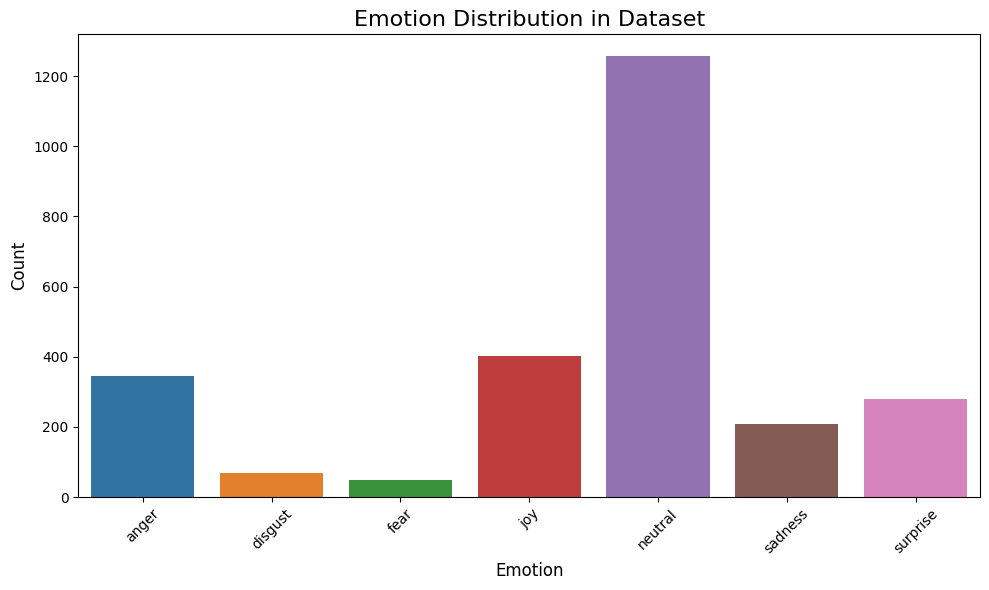

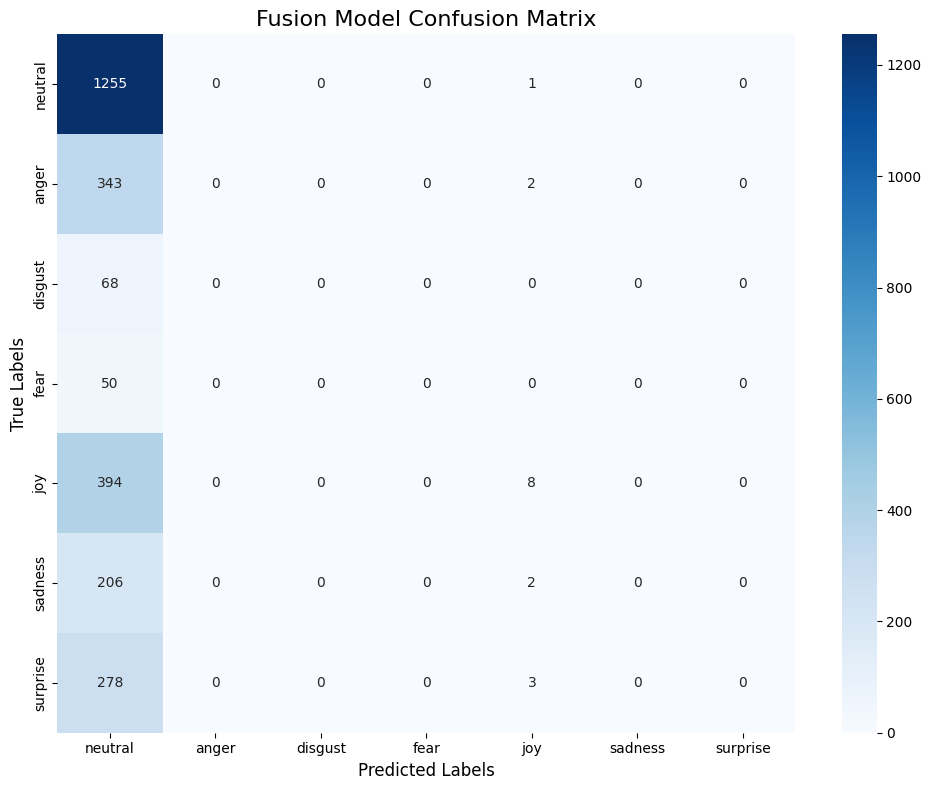

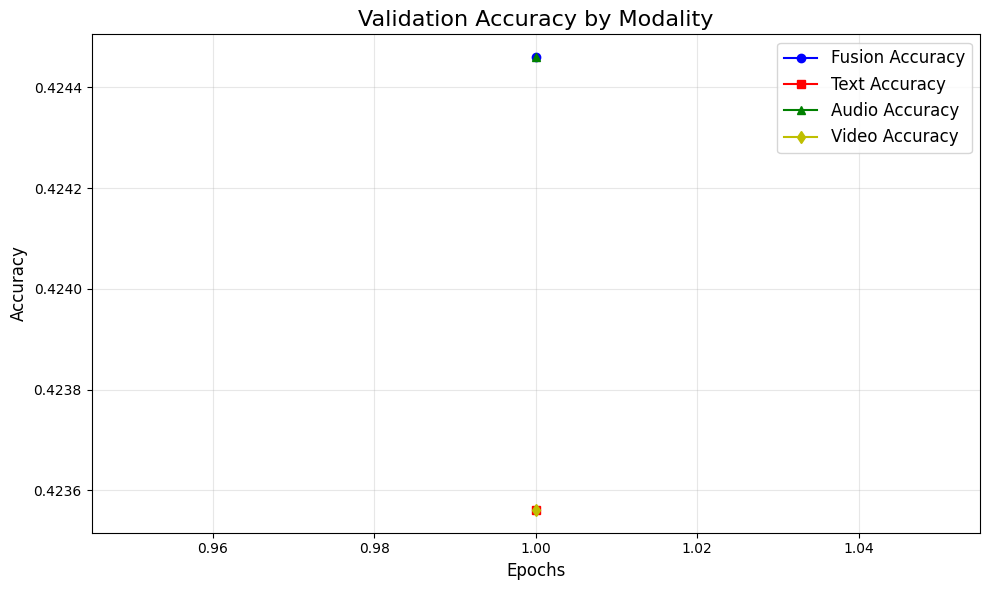

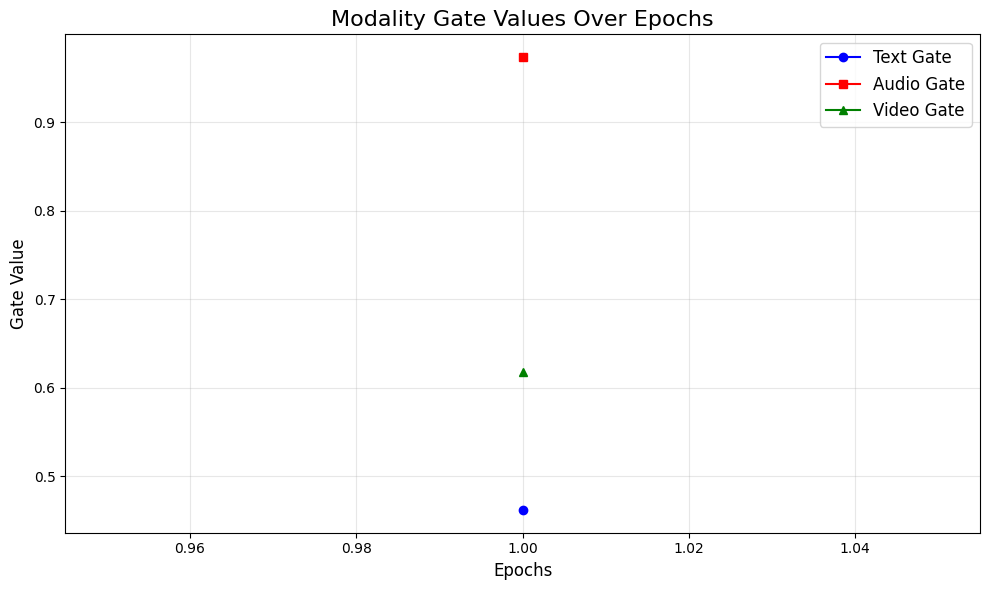

In [10]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from tqdm import tqdm
import transformers
from transformers import BertModel, BertTokenizer, Wav2Vec2Model, Wav2Vec2Processor, ViTModel
import torchvision.transforms as transforms
from PIL import Image
import random
import gc
import copy 

# Set random seeds for reproducibility
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed()

# Check if GPU is available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Define paths for dataset
DATA_PATHS = {
    'train': '/kaggle/input/meld-preprocessed/preprocessed_data/train',
    'dev': '/kaggle/input/meld-preprocessed/preprocessed_data/dev',
    'test': '/kaggle/input/meld-preprocessed/preprocessed_data/test'
}

# Define emotion labels mapping
EMOTION_MAP = {
    'neutral': 0,
    'anger': 1,
    'disgust': 2,
    'fear': 3,
    'joy': 4,
    'sadness': 5,
    'surprise': 6
}

REVERSE_EMOTION_MAP = {v: k for k, v in EMOTION_MAP.items()}

# Define dataset class
class MELDMultimodalDataset(Dataset):
    def __init__(self, data_dir, split='train', max_text_len=128):
        self.data_dir = data_dir
        self.split = split
        self.max_text_len = max_text_len
        
        # Initialize tokenizers and processors
        self.text_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
        self.audio_processor = Wav2Vec2Processor.from_pretrained("facebook/wav2vec2-base-960h")
        
        # Get all file paths
        self.file_paths = [os.path.join(data_dir, f) for f in os.listdir(data_dir) if f.endswith('.pt')]
        print(f"Loaded {len(self.file_paths)} samples for {split} set")

    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, idx):
        sample_path = self.file_paths[idx]
        sample = torch.load(sample_path)
        
        # Process text
        text = sample['utterance']
        text_encodings = self.text_tokenizer(
            text,
            truncation=True,
            max_length=self.max_text_len,
            padding='max_length',
            return_tensors='pt'
        )
        
        input_ids = text_encodings['input_ids'].squeeze()
        attention_mask = text_encodings['attention_mask'].squeeze()
        
        # Process audio
        audio = sample['audio'].squeeze()  # [time]
        
        # Make sure audio has something in it
        if audio.numel() == 0 or torch.all(audio == 0):
            # Create a small dummy audio
            audio = torch.zeros(16000)
        
        # Process audio with Wav2Vec2 processor - normalize and pad/truncate
        # For simpler processing, let's limit audio to 5 seconds max (80000 samples at 16kHz)
        max_audio_len = 80000
        if audio.shape[0] > max_audio_len:
            audio = audio[:max_audio_len]
        else:
            # Pad with zeros
            padding = torch.zeros(max_audio_len - audio.shape[0])
            audio = torch.cat([audio, padding])
        
        # Process video (face)
        face = sample['face']  # [224, 224, 3]
        # Convert to tensor and normalize for ViT
        face_tensor = torch.from_numpy(face).permute(2, 0, 1).float() / 255.0
        # Apply standard normalization for ViT
        normalize = transforms.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225]
        )
        face_tensor = normalize(face_tensor)
        
        # Get emotion label
        emotion = sample['emotion']
        if isinstance(emotion, str):
            emotion = EMOTION_MAP[emotion]
        emotion_tensor = torch.tensor(emotion, dtype=torch.long)
        
        return {
            'text_input_ids': input_ids,
            'text_attention_mask': attention_mask,
            'audio': audio,
            'face': face_tensor,
            'emotion': emotion_tensor,
            'utterance': text  # Keep original text for reference
        }

# Custom collate function to handle variable length data
def collate_fn(batch):
    # Text inputs are already padded
    text_input_ids = torch.stack([item['text_input_ids'] for item in batch])
    text_attention_mask = torch.stack([item['text_attention_mask'] for item in batch])
    
    # Audio is already padded
    audio = torch.stack([item['audio'] for item in batch])
    
    # Face images are fixed size
    face = torch.stack([item['face'] for item in batch])
    
    # Emotion labels
    emotions = torch.stack([item['emotion'] for item in batch])
    
    # Original utterances
    utterances = [item['utterance'] for item in batch]
    
    return {
        'text_input_ids': text_input_ids,
        'text_attention_mask': text_attention_mask,
        'audio': audio,
        'face': face,
        'emotion': emotions,
        'utterance': utterances
    }

# Create data loaders
def get_dataloaders(batch_size=16):
    datasets = {}
    dataloaders = {}
    
    for split, path in DATA_PATHS.items():
        datasets[split] = MELDMultimodalDataset(path, split=split)
        dataloaders[split] = DataLoader(
            datasets[split],
            batch_size=batch_size,
            shuffle=(split == 'train'),
            collate_fn=collate_fn,
            num_workers=2
        )
    
    return dataloaders

# Define model components
class TextEncoder(nn.Module):
    def __init__(self, output_dim=768):
        super(TextEncoder, self).__init__()
        self.bert = BertModel.from_pretrained('bert-base-uncased')
        self.output_dim = output_dim
        
        if output_dim != 768:  # BERT hidden size is 768
            self.proj = nn.Linear(768, output_dim)
        else:
            self.proj = nn.Identity()
    
    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        # Use CLS token embedding as the sentence representation
        cls_embedding = outputs.last_hidden_state[:, 0, :]
        return self.proj(cls_embedding)

class AudioEncoder(nn.Module):
    def __init__(self, output_dim=768):
        super(AudioEncoder, self).__init__()
        self.wav2vec = Wav2Vec2Model.from_pretrained("facebook/wav2vec2-base-960h")
        # Freeze some layers to prevent overfitting
        for param in self.wav2vec.parameters():
            param.requires_grad = False
        # Unfreeze the last 2 layers
        for param in self.wav2vec.encoder.layers[-2:].parameters():
            param.requires_grad = True
        
        # Wav2Vec hidden size is 768
        self.pool = nn.AdaptiveAvgPool1d(1)
        
        if output_dim != 768:
            self.proj = nn.Linear(768, output_dim)
        else:
            self.proj = nn.Identity()
    
    def forward(self, audio):
        # Wav2Vec expects shape [batch_size, sequence_length]
        outputs = self.wav2vec(audio).last_hidden_state  # [batch_size, seq_len, hidden_size]
        
        # Pool across the time dimension
        outputs = outputs.transpose(1, 2)  # [batch_size, hidden_size, seq_len]
        outputs = self.pool(outputs).squeeze(-1)  # [batch_size, hidden_size]
        
        return self.proj(outputs)

class VideoEncoder(nn.Module):
    def __init__(self, output_dim=768):
        super(VideoEncoder, self).__init__()
        self.vit = ViTModel.from_pretrained('google/vit-base-patch16-224')
        # Freeze some layers to prevent overfitting
        for param in self.vit.parameters():
            param.requires_grad = False
        # Unfreeze the last 2 layers
        for param in self.vit.encoder.layer[-2:].parameters():
            param.requires_grad = True
        
        # ViT hidden size is 768
        if output_dim != 768:
            self.proj = nn.Linear(768, output_dim)
        else:
            self.proj = nn.Identity()
    
    def forward(self, images):
        outputs = self.vit(pixel_values=images).last_hidden_state[:, 0, :]  # Use CLS token
        return self.proj(outputs)

# Advanced Fusion Modules
class CrossAttention(nn.Module):
    def __init__(self, dim):
        super(CrossAttention, self).__init__()
        self.query = nn.Linear(dim, dim)
        self.key = nn.Linear(dim, dim)
        self.value = nn.Linear(dim, dim)
        self.scale = dim ** -0.5
        
    def forward(self, x, context):
        # x: query tensor [batch_size, dim]
        # context: key/value tensor [batch_size, dim]
        q = self.query(x).unsqueeze(1)  # [batch_size, 1, dim]
        k = self.key(context).unsqueeze(1)  # [batch_size, 1, dim]
        v = self.value(context).unsqueeze(1)  # [batch_size, 1, dim]
        
        # Compute attention weights
        attn = (q @ k.transpose(-2, -1)) * self.scale  # [batch_size, 1, 1]
        attn = attn.softmax(dim=-1)
        
        # Apply attention to values
        out = (attn @ v).squeeze(1)  # [batch_size, dim]
        return out

class MultimodalFusion(nn.Module):
    def __init__(self, dim):
        super(MultimodalFusion, self).__init__()
        self.dim = dim
        
        # Cross-attention for each modality pair
        self.text_to_audio = CrossAttention(dim)
        self.text_to_video = CrossAttention(dim)
        self.audio_to_text = CrossAttention(dim)
        self.audio_to_video = CrossAttention(dim)
        self.video_to_text = CrossAttention(dim)
        self.video_to_audio = CrossAttention(dim)
        
        # Gating mechanism for dynamic weighting
        self.gate_text = nn.Linear(dim * 3, 1)
        self.gate_audio = nn.Linear(dim * 3, 1)
        self.gate_video = nn.Linear(dim * 3, 1)
        
        # Final projections
        self.proj_text = nn.Linear(dim, dim)
        self.proj_audio = nn.Linear(dim, dim)
        self.proj_video = nn.Linear(dim, dim)
        self.fusion_proj = nn.Linear(dim, dim)
        
        # Layer normalization
        self.norm1 = nn.LayerNorm(dim)
        self.norm2 = nn.LayerNorm(dim)
        
    def forward(self, text_feats, audio_feats, video_feats):
        # Cross-attention interactions
        text_with_audio = self.text_to_audio(text_feats, audio_feats)
        text_with_video = self.text_to_video(text_feats, video_feats)
        
        audio_with_text = self.audio_to_text(audio_feats, text_feats)
        audio_with_video = self.audio_to_video(audio_feats, video_feats)
        
        video_with_text = self.video_to_text(video_feats, text_feats)
        video_with_audio = self.video_to_audio(video_feats, audio_feats)
        
        # Concat original and attended features for gating
        text_concat = torch.cat([text_feats, text_with_audio, text_with_video], dim=1)
        audio_concat = torch.cat([audio_feats, audio_with_text, audio_with_video], dim=1)
        video_concat = torch.cat([video_feats, video_with_text, video_with_audio], dim=1)
        
        # Compute gates
        gate_text = torch.sigmoid(self.gate_text(text_concat))
        gate_audio = torch.sigmoid(self.gate_audio(audio_concat))
        gate_video = torch.sigmoid(self.gate_video(video_concat))
        
        # Normalize gates to sum to 1
        gates = torch.cat([gate_text, gate_audio, gate_video], dim=1)
        gates = F.softmax(gates, dim=1)
        
        # Apply gates and projections
        text_out = self.proj_text(text_feats) * gates[:, 0].unsqueeze(1)
        audio_out = self.proj_audio(audio_feats) * gates[:, 1].unsqueeze(1)
        video_out = self.proj_video(video_feats) * gates[:, 2].unsqueeze(1)
        
        # Combine modalities
        fused = text_out + audio_out + video_out
        fused = self.norm1(fused)
        
        # Non-linear transformation
        fused_proj = self.fusion_proj(fused)
        fused = fused + F.gelu(fused_proj)
        fused = self.norm2(fused)
        
        return fused, {
            'gate_text': gate_text.mean().item(),
            'gate_audio': gate_audio.mean().item(),
            'gate_video': gate_video.mean().item()
        }

# Full multimodal model
class MultimodalEmotionDetector(nn.Module):
    def __init__(self, embedding_dim=256, num_classes=7):
        super(MultimodalEmotionDetector, self).__init__()
        
        # Individual modality encoders
        self.text_encoder = TextEncoder(output_dim=embedding_dim)
        self.audio_encoder = AudioEncoder(output_dim=embedding_dim)
        self.video_encoder = VideoEncoder(output_dim=embedding_dim)
        
        # Fusion module
        self.fusion = MultimodalFusion(embedding_dim)
        
        # Classification head
        self.classifier = nn.Sequential(
            nn.Linear(embedding_dim, embedding_dim // 2),
            nn.LayerNorm(embedding_dim // 2),
            nn.GELU(),
            nn.Dropout(0.1),
            nn.Linear(embedding_dim // 2, num_classes)
        )
        
        # Individual modality classifiers for auxiliary training
        self.text_classifier = nn.Linear(embedding_dim, num_classes)
        self.audio_classifier = nn.Linear(embedding_dim, num_classes)
        self.video_classifier = nn.Linear(embedding_dim, num_classes)
        
    def forward(self, text_input_ids, text_attention_mask, audio, face):
        # Encode each modality
        text_features = self.text_encoder(text_input_ids, text_attention_mask)
        audio_features = self.audio_encoder(audio)
        video_features = self.video_encoder(face)
        
        # Get predictions from individual modalities
        text_logits = self.text_classifier(text_features)
        audio_logits = self.audio_classifier(audio_features)
        video_logits = self.video_classifier(video_features)
        
        # Fuse modalities
        fused_features, gate_values = self.fusion(text_features, audio_features, video_features)
        
        # Get final predictions
        logits = self.classifier(fused_features)
        
        return {
            'logits': logits,
            'text_logits': text_logits,
            'audio_logits': audio_logits,
            'video_logits': video_logits,
            'gate_values': gate_values
        }

def safe_save(data, path):
    """Safe saving function with error handling"""
    try:
        directory = os.path.dirname(path)
        if directory and not os.path.exists(directory):
            os.makedirs(directory, exist_ok=True)
            
        torch.save(data, path)
        print(f"Successfully saved to {path}")
        return True
    except Exception as e:
        print(f"Error saving to {path}: {e}")
        
        # Try saving with CPU tensors if that was the issue
        try:
            if isinstance(data, dict) and 'model_state_dict' in data:
                # Convert model weights to CPU
                cpu_data = data.copy()
                cpu_data['model_state_dict'] = {k: v.cpu() for k, v in data['model_state_dict'].items()}
                torch.save(cpu_data, path)
                print(f"Successfully saved to {path} (using CPU tensors)")
                return True
        except Exception as e2:
            print(f"Failed second save attempt: {e2}")
        
        return False

# Training and evaluation functions
def train_epoch(model, dataloader, optimizer, criterion, device):
    model.train()
    total_loss = 0
    total_fusion_acc = 0
    total_text_acc = 0
    total_audio_acc = 0
    total_video_acc = 0
    
    gate_values = {'text': 0, 'audio': 0, 'video': 0}
    num_batches = 0
    
    progress_bar = tqdm(dataloader, desc="Training")
    for batch in progress_bar:
        # Move inputs to device
        text_input_ids = batch['text_input_ids'].to(device)
        text_attention_mask = batch['text_attention_mask'].to(device)
        audio = batch['audio'].to(device)
        face = batch['face'].to(device)
        labels = batch['emotion'].to(device)
        
        # Forward pass
        outputs = model(text_input_ids, text_attention_mask, audio, face)
        
        # Compute loss - main loss + auxiliary losses from individual modalities
        main_loss = criterion(outputs['logits'], labels)
        text_loss = criterion(outputs['text_logits'], labels)
        audio_loss = criterion(outputs['audio_logits'], labels)
        video_loss = criterion(outputs['video_logits'], labels)
        
        # Weighted loss - main fusion gets higher weight
        loss = main_loss * 0.7 + text_loss * 0.1 + audio_loss * 0.1 + video_loss * 0.1
        
        # Backward pass and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Compute accuracy
        fusion_preds = torch.argmax(outputs['logits'], dim=1)
        text_preds = torch.argmax(outputs['text_logits'], dim=1)
        audio_preds = torch.argmax(outputs['audio_logits'], dim=1)
        video_preds = torch.argmax(outputs['video_logits'], dim=1)
        
        fusion_acc = (fusion_preds == labels).float().mean().item()
        text_acc = (text_preds == labels).float().mean().item()
        audio_acc = (audio_preds == labels).float().mean().item()
        video_acc = (video_preds == labels).float().mean().item()
        
        # Update statistics
        total_loss += loss.item()
        total_fusion_acc += fusion_acc
        total_text_acc += text_acc
        total_audio_acc += audio_acc
        total_video_acc += video_acc
        
        # Track gate values
        gate_values['text'] += outputs['gate_values']['gate_text']
        gate_values['audio'] += outputs['gate_values']['gate_audio']
        gate_values['video'] += outputs['gate_values']['gate_video']
        
        num_batches += 1
        
        # Update progress bar
        progress_bar.set_postfix({
            'loss': f"{loss.item():.4f}",
            'fusion_acc': f"{fusion_acc:.4f}"
        })
    
    # Compute averages
    avg_loss = total_loss / num_batches
    avg_fusion_acc = total_fusion_acc / num_batches
    avg_text_acc = total_text_acc / num_batches
    avg_audio_acc = total_audio_acc / num_batches
    avg_video_acc = total_video_acc / num_batches
    
    # Average gate values
    for key in gate_values:
        gate_values[key] /= num_batches
    
    return {
        'loss': avg_loss,
        'fusion_acc': avg_fusion_acc,
        'text_acc': avg_text_acc,
        'audio_acc': avg_audio_acc,
        'video_acc': avg_video_acc,
        'gate_values': gate_values
    }

def evaluate(model, dataloader, criterion, device):
    model.eval()
    total_loss = 0
    total_fusion_acc = 0
    total_text_acc = 0
    total_audio_acc = 0
    total_video_acc = 0
    
    gate_values = {'text': 0, 'audio': 0, 'video': 0}
    num_batches = 0
    
    all_fusion_preds = []
    all_text_preds = []
    all_audio_preds = []
    all_video_preds = []
    all_labels = []
    
    with torch.no_grad():
        progress_bar = tqdm(dataloader, desc="Evaluating")
        for batch in progress_bar:
            # Move inputs to device
            text_input_ids = batch['text_input_ids'].to(device)
            text_attention_mask = batch['text_attention_mask'].to(device)
            audio = batch['audio'].to(device)
            face = batch['face'].to(device)
            labels = batch['emotion'].to(device)
            
            # Forward pass
            outputs = model(text_input_ids, text_attention_mask, audio, face)
            
            # Compute loss - main loss only for evaluation
            loss = criterion(outputs['logits'], labels)
            
            # Compute predictions
            fusion_preds = torch.argmax(outputs['logits'], dim=1)
            text_preds = torch.argmax(outputs['text_logits'], dim=1)
            audio_preds = torch.argmax(outputs['audio_logits'], dim=1)
            video_preds = torch.argmax(outputs['video_logits'], dim=1)
            
            # Save predictions and labels for metrics
            all_fusion_preds.extend(fusion_preds.cpu().numpy())
            all_text_preds.extend(text_preds.cpu().numpy())
            all_audio_preds.extend(audio_preds.cpu().numpy())
            all_video_preds.extend(video_preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            
            # Compute accuracy
            fusion_acc = (fusion_preds == labels).float().mean().item()
            text_acc = (text_preds == labels).float().mean().item()
            audio_acc = (audio_preds == labels).float().mean().item()
            video_acc = (video_preds == labels).float().mean().item()
            
            # Update statistics
            total_loss += loss.item()
            total_fusion_acc += fusion_acc
            total_text_acc += text_acc
            total_audio_acc += audio_acc
            total_video_acc += video_acc
            
            # Track gate values
            gate_values['text'] += outputs['gate_values']['gate_text']
            gate_values['audio'] += outputs['gate_values']['gate_audio']
            gate_values['video'] += outputs['gate_values']['gate_video']
            
            num_batches += 1
            
            # Update progress bar
            progress_bar.set_postfix({
                'loss': f"{loss.item():.4f}",
                'fusion_acc': f"{fusion_acc:.4f}"
            })
    
    # Compute averages
    avg_loss = total_loss / num_batches
    avg_fusion_acc = total_fusion_acc / num_batches
    avg_text_acc = total_text_acc / num_batches
    avg_audio_acc = total_audio_acc / num_batches
    avg_video_acc = total_video_acc / num_batches
    
    # Average gate values
    for key in gate_values:
        gate_values[key] /= num_batches
    
    # Compute confusion matrix and classification report
    fusion_cm = confusion_matrix(all_labels, all_fusion_preds)
    text_cm = confusion_matrix(all_labels, all_text_preds)
    audio_cm = confusion_matrix(all_labels, all_audio_preds)
    video_cm = confusion_matrix(all_labels, all_video_preds)
    
    fusion_report = classification_report(all_labels, all_fusion_preds, target_names=list(EMOTION_MAP.keys()), output_dict=True)
    text_report = classification_report(all_labels, all_text_preds, target_names=list(EMOTION_MAP.keys()), output_dict=True)
    audio_report = classification_report(all_labels, all_audio_preds, target_names=list(EMOTION_MAP.keys()), output_dict=True)
    video_report = classification_report(all_labels, all_video_preds, target_names=list(EMOTION_MAP.keys()), output_dict=True)
    
    return {
        'loss': avg_loss,
        'fusion_acc': avg_fusion_acc,
        'text_acc': avg_text_acc,
        'audio_acc': avg_audio_acc,
        'video_acc': avg_video_acc,
        'gate_values': gate_values,
        'fusion_cm': fusion_cm,
        'text_cm': text_cm,
        'audio_cm': audio_cm,
        'video_cm': video_cm,
        'fusion_report': fusion_report,
        'text_report': text_report,
        'audio_report': audio_report,
        'video_report': video_report,
        'all_fusion_preds': all_fusion_preds,
        'all_text_preds': all_text_preds, 
        'all_audio_preds': all_audio_preds,
        'all_video_preds': all_video_preds,
        'all_labels': all_labels
    }

# Visualization functions
def plot_confusion_matrix(cm, class_names, title='Confusion Matrix'):
    """
    Plot confusion matrix
    """
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title(title, fontsize=16)
    plt.ylabel('True Labels', fontsize=12)
    plt.xlabel('Predicted Labels', fontsize=12)
    plt.tight_layout()
    plt.show()

def plot_accuracy_comparison(history):
    """
    Plot accuracy comparison between modalities
    """
    plt.figure(figsize=(10, 6))
    epochs = range(1, len(history['fusion_acc']) + 1)
    plt.plot(epochs, history['fusion_acc'], 'b-', marker='o', label='Fusion Accuracy')
    plt.plot(epochs, history['text_acc'], 'r-', marker='s', label='Text Accuracy')
    plt.plot(epochs, history['audio_acc'], 'g-', marker='^', label='Audio Accuracy')
    plt.plot(epochs, history['video_acc'], 'y-', marker='d', label='Video Accuracy')
    
    plt.title('Validation Accuracy by Modality', fontsize=16)
    plt.xlabel('Epochs', fontsize=12)
    plt.ylabel('Accuracy', fontsize=12)
    plt.legend(fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

def plot_gate_values(history):
    """
    Plot gate values over epochs
    """
    plt.figure(figsize=(10, 6))
    epochs = range(1, len(history['gate_text']) + 1)
    plt.plot(epochs, history['gate_text'], 'b-', marker='o', label='Text Gate')
    plt.plot(epochs, history['gate_audio'], 'r-', marker='s', label='Audio Gate')
    plt.plot(epochs, history['gate_video'], 'g-', marker='^', label='Video Gate')
    
    plt.title('Modality Gate Values Over Epochs', fontsize=16)
    plt.xlabel('Epochs', fontsize=12)
    plt.ylabel('Gate Value', fontsize=12)
    plt.legend(fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

def plot_emotion_distribution(labels):
    """
    Plot distribution of emotions in the dataset
    """
    # Convert numeric labels to emotion names
    emotion_names = [REVERSE_EMOTION_MAP[label] for label in labels]
    
    plt.figure(figsize=(10, 6))
    counts = pd.Series(emotion_names).value_counts().sort_index()
    sns.barplot(x=counts.index, y=counts.values)
    plt.title('Emotion Distribution in Dataset', fontsize=16)
    plt.xlabel('Emotion', fontsize=12)
    plt.ylabel('Count', fontsize=12)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

def plot_per_class_metrics(report, title="Per-Class F1 Scores"):
    """
    Plot per-class F1 scores from classification report
    """
    # Extract per-class F1 scores
    classes = []
    f1_scores = []
    
    for class_name, metrics in report.items():
        if class_name not in ['accuracy', 'macro avg', 'weighted avg']:
            classes.append(class_name)
            f1_scores.append(metrics['f1-score'])
    
    plt.figure(figsize=(10, 6))
    sns.barplot(x=classes, y=f1_scores)
    plt.title(title, fontsize=16)
    plt.xlabel('Class', fontsize=12)
    plt.ylabel('F1 Score', fontsize=12)
    plt.ylim(0, 1.0)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

def suppress_warnings():
    import warnings
    import logging
    from transformers import logging as transformers_logging
    
    # Suppress all warnings
    warnings.filterwarnings("ignore")
    
    # Suppress sklearn warnings
    logging.getLogger("sklearn").setLevel(logging.ERROR)
    
    # Suppress transformers warnings
    transformers_logging.set_verbosity_error()
    
    # Suppress PyTorch future warnings
    warnings.simplefilter(action='ignore', category=FutureWarning)


# Main training loop
def train_model(model, dataloaders, criterion, optimizer, scheduler, num_epochs=5, 
                device='cuda', checkpoint_dir='/kaggle/working/checkpoints'):
    """
    Train the full model (modified for Kaggle)
    """
    # Make sure the directory exists
    os.makedirs(checkpoint_dir, exist_ok=True)

    
    """
    Train the full model with periodic checkpoints
    """
    # Track metrics and history
    history = {
        'train_loss': [], 'train_fusion_acc': [], 'train_text_acc': [], 'train_audio_acc': [], 'train_video_acc': [],
        'val_loss': [], 'fusion_acc': [], 'text_acc': [], 'audio_acc': [], 'video_acc': [],
        'gate_text': [], 'gate_audio': [], 'gate_video': []
    }
    
    best_val_acc = 0.0
    best_model_weights = model.state_dict().copy()  # Initialize with current weights
    
    for epoch in range(num_epochs):
        print(f"Epoch {epoch+1}/{num_epochs}")
        print('-' * 50)
        
        # Training phase
        train_metrics = train_epoch(model, dataloaders['train'], optimizer, criterion, device)
        
        # Update learning rate
        if scheduler:
            scheduler.step()
        
        # Validation phase
        val_metrics = evaluate(model, dataloaders['dev'], criterion, device)
        
        # Track metrics
        history['train_loss'].append(train_metrics['loss'])
        history['train_fusion_acc'].append(train_metrics['fusion_acc'])
        history['train_text_acc'].append(train_metrics['text_acc'])
        history['train_audio_acc'].append(train_metrics['audio_acc'])
        history['train_video_acc'].append(train_metrics['video_acc'])
        
        history['val_loss'].append(val_metrics['loss'])
        history['fusion_acc'].append(val_metrics['fusion_acc'])
        history['text_acc'].append(val_metrics['text_acc'])
        history['audio_acc'].append(val_metrics['audio_acc'])
        history['video_acc'].append(val_metrics['video_acc'])
        
        history['gate_text'].append(val_metrics['gate_values']['text'])
        history['gate_audio'].append(val_metrics['gate_values']['audio'])
        history['gate_video'].append(val_metrics['gate_values']['video'])
        
        # Print epoch results
        print(f"Train Loss: {train_metrics['loss']:.4f} | Fusion Acc: {train_metrics['fusion_acc']:.4f}")
        print(f"Text Acc: {train_metrics['text_acc']:.4f} | Audio Acc: {train_metrics['audio_acc']:.4f} | Video Acc: {train_metrics['video_acc']:.4f}")
        print(f"Gate Values - Text: {train_metrics['gate_values']['text']:.4f} | Audio: {train_metrics['gate_values']['audio']:.4f} | Video: {train_metrics['gate_values']['video']:.4f}")
        
        print(f"Val Loss: {val_metrics['loss']:.4f} | Fusion Acc: {val_metrics['fusion_acc']:.4f}")
        print(f"Text Acc: {val_metrics['text_acc']:.4f} | Audio Acc: {val_metrics['audio_acc']:.4f} | Video Acc: {val_metrics['video_acc']:.4f}")
        print(f"Gate Values - Text: {val_metrics['gate_values']['text']:.4f} | Audio: {val_metrics['gate_values']['audio']:.4f} | Video: {val_metrics['gate_values']['video']:.4f}")
        
        # Save checkpoint every epoch
        checkpoint_path = os.path.join(checkpoint_dir, f'checkpoint_epoch_{epoch+1}.pt')
        # Save checkpoint every epoch
        checkpoint_path = os.path.join(checkpoint_dir, f'checkpoint_epoch_{epoch+1}.pt')
        save_success = safe_save({
            'epoch': epoch + 1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict() if scheduler else None,
            'history': history,
            'best_val_acc': best_val_acc
        }, checkpoint_path)
        if save_success:
            print(f"Checkpoint saved to {checkpoint_path}")
        
        best_model_path = os.path.join(checkpoint_dir, 'best_model.pt')
        best_save_success = safe_save({
            'epoch': epoch + 1,
            'model_state_dict': best_model_weights,
            'history': history,
            'best_val_acc': best_val_acc
        }, best_model_path)
        if best_save_success:
            print(f"New best model saved with validation accuracy: {best_val_acc:.4f}")
                
            print()
            
            print(f"Best validation accuracy: {best_val_acc:.4f}")
        
    if best_model_weights is not None:
        model.load_state_dict(best_model_weights)
    
    return model, history

# Main execution
def main(mode='train', batch_size=8, epochs=1, lr=1e-4, resume_from=0):
    # Set model paths for Kaggle
    model_path = '/kaggle/working/multimodal_emotion_model.pt'
    checkpoint_dir = '/kaggle/working/checkpoints'
    
    # Create checkpoint directory
    os.makedirs(checkpoint_dir, exist_ok=True)
    
    # Rest of your function...

    suppress_warnings()
    """
    Main function with parameters instead of command-line arguments
    """
    # Get dataloaders
    dataloaders = get_dataloaders(batch_size=batch_size)
    
    if mode == 'train':
        if resume_from > 0:
            # Resume training from checkpoint
            print(f"Resuming training from epoch {resume_from}...")
            
            # Create model
            model = MultimodalEmotionDetector(embedding_dim=256, num_classes=len(EMOTION_MAP))
            
            # Load checkpoint
            checkpoint_path = os.path.join(checkpoint_dir, f'checkpoint_epoch_{resume_from}.pt')
            print(f"Loading checkpoint from {checkpoint_path}...")
            checkpoint = torch.load(checkpoint_path)
            model.load_state_dict(checkpoint['model_state_dict'])
            model = model.to(device)
            
            # Create optimizer and scheduler
            optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-5)
            optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
            
            scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.9)
            if checkpoint['scheduler_state_dict']:
                scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
            
            # Define loss function
            criterion = nn.CrossEntropyLoss()
            
            # Resume training
            remaining_epochs = epochs - resume_from
            model, history = train_model(
                model=model,
                dataloaders=dataloaders,
                criterion=criterion,
                optimizer=optimizer,
                scheduler=scheduler,
                num_epochs=remaining_epochs,
                device=device,
                checkpoint_dir=checkpoint_dir
            )
        else:
            # Start training from scratch
            # Create model
            model = MultimodalEmotionDetector(embedding_dim=256, num_classes=len(EMOTION_MAP))
            model = model.to(device)
            
            # Define loss function and optimizer
            criterion = nn.CrossEntropyLoss()
            optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-5)
            
            # Learning rate scheduler
            scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.9)
            
            # Train model
            model, history = train_model(
                model=model,
                dataloaders=dataloaders,
                criterion=criterion,
                optimizer=optimizer,
                scheduler=scheduler,
                num_epochs=epochs,
                device=device,
                checkpoint_dir=checkpoint_dir
            )
        
        # Free up memory
        gc.collect()
        torch.cuda.empty_cache()
        
        # Evaluate on test set
        criterion = nn.CrossEntropyLoss()
        test_metrics = evaluate(model, dataloaders['test'], criterion, device)
        
        # Save the model and results
        safe_save({
            'model_state_dict': model.state_dict(),
            'history': history,
            'test_metrics': test_metrics
        }, model_path)
        
        # Display test results
        print("\n=== Test Set Results ===")
        print(f"Test Loss: {test_metrics['loss']:.4f}")
        print(f"Fusion Accuracy: {test_metrics['fusion_acc']:.4f}")
        print(f"Text Accuracy: {test_metrics['text_acc']:.4f}")
        print(f"Audio Accuracy: {test_metrics['audio_acc']:.4f}")
        print(f"Video Accuracy: {test_metrics['video_acc']:.4f}")
        
        # Plot results
        plot_emotion_distribution(test_metrics['all_labels'])
        
        # Confusion matrices
        plot_confusion_matrix(
            test_metrics['fusion_cm'], 
            class_names=list(EMOTION_MAP.keys()), 
            title='Fusion Model Confusion Matrix'
        )
        
        # Accuracy comparison
        plot_accuracy_comparison(history)
        
        # Gate values
        plot_gate_values(history)
        
        return model, history, test_metrics
        
    elif mode == 'evaluate':
        # Load model
        print(f"Loading model from {model_path}...")
        checkpoint = torch.load(model_path)
        model = MultimodalEmotionDetector(embedding_dim=256, num_classes=len(EMOTION_MAP))
        model.load_state_dict(checkpoint['model_state_dict'])
        model = model.to(device)
        
        # Evaluate on test set
        criterion = nn.CrossEntropyLoss()
        test_metrics = evaluate(model, dataloaders['test'], criterion, device)
        
        # Display test results
        print("\n=== Test Set Results ===")
        print(f"Test Loss: {test_metrics['loss']:.4f}")
        print(f"Fusion Accuracy: {test_metrics['fusion_acc']:.4f}")
        print(f"Text Accuracy: {test_metrics['text_acc']:.4f}")
        print(f"Audio Accuracy: {test_metrics['audio_acc']:.4f}")
        print(f"Video Accuracy: {test_metrics['video_acc']:.4f}")
        
        # Print full classification report
        print("\n=== Fusion Model Classification Report ===")
        print(classification_report(test_metrics['all_labels'], test_metrics['all_fusion_preds'], 
                                target_names=list(EMOTION_MAP.keys())))
        
        # Plot results
        plot_emotion_distribution(test_metrics['all_labels'])
        
        # Confusion matrices
        plot_confusion_matrix(
            test_metrics['fusion_cm'], 
            class_names=list(EMOTION_MAP.keys()), 
            title='Fusion Model Confusion Matrix'
        )
        
        # Per-class metrics
        plot_per_class_metrics(test_metrics['fusion_report'], title="Fusion Model: Per-Class F1 Scores")
        plot_per_class_metrics(test_metrics['text_report'], title="Text Model: Per-Class F1 Scores")
        plot_per_class_metrics(test_metrics['audio_report'], title="Audio Model: Per-Class F1 Scores")
        plot_per_class_metrics(test_metrics['video_report'], title="Video Model: Per-Class F1 Scores")
        
        return model, test_metrics
        
    elif mode == 'visualize':
        # Load model
        print(f"Loading model from {model_path}...")
        checkpoint = torch.load(model_path)
        model = MultimodalEmotionDetector(embedding_dim=256, num_classes=len(EMOTION_MAP))
        model.load_state_dict(checkpoint['model_state_dict'])
        model = model.to(device)
        history = checkpoint.get('history', None)
        test_metrics = checkpoint.get('test_metrics', None)
        
        # If no test metrics, evaluate on test set
        if test_metrics is None:
            criterion = nn.CrossEntropyLoss()
            test_metrics = evaluate(model, dataloaders['test'], criterion, device)
        
        # Visualize emotion distribution
        plot_emotion_distribution(test_metrics['all_labels'])
        
        # Visualize confusion matrices
        for name, cm in [
            ('Fusion Model', test_metrics['fusion_cm']),
            ('Text Model', test_metrics['text_cm']),
            ('Audio Model', test_metrics['audio_cm']),
            ('Video Model', test_metrics['video_cm'])
        ]:
            plot_confusion_matrix(cm, class_names=list(EMOTION_MAP.keys()), title=f'{name} Confusion Matrix')
        
        # Visualize per-class metrics
        for name, report in [
            ('Fusion Model', test_metrics['fusion_report']),
            ('Text Model', test_metrics['text_report']),
            ('Audio Model', test_metrics['audio_report']),
            ('Video Model', test_metrics['video_report'])
        ]:
            plot_per_class_metrics(report, title=f'{name}: Per-Class F1 Scores')
        
        # Visualize accuracy comparison and gate values if history exists
        if history:
            plot_accuracy_comparison(history)
            plot_gate_values(history)
            
        # Print full classification reports
        print("\n=== Fusion Model Classification Report ===")
        print(classification_report(test_metrics['all_labels'], test_metrics['all_fusion_preds'], 
                                target_names=list(EMOTION_MAP.keys())))
        
        return model, test_metrics
    
    else:
        print(f"Unknown mode: {mode}")
        return None

if __name__ == "__main__":
    # When running as a script
    import argparse
    parser = argparse.ArgumentParser(description='Multimodal Emotion Detection')
    parser.add_argument('--mode', type=str, default='train', choices=['train', 'evaluate', 'visualize'],
                      help='Mode to run the script in')
    parser.add_argument('--model_path', type=str, default='multimodal_emotion_model.pt',
                      help='Path to save/load the model')
    parser.add_argument('--checkpoint_dir', type=str, default='./checkpoints',
                      help='Directory to save checkpoints during training')
    parser.add_argument('--batch_size', type=int, default=8,
                      help='Batch size for training and evaluation')
    parser.add_argument('--epochs', type=int, default=10,
                      help='Number of epochs for training')
    parser.add_argument('--lr', type=float, default=1e-4,
                      help='Learning rate')
    parser.add_argument('--resume_from', type=int, default=0,
                      help='Resume training from this epoch (0 means start from scratch)')
    
    try:
        args = parser.parse_args()
        main(mode=args.mode, model_path=args.model_path, checkpoint_dir=args.checkpoint_dir,
             batch_size=args.batch_size, epochs=args.epochs, lr=args.lr, resume_from=args.resume_from)
    except SystemExit:
        # Running in a notebook environment
        print("Running in notebook environment - using default parameters")
        main()  # Use default parameters

Using device: cuda:0
Loaded 9988 samples for train set
Loaded 1108 samples for dev set
Loaded 2610 samples for test set
Epoch 1/1
--------------------------------------------------


Evaluating: 100%|██████████| 139/139 [00:44<00:00,  3.12it/s, loss=1.4775, fusion_acc=0.5000]


Train Loss: 1.4857 | Fusion Acc: 0.5026
Text Acc: 0.5027 | Audio Acc: 0.4714 | Video Acc: 0.4650
Gate Values - Text: 0.5247 | Audio: 0.4501 | Video: 0.5509
Val Loss: 1.6088 | Fusion Acc: 0.4254
Text Acc: 0.4236 | Audio Acc: 0.4191 | Video Acc: 0.4236
Gate Values - Text: 0.1310 | Audio: 0.9580 | Video: 0.7485
New best validation accuracy: 0.4254

Best validation accuracy: 0.4254


Evaluating: 100%|██████████| 327/327 [01:45<00:00,  3.11it/s, loss=1.6865, fusion_acc=0.5000]



=== Test Set Results ===
Test Loss: 1.5006
Fusion Accuracy: 0.4836
Text Accuracy: 0.4813
Audio Accuracy: 0.4790
Video Accuracy: 0.4813


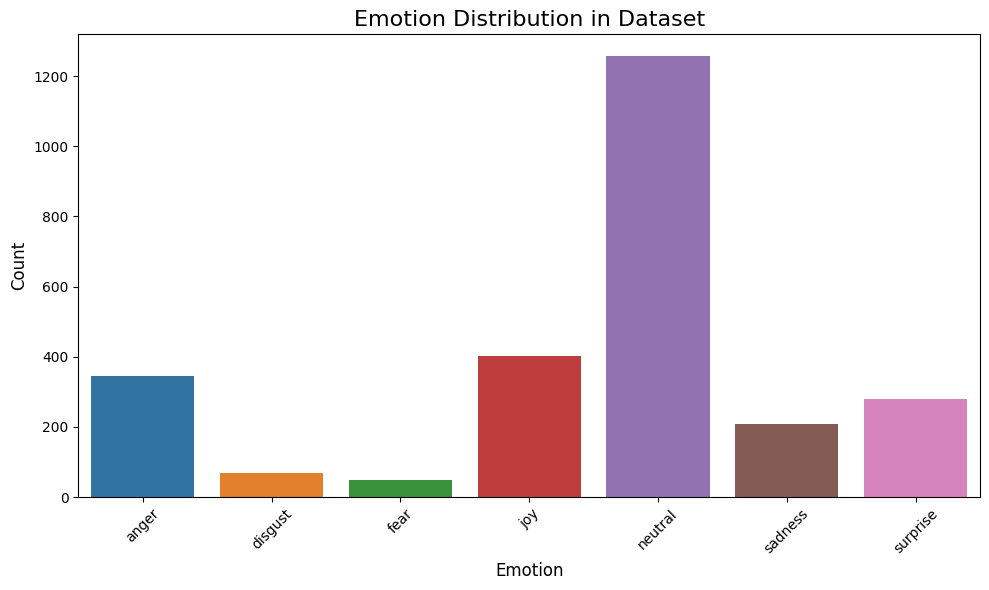

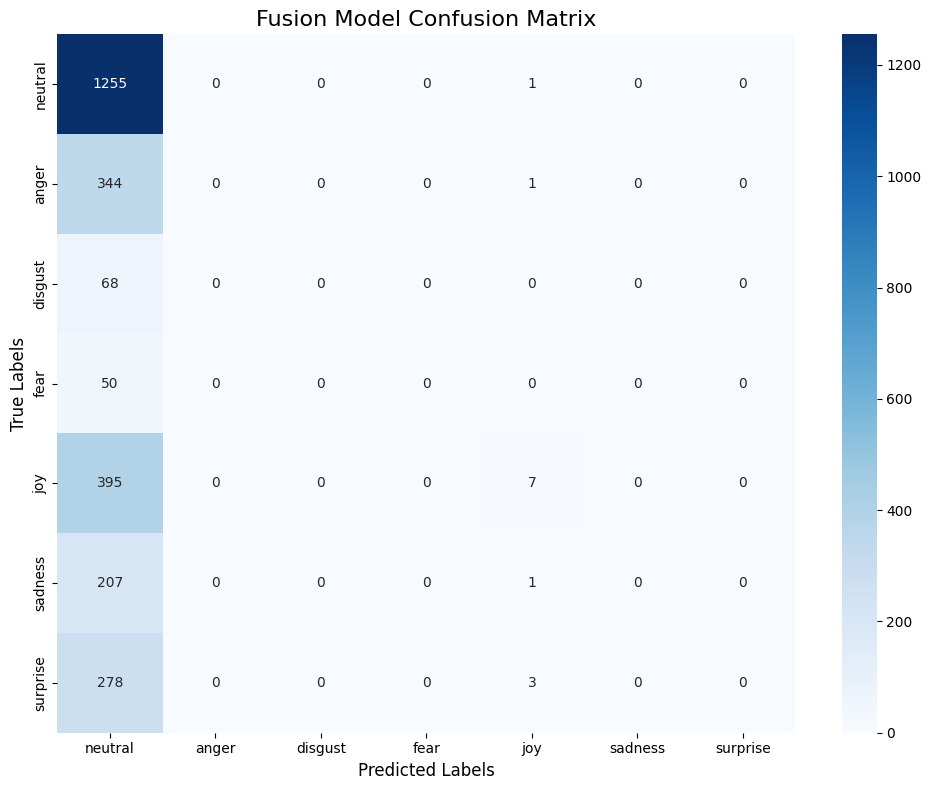

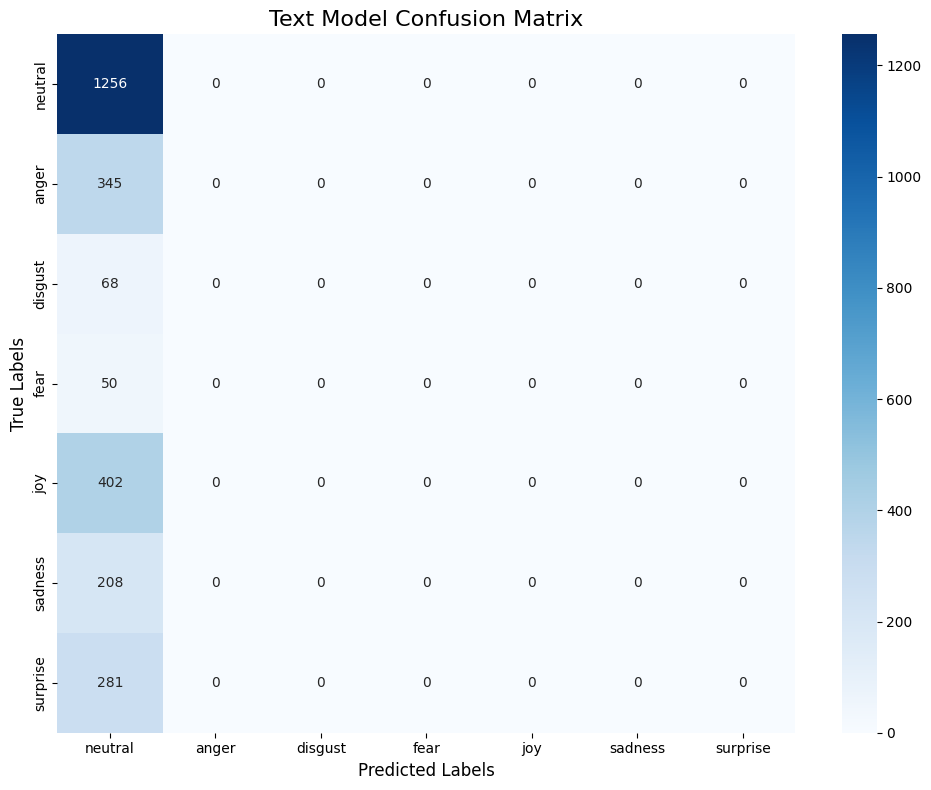

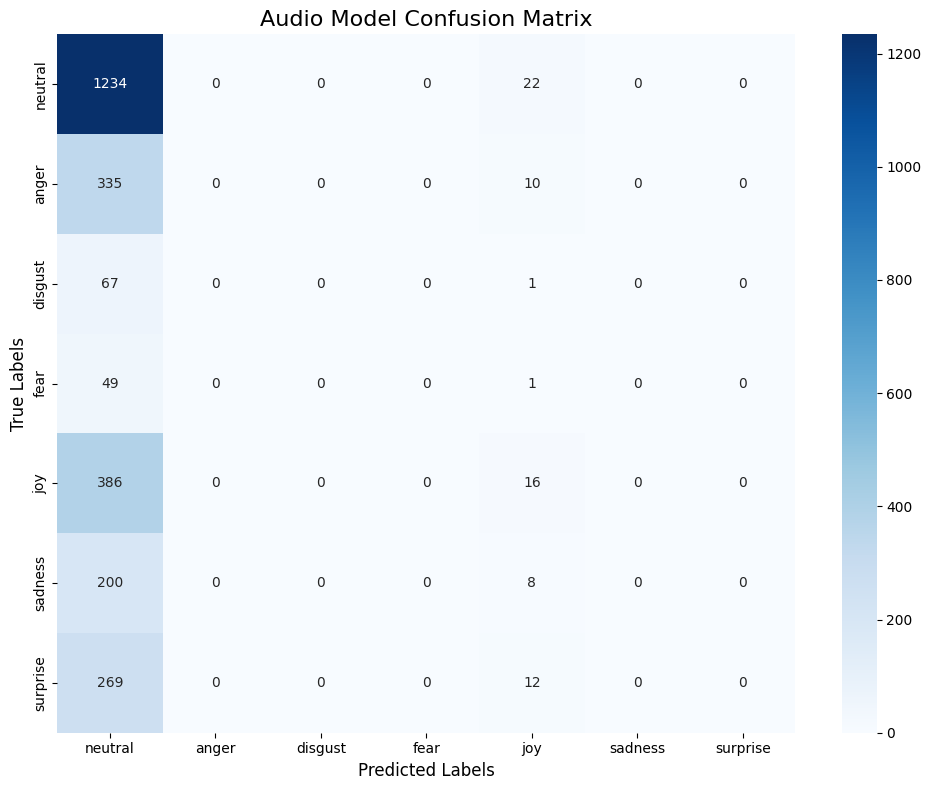

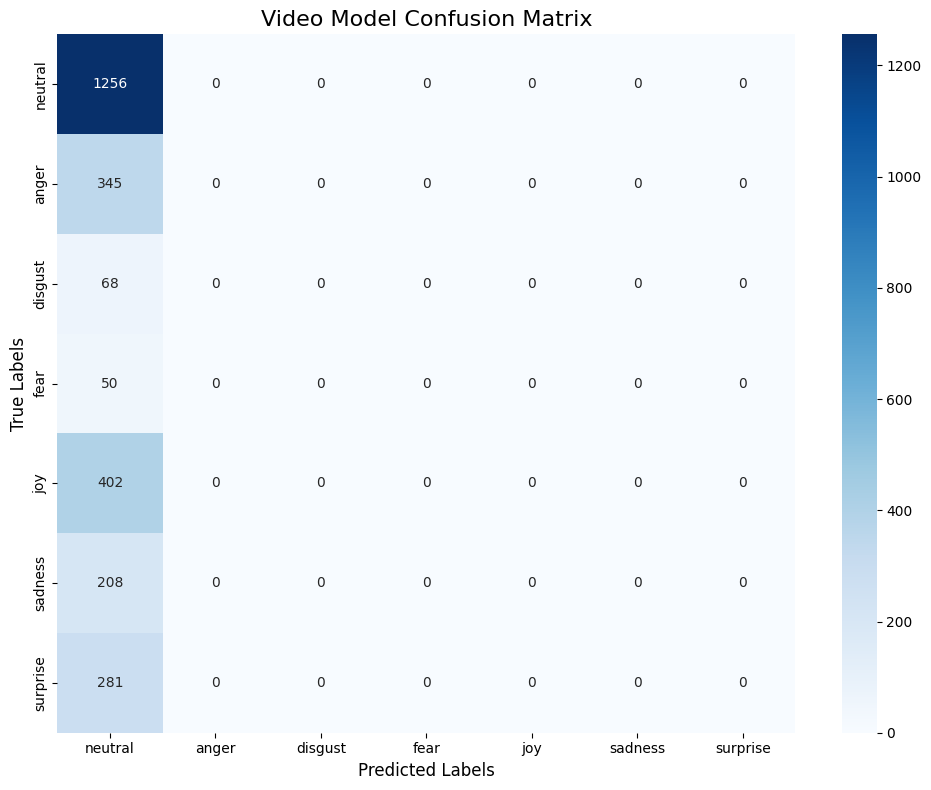

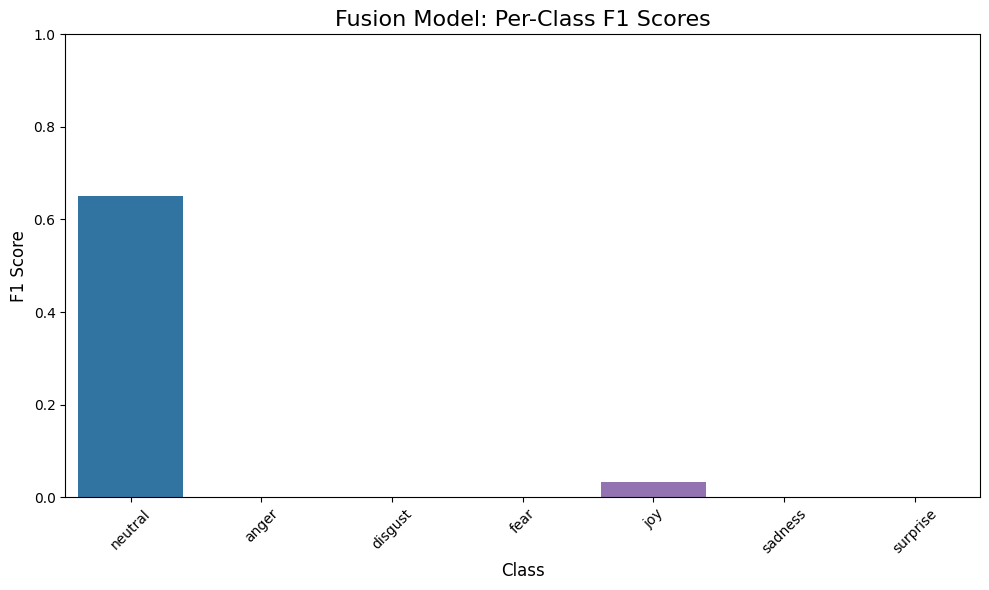

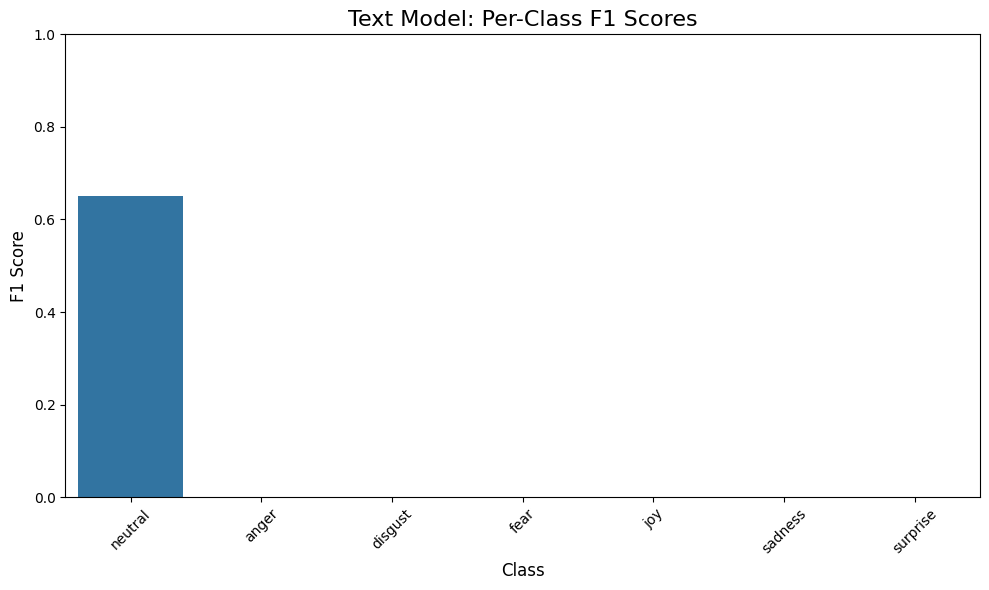

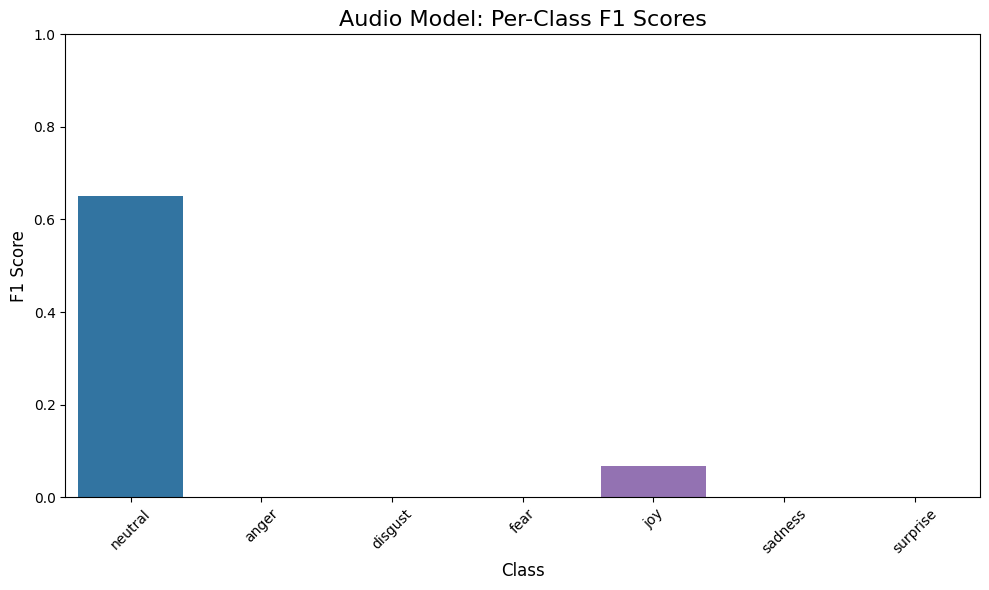

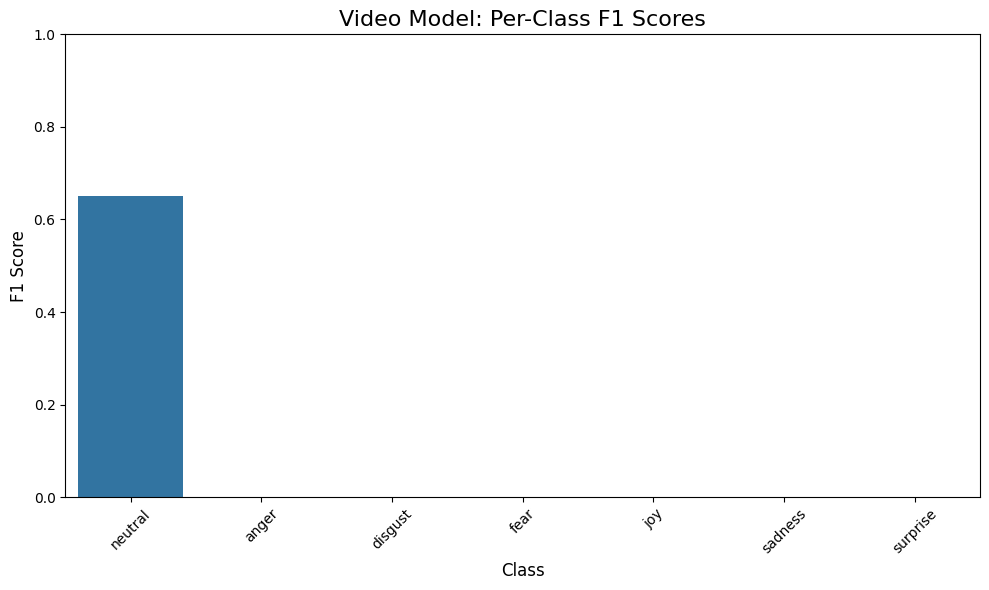

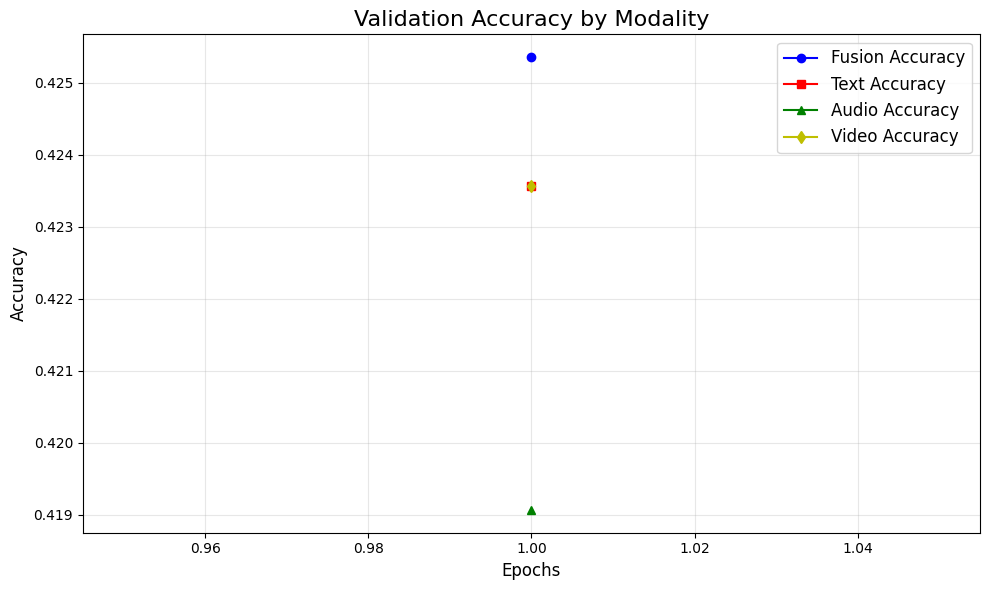

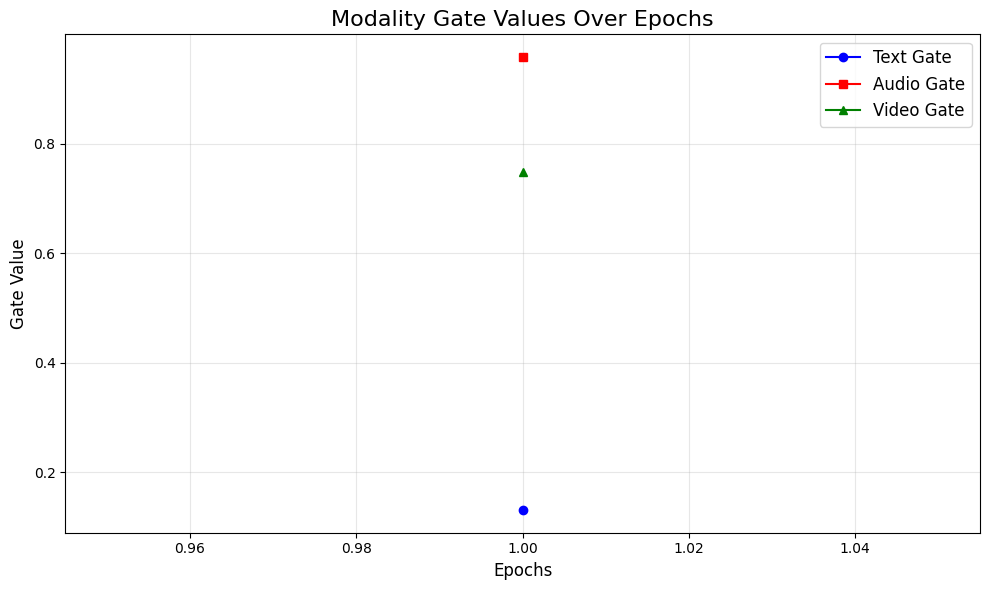


=== Fusion Model Classification Report ===
              precision    recall  f1-score   support

     neutral       0.48      1.00      0.65      1256
       anger       0.00      0.00      0.00       345
     disgust       0.00      0.00      0.00        68
        fear       0.00      0.00      0.00        50
         joy       0.54      0.02      0.03       402
     sadness       0.00      0.00      0.00       208
    surprise       0.00      0.00      0.00       281

    accuracy                           0.48      2610
   macro avg       0.15      0.15      0.10      2610
weighted avg       0.32      0.48      0.32      2610



<Figure size 640x480 with 0 Axes>

In [14]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from tqdm import tqdm
import transformers
from transformers import BertModel, BertTokenizer, Wav2Vec2Model, Wav2Vec2Processor, ViTModel
import torchvision.transforms as transforms
from PIL import Image
import random
import gc

# Set random seeds for reproducibility
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed()

# Check if GPU is available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Define paths for dataset
DATA_PATHS = {
    'train': '/kaggle/input/meld-preprocessed/preprocessed_data/train',
    'dev': '/kaggle/input/meld-preprocessed/preprocessed_data/dev',
    'test': '/kaggle/input/meld-preprocessed/preprocessed_data/test'
}

# Define emotion labels mapping
EMOTION_MAP = {
    'neutral': 0,
    'anger': 1,
    'disgust': 2,
    'fear': 3,
    'joy': 4,
    'sadness': 5,
    'surprise': 6
}

REVERSE_EMOTION_MAP = {v: k for k, v in EMOTION_MAP.items()}

# Define dataset class
class MELDMultimodalDataset(Dataset):
    def __init__(self, data_dir, split='train', max_text_len=128):
        self.data_dir = data_dir
        self.split = split
        self.max_text_len = max_text_len
        
        # Initialize tokenizers and processors
        self.text_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
        self.audio_processor = Wav2Vec2Processor.from_pretrained("facebook/wav2vec2-base-960h")
        
        # Get all file paths
        self.file_paths = [os.path.join(data_dir, f) for f in os.listdir(data_dir) if f.endswith('.pt')]
        print(f"Loaded {len(self.file_paths)} samples for {split} set")

    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, idx):
        sample_path = self.file_paths[idx]
        sample = torch.load(sample_path)
        
        # Process text
        text = sample['utterance']
        text_encodings = self.text_tokenizer(
            text,
            truncation=True,
            max_length=self.max_text_len,
            padding='max_length',
            return_tensors='pt'
        )
        
        input_ids = text_encodings['input_ids'].squeeze()
        attention_mask = text_encodings['attention_mask'].squeeze()
        
        # Process audio
        audio = sample['audio'].squeeze()  # [time]
        
        # Make sure audio has something in it
        if audio.numel() == 0 or torch.all(audio == 0):
            # Create a small dummy audio
            audio = torch.zeros(16000)
        
        # Process audio with Wav2Vec2 processor - normalize and pad/truncate
        # For simpler processing, let's limit audio to 5 seconds max (80000 samples at 16kHz)
        max_audio_len = 80000
        if audio.shape[0] > max_audio_len:
            audio = audio[:max_audio_len]
        else:
            # Pad with zeros
            padding = torch.zeros(max_audio_len - audio.shape[0])
            audio = torch.cat([audio, padding])
        
        # Process video (face)
        face = sample['face']  # [224, 224, 3]
        # Convert to tensor and normalize for ViT
        face_tensor = torch.from_numpy(face).permute(2, 0, 1).float() / 255.0
        # Apply standard normalization for ViT
        normalize = transforms.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225]
        )
        face_tensor = normalize(face_tensor)
        
        # Get emotion label
        emotion = sample['emotion']
        if isinstance(emotion, str):
            emotion = EMOTION_MAP[emotion]
        emotion_tensor = torch.tensor(emotion, dtype=torch.long)
        
        return {
            'text_input_ids': input_ids,
            'text_attention_mask': attention_mask,
            'audio': audio,
            'face': face_tensor,
            'emotion': emotion_tensor,
            'utterance': text  # Keep original text for reference
        }

# Custom collate function to handle variable length data
def collate_fn(batch):
    # Text inputs are already padded
    text_input_ids = torch.stack([item['text_input_ids'] for item in batch])
    text_attention_mask = torch.stack([item['text_attention_mask'] for item in batch])
    
    # Audio is already padded
    audio = torch.stack([item['audio'] for item in batch])
    
    # Face images are fixed size
    face = torch.stack([item['face'] for item in batch])
    
    # Emotion labels
    emotions = torch.stack([item['emotion'] for item in batch])
    
    # Original utterances
    utterances = [item['utterance'] for item in batch]
    
    return {
        'text_input_ids': text_input_ids,
        'text_attention_mask': text_attention_mask,
        'audio': audio,
        'face': face,
        'emotion': emotions,
        'utterance': utterances
    }

# Create data loaders
def get_dataloaders(batch_size=16):
    datasets = {}
    dataloaders = {}
    
    for split, path in DATA_PATHS.items():
        datasets[split] = MELDMultimodalDataset(path, split=split)
        dataloaders[split] = DataLoader(
            datasets[split],
            batch_size=batch_size,
            shuffle=(split == 'train'),
            collate_fn=collate_fn,
            num_workers=2
        )
    
    return dataloaders

# Define model components
class TextEncoder(nn.Module):
    def __init__(self, output_dim=768):
        super(TextEncoder, self).__init__()
        self.bert = BertModel.from_pretrained('bert-base-uncased')
        self.output_dim = output_dim
        
        if output_dim != 768:  # BERT hidden size is 768
            self.proj = nn.Linear(768, output_dim)
        else:
            self.proj = nn.Identity()
    
    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        # Use CLS token embedding as the sentence representation
        cls_embedding = outputs.last_hidden_state[:, 0, :]
        return self.proj(cls_embedding)

class AudioEncoder(nn.Module):
    def __init__(self, output_dim=768):
        super(AudioEncoder, self).__init__()
        self.wav2vec = Wav2Vec2Model.from_pretrained("facebook/wav2vec2-base-960h")
        # Freeze some layers to prevent overfitting
        for param in self.wav2vec.parameters():
            param.requires_grad = False
        # Unfreeze the last 2 layers
        for param in self.wav2vec.encoder.layers[-2:].parameters():
            param.requires_grad = True
        
        # Wav2Vec hidden size is 768
        self.pool = nn.AdaptiveAvgPool1d(1)
        
        if output_dim != 768:
            self.proj = nn.Linear(768, output_dim)
        else:
            self.proj = nn.Identity()
    
    def forward(self, audio):
        # Wav2Vec expects shape [batch_size, sequence_length]
        outputs = self.wav2vec(audio).last_hidden_state  # [batch_size, seq_len, hidden_size]
        
        # Pool across the time dimension
        outputs = outputs.transpose(1, 2)  # [batch_size, hidden_size, seq_len]
        outputs = self.pool(outputs).squeeze(-1)  # [batch_size, hidden_size]
        
        return self.proj(outputs)

class VideoEncoder(nn.Module):
    def __init__(self, output_dim=768):
        super(VideoEncoder, self).__init__()
        self.vit = ViTModel.from_pretrained('google/vit-base-patch16-224')
        # Freeze some layers to prevent overfitting
        for param in self.vit.parameters():
            param.requires_grad = False
        # Unfreeze the last 2 layers
        for param in self.vit.encoder.layer[-2:].parameters():
            param.requires_grad = True
        
        # ViT hidden size is 768
        if output_dim != 768:
            self.proj = nn.Linear(768, output_dim)
        else:
            self.proj = nn.Identity()
    
    def forward(self, images):
        outputs = self.vit(pixel_values=images).last_hidden_state[:, 0, :]  # Use CLS token
        return self.proj(outputs)

# Advanced Fusion Modules
class CrossAttention(nn.Module):
    def __init__(self, dim):
        super(CrossAttention, self).__init__()
        self.query = nn.Linear(dim, dim)
        self.key = nn.Linear(dim, dim)
        self.value = nn.Linear(dim, dim)
        self.scale = dim ** -0.5
        
    def forward(self, x, context):
        # x: query tensor [batch_size, dim]
        # context: key/value tensor [batch_size, dim]
        q = self.query(x).unsqueeze(1)  # [batch_size, 1, dim]
        k = self.key(context).unsqueeze(1)  # [batch_size, 1, dim]
        v = self.value(context).unsqueeze(1)  # [batch_size, 1, dim]
        
        # Compute attention weights
        attn = (q @ k.transpose(-2, -1)) * self.scale  # [batch_size, 1, 1]
        attn = attn.softmax(dim=-1)
        
        # Apply attention to values
        out = (attn @ v).squeeze(1)  # [batch_size, dim]
        return out

class MultimodalFusion(nn.Module):
    def __init__(self, dim):
        super(MultimodalFusion, self).__init__()
        self.dim = dim
        
        # Cross-attention for each modality pair
        self.text_to_audio = CrossAttention(dim)
        self.text_to_video = CrossAttention(dim)
        self.audio_to_text = CrossAttention(dim)
        self.audio_to_video = CrossAttention(dim)
        self.video_to_text = CrossAttention(dim)
        self.video_to_audio = CrossAttention(dim)
        
        # Gating mechanism for dynamic weighting
        self.gate_text = nn.Linear(dim * 3, 1)
        self.gate_audio = nn.Linear(dim * 3, 1)
        self.gate_video = nn.Linear(dim * 3, 1)
        
        # Final projections
        self.proj_text = nn.Linear(dim, dim)
        self.proj_audio = nn.Linear(dim, dim)
        self.proj_video = nn.Linear(dim, dim)
        self.fusion_proj = nn.Linear(dim, dim)
        
        # Layer normalization
        self.norm1 = nn.LayerNorm(dim)
        self.norm2 = nn.LayerNorm(dim)
        
    def forward(self, text_feats, audio_feats, video_feats):
        # Cross-attention interactions
        text_with_audio = self.text_to_audio(text_feats, audio_feats)
        text_with_video = self.text_to_video(text_feats, video_feats)
        
        audio_with_text = self.audio_to_text(audio_feats, text_feats)
        audio_with_video = self.audio_to_video(audio_feats, video_feats)
        
        video_with_text = self.video_to_text(video_feats, text_feats)
        video_with_audio = self.video_to_audio(video_feats, audio_feats)
        
        # Concat original and attended features for gating
        text_concat = torch.cat([text_feats, text_with_audio, text_with_video], dim=1)
        audio_concat = torch.cat([audio_feats, audio_with_text, audio_with_video], dim=1)
        video_concat = torch.cat([video_feats, video_with_text, video_with_audio], dim=1)
        
        # Compute gates
        gate_text = torch.sigmoid(self.gate_text(text_concat))
        gate_audio = torch.sigmoid(self.gate_audio(audio_concat))
        gate_video = torch.sigmoid(self.gate_video(video_concat))
        
        # Normalize gates to sum to 1
        gates = torch.cat([gate_text, gate_audio, gate_video], dim=1)
        gates = F.softmax(gates, dim=1)
        
        # Apply gates and projections
        text_out = self.proj_text(text_feats) * gates[:, 0].unsqueeze(1)
        audio_out = self.proj_audio(audio_feats) * gates[:, 1].unsqueeze(1)
        video_out = self.proj_video(video_feats) * gates[:, 2].unsqueeze(1)
        
        # Combine modalities
        fused = text_out + audio_out + video_out
        fused = self.norm1(fused)
        
        # Non-linear transformation
        fused_proj = self.fusion_proj(fused)
        fused = fused + F.gelu(fused_proj)
        fused = self.norm2(fused)
        
        return fused, {
            'gate_text': gate_text.mean().item(),
            'gate_audio': gate_audio.mean().item(),
            'gate_video': gate_video.mean().item()
        }

# Full multimodal model
class MultimodalEmotionDetector(nn.Module):
    def __init__(self, embedding_dim=256, num_classes=7):
        super(MultimodalEmotionDetector, self).__init__()
        
        # Individual modality encoders
        self.text_encoder = TextEncoder(output_dim=embedding_dim)
        self.audio_encoder = AudioEncoder(output_dim=embedding_dim)
        self.video_encoder = VideoEncoder(output_dim=embedding_dim)
        
        # Fusion module
        self.fusion = MultimodalFusion(embedding_dim)
        
        # Classification head
        self.classifier = nn.Sequential(
            nn.Linear(embedding_dim, embedding_dim // 2),
            nn.LayerNorm(embedding_dim // 2),
            nn.GELU(),
            nn.Dropout(0.1),
            nn.Linear(embedding_dim // 2, num_classes)
        )
        
        # Individual modality classifiers for auxiliary training
        self.text_classifier = nn.Linear(embedding_dim, num_classes)
        self.audio_classifier = nn.Linear(embedding_dim, num_classes)
        self.video_classifier = nn.Linear(embedding_dim, num_classes)
        
    def forward(self, text_input_ids, text_attention_mask, audio, face):
        # Encode each modality
        text_features = self.text_encoder(text_input_ids, text_attention_mask)
        audio_features = self.audio_encoder(audio)
        video_features = self.video_encoder(face)
        
        # Get predictions from individual modalities
        text_logits = self.text_classifier(text_features)
        audio_logits = self.audio_classifier(audio_features)
        video_logits = self.video_classifier(video_features)
        
        # Fuse modalities
        fused_features, gate_values = self.fusion(text_features, audio_features, video_features)
        
        # Get final predictions
        logits = self.classifier(fused_features)
        
        return {
            'logits': logits,
            'text_logits': text_logits,
            'audio_logits': audio_logits,
            'video_logits': video_logits,
            'gate_values': gate_values
        }

# Training and evaluation functions
def train_epoch(model, dataloader, optimizer, criterion, device):
    model.train()
    total_loss = 0
    total_fusion_acc = 0
    total_text_acc = 0
    total_audio_acc = 0
    total_video_acc = 0
    
    gate_values = {'text': 0, 'audio': 0, 'video': 0}
    num_batches = 0
    
    progress_bar = tqdm(dataloader, desc="Training")
    for batch in progress_bar:
        # Move inputs to device
        text_input_ids = batch['text_input_ids'].to(device)
        text_attention_mask = batch['text_attention_mask'].to(device)
        audio = batch['audio'].to(device)
        face = batch['face'].to(device)
        labels = batch['emotion'].to(device)
        
        # Forward pass
        outputs = model(text_input_ids, text_attention_mask, audio, face)
        
        # Compute loss - main loss + auxiliary losses from individual modalities
        main_loss = criterion(outputs['logits'], labels)
        text_loss = criterion(outputs['text_logits'], labels)
        audio_loss = criterion(outputs['audio_logits'], labels)
        video_loss = criterion(outputs['video_logits'], labels)
        
        # Weighted loss - main fusion gets higher weight
        loss = main_loss * 0.7 + text_loss * 0.1 + audio_loss * 0.1 + video_loss * 0.1
        
        # Backward pass and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Compute accuracy
        fusion_preds = torch.argmax(outputs['logits'], dim=1)
        text_preds = torch.argmax(outputs['text_logits'], dim=1)
        audio_preds = torch.argmax(outputs['audio_logits'], dim=1)
        video_preds = torch.argmax(outputs['video_logits'], dim=1)
        
        fusion_acc = (fusion_preds == labels).float().mean().item()
        text_acc = (text_preds == labels).float().mean().item()
        audio_acc = (audio_preds == labels).float().mean().item()
        video_acc = (video_preds == labels).float().mean().item()
        
        # Update statistics
        total_loss += loss.item()
        total_fusion_acc += fusion_acc
        total_text_acc += text_acc
        total_audio_acc += audio_acc
        total_video_acc += video_acc
        
        # Track gate values
        gate_values['text'] += outputs['gate_values']['gate_text']
        gate_values['audio'] += outputs['gate_values']['gate_audio']
        gate_values['video'] += outputs['gate_values']['gate_video']
        
        num_batches += 1
        
        # Update progress bar
        progress_bar.set_postfix({
            'loss': f"{loss.item():.4f}",
            'fusion_acc': f"{fusion_acc:.4f}"
        })
    
    # Compute averages
    avg_loss = total_loss / num_batches
    avg_fusion_acc = total_fusion_acc / num_batches
    avg_text_acc = total_text_acc / num_batches
    avg_audio_acc = total_audio_acc / num_batches
    avg_video_acc = total_video_acc / num_batches
    
    # Average gate values
    for key in gate_values:
        gate_values[key] /= num_batches
    
    return {
        'loss': avg_loss,
        'fusion_acc': avg_fusion_acc,
        'text_acc': avg_text_acc,
        'audio_acc': avg_audio_acc,
        'video_acc': avg_video_acc,
        'gate_values': gate_values
    }

def evaluate(model, dataloader, criterion, device):
    model.eval()
    total_loss = 0
    total_fusion_acc = 0
    total_text_acc = 0
    total_audio_acc = 0
    total_video_acc = 0
    
    gate_values = {'text': 0, 'audio': 0, 'video': 0}
    num_batches = 0
    
    all_fusion_preds = []
    all_text_preds = []
    all_audio_preds = []
    all_video_preds = []
    all_labels = []
    
    with torch.no_grad():
        progress_bar = tqdm(dataloader, desc="Evaluating")
        for batch in progress_bar:
            # Move inputs to device
            text_input_ids = batch['text_input_ids'].to(device)
            text_attention_mask = batch['text_attention_mask'].to(device)
            audio = batch['audio'].to(device)
            face = batch['face'].to(device)
            labels = batch['emotion'].to(device)
            
            # Forward pass
            outputs = model(text_input_ids, text_attention_mask, audio, face)
            
            # Compute loss - main loss only for evaluation
            loss = criterion(outputs['logits'], labels)
            
            # Compute predictions
            fusion_preds = torch.argmax(outputs['logits'], dim=1)
            text_preds = torch.argmax(outputs['text_logits'], dim=1)
            audio_preds = torch.argmax(outputs['audio_logits'], dim=1)
            video_preds = torch.argmax(outputs['video_logits'], dim=1)
            
            # Save predictions and labels for metrics
            all_fusion_preds.extend(fusion_preds.cpu().numpy())
            all_text_preds.extend(text_preds.cpu().numpy())
            all_audio_preds.extend(audio_preds.cpu().numpy())
            all_video_preds.extend(video_preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            
            # Compute accuracy
            fusion_acc = (fusion_preds == labels).float().mean().item()
            text_acc = (text_preds == labels).float().mean().item()
            audio_acc = (audio_preds == labels).float().mean().item()
            video_acc = (video_preds == labels).float().mean().item()
            
            # Update statistics
            total_loss += loss.item()
            total_fusion_acc += fusion_acc
            total_text_acc += text_acc
            total_audio_acc += audio_acc
            total_video_acc += video_acc
            
            # Track gate values
            gate_values['text'] += outputs['gate_values']['gate_text']
            gate_values['audio'] += outputs['gate_values']['gate_audio']
            gate_values['video'] += outputs['gate_values']['gate_video']
            
            num_batches += 1
            
            # Update progress bar
            progress_bar.set_postfix({
                'loss': f"{loss.item():.4f}",
                'fusion_acc': f"{fusion_acc:.4f}"
            })
    
    # Compute averages
    avg_loss = total_loss / num_batches
    avg_fusion_acc = total_fusion_acc / num_batches
    avg_text_acc = total_text_acc / num_batches
    avg_audio_acc = total_audio_acc / num_batches
    avg_video_acc = total_video_acc / num_batches
    
    # Average gate values
    for key in gate_values:
        gate_values[key] /= num_batches
    
    # Compute confusion matrix and classification report
    fusion_cm = confusion_matrix(all_labels, all_fusion_preds)
    text_cm = confusion_matrix(all_labels, all_text_preds)
    audio_cm = confusion_matrix(all_labels, all_audio_preds)
    video_cm = confusion_matrix(all_labels, all_video_preds)
    
    fusion_report = classification_report(all_labels, all_fusion_preds, target_names=list(EMOTION_MAP.keys()), output_dict=True)
    text_report = classification_report(all_labels, all_text_preds, target_names=list(EMOTION_MAP.keys()), output_dict=True)
    audio_report = classification_report(all_labels, all_audio_preds, target_names=list(EMOTION_MAP.keys()), output_dict=True)
    video_report = classification_report(all_labels, all_video_preds, target_names=list(EMOTION_MAP.keys()), output_dict=True)
    
    return {
        'loss': avg_loss,
        'fusion_acc': avg_fusion_acc,
        'text_acc': avg_text_acc,
        'audio_acc': avg_audio_acc,
        'video_acc': avg_video_acc,
        'gate_values': gate_values,
        'fusion_cm': fusion_cm,
        'text_cm': text_cm,
        'audio_cm': audio_cm,
        'video_cm': video_cm,
        'fusion_report': fusion_report,
        'text_report': text_report,
        'audio_report': audio_report,
        'video_report': video_report,
        'all_fusion_preds': all_fusion_preds,
        'all_text_preds': all_text_preds, 
        'all_audio_preds': all_audio_preds,
        'all_video_preds': all_video_preds,
        'all_labels': all_labels
    }

# Visualization functions
def plot_confusion_matrix(cm, class_names, title='Confusion Matrix'):
    """
    Plot confusion matrix
    """
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title(title, fontsize=16)
    plt.ylabel('True Labels', fontsize=12)
    plt.xlabel('Predicted Labels', fontsize=12)
    plt.tight_layout()
    plt.show()

def plot_accuracy_comparison(history):
    """
    Plot accuracy comparison between modalities
    """
    plt.figure(figsize=(10, 6))
    epochs = range(1, len(history['fusion_acc']) + 1)
    plt.plot(epochs, history['fusion_acc'], 'b-', marker='o', label='Fusion Accuracy')
    plt.plot(epochs, history['text_acc'], 'r-', marker='s', label='Text Accuracy')
    plt.plot(epochs, history['audio_acc'], 'g-', marker='^', label='Audio Accuracy')
    plt.plot(epochs, history['video_acc'], 'y-', marker='d', label='Video Accuracy')
    
    plt.title('Validation Accuracy by Modality', fontsize=16)
    plt.xlabel('Epochs', fontsize=12)
    plt.ylabel('Accuracy', fontsize=12)
    plt.legend(fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

def plot_gate_values(history):
    """
    Plot gate values over epochs
    """
    plt.figure(figsize=(10, 6))
    epochs = range(1, len(history['gate_text']) + 1)
    plt.plot(epochs, history['gate_text'], 'b-', marker='o', label='Text Gate')
    plt.plot(epochs, history['gate_audio'], 'r-', marker='s', label='Audio Gate')
    plt.plot(epochs, history['gate_video'], 'g-', marker='^', label='Video Gate')
    
    plt.title('Modality Gate Values Over Epochs', fontsize=16)
    plt.xlabel('Epochs', fontsize=12)
    plt.ylabel('Gate Value', fontsize=12)
    plt.legend(fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

def plot_emotion_distribution(labels):
    """
    Plot distribution of emotions in the dataset
    """
    # Convert numeric labels to emotion names
    emotion_names = [REVERSE_EMOTION_MAP[label] for label in labels]
    
    plt.figure(figsize=(10, 6))
    counts = pd.Series(emotion_names).value_counts().sort_index()
    sns.barplot(x=counts.index, y=counts.values)
    plt.title('Emotion Distribution in Dataset', fontsize=16)
    plt.xlabel('Emotion', fontsize=12)
    plt.ylabel('Count', fontsize=12)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Main training loop
def train_model(model, dataloaders, criterion, optimizer, scheduler, num_epochs=5, device='cuda'):
    """
    Train the full model
    """
    # Track metrics and history
    history = {
        'train_loss': [], 'train_fusion_acc': [], 'train_text_acc': [], 'train_audio_acc': [], 'train_video_acc': [],
        'val_loss': [], 'fusion_acc': [], 'text_acc': [], 'audio_acc': [], 'video_acc': [],
        'gate_text': [], 'gate_audio': [], 'gate_video': []
    }
    
    best_val_acc = 0.0
    best_model_weights = None
    
    for epoch in range(num_epochs):
        print(f"Epoch {epoch+1}/{num_epochs}")
        print('-' * 50)
        
        # Training phase
        train_metrics = train_epoch(model, dataloaders['train'], optimizer, criterion, device)
        
        # Update learning rate
        if scheduler:
            scheduler.step()
        
        # Validation phase
        val_metrics = evaluate(model, dataloaders['dev'], criterion, device)
        
        # Track metrics
        history['train_loss'].append(train_metrics['loss'])
        history['train_fusion_acc'].append(train_metrics['fusion_acc'])
        history['train_text_acc'].append(train_metrics['text_acc'])
        history['train_audio_acc'].append(train_metrics['audio_acc'])
        history['train_video_acc'].append(train_metrics['video_acc'])
        
        history['val_loss'].append(val_metrics['loss'])
        history['fusion_acc'].append(val_metrics['fusion_acc'])
        history['text_acc'].append(val_metrics['text_acc'])
        history['audio_acc'].append(val_metrics['audio_acc'])
        history['video_acc'].append(val_metrics['video_acc'])
        
        history['gate_text'].append(val_metrics['gate_values']['text'])
        history['gate_audio'].append(val_metrics['gate_values']['audio'])
        history['gate_video'].append(val_metrics['gate_values']['video'])
        
        # Print epoch results
        print(f"Train Loss: {train_metrics['loss']:.4f} | Fusion Acc: {train_metrics['fusion_acc']:.4f}")
        print(f"Text Acc: {train_metrics['text_acc']:.4f} | Audio Acc: {train_metrics['audio_acc']:.4f} | Video Acc: {train_metrics['video_acc']:.4f}")
        print(f"Gate Values - Text: {train_metrics['gate_values']['text']:.4f} | Audio: {train_metrics['gate_values']['audio']:.4f} | Video: {train_metrics['gate_values']['video']:.4f}")
        
        print(f"Val Loss: {val_metrics['loss']:.4f} | Fusion Acc: {val_metrics['fusion_acc']:.4f}")
        print(f"Text Acc: {val_metrics['text_acc']:.4f} | Audio Acc: {val_metrics['audio_acc']:.4f} | Video Acc: {val_metrics['video_acc']:.4f}")
        print(f"Gate Values - Text: {val_metrics['gate_values']['text']:.4f} | Audio: {val_metrics['gate_values']['audio']:.4f} | Video: {val_metrics['gate_values']['video']:.4f}")
        
        # Save best model
        if val_metrics['fusion_acc'] > best_val_acc:
            best_val_acc = val_metrics['fusion_acc']
            best_model_weights = model.state_dict().copy()
            print(f"New best validation accuracy: {best_val_acc:.4f}")
        
        print()
    
    print(f"Best validation accuracy: {best_val_acc:.4f}")
    
    # Load best model weights
    model.load_state_dict(best_model_weights)
    
    return model, history

# Main execution
def main():
    # Get dataloaders
    dataloaders = get_dataloaders(batch_size=8)  # Smaller batch size due to memory constraints
    
    # Create model
    model = MultimodalEmotionDetector(embedding_dim=256, num_classes=len(EMOTION_MAP))
    model = model.to(device)
    
    # Define loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-5)
    
    # Learning rate scheduler
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.9)
    
    # Train model
    model, history = train_model(
        model=model,
        dataloaders=dataloaders,
        criterion=criterion,
        optimizer=optimizer,
        scheduler=scheduler,
        num_epochs=1,
        device=device
    )
    
    # Free up memory
    gc.collect()
    torch.cuda.empty_cache()
    
    # Evaluate on test set
    test_metrics = evaluate(model, dataloaders['test'], criterion, device)
    
    print("\n=== Test Set Results ===")
    print(f"Test Loss: {test_metrics['loss']:.4f}")
    print(f"Fusion Accuracy: {test_metrics['fusion_acc']:.4f}")
    print(f"Text Accuracy: {test_metrics['text_acc']:.4f}")
    print(f"Audio Accuracy: {test_metrics['audio_acc']:.4f}")
    print(f"Video Accuracy: {test_metrics['video_acc']:.4f}")
    
    # Plot results
    plot_emotion_distribution(test_metrics['all_labels'])
    
    # Confusion matrices
    plot_confusion_matrix(
        test_metrics['fusion_cm'], 
        class_names=list(EMOTION_MAP.keys()), 
        title='Fusion Model Confusion Matrix'
    )
    plot_confusion_matrix(
        test_metrics['text_cm'], 
        class_names=list(EMOTION_MAP.keys()), 
        title='Text Model Confusion Matrix'
    )
    plot_confusion_matrix(
        test_metrics['audio_cm'], 
        class_names=list(EMOTION_MAP.keys()), 
        title='Audio Model Confusion Matrix'
    )
    plot_confusion_matrix(
        test_metrics['video_cm'], 
        class_names=list(EMOTION_MAP.keys()), 
        title='Video Model Confusion Matrix'
    )
    
    # Per-class metrics
    plot_per_class_metrics(test_metrics['fusion_report'], title="Fusion Model: Per-Class F1 Scores")
    plot_per_class_metrics(test_metrics['text_report'], title="Text Model: Per-Class F1 Scores")
    plot_per_class_metrics(test_metrics['audio_report'], title="Audio Model: Per-Class F1 Scores")
    plot_per_class_metrics(test_metrics['video_report'], title="Video Model: Per-Class F1 Scores")
    
    # Accuracy comparison
    plot_accuracy_comparison(history)
    
    # Gate values
    plot_gate_values(history)
    
    # Print full classification report
    print("\n=== Fusion Model Classification Report ===")
    print(classification_report(test_metrics['all_labels'], test_metrics['all_fusion_preds'], 
                             target_names=list(EMOTION_MAP.keys())))
    
    return model, history, test_metrics

if __name__ == "__main__":
    main()
    plt.tight_layout()
    plt.show()



Loaded saved model from multimodal_emotion_model.pt
Loaded 2610 samples for test set
Agreement with fusion - Text: 99.39%, Audio: 99.04%, Video: 99.35%
Modality correct but fusion wrong - Text: 0.04%, Audio: 0.23%, Video: 0.04%
Fusion correct but modality wrong - Text: 0.31%, Audio: 0.23%, Video: 0.31%

Agreement by emotion:
            text_agrees  audio_agrees  video_agrees
true_label                                         
anger         99.420290     98.840580     99.420290
disgust      100.000000    100.000000    100.000000
fear         100.000000     98.000000    100.000000
joy           98.009950     97.512438     98.009950
neutral       99.920382     99.840764     99.920382
sadness       99.038462     98.076923     98.557692
surprise      98.932384     98.576512     98.932384


<Figure size 1200x600 with 0 Axes>

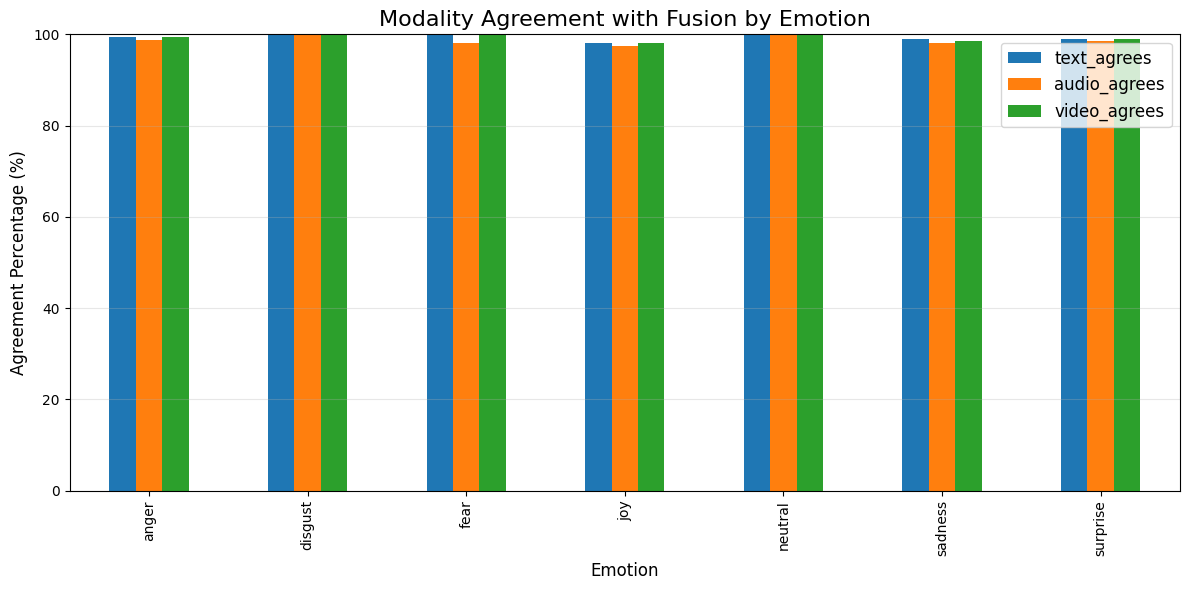


Top 10 most common fusion model misclassifications:
True: joy, Predicted: neutral, Count: 394
True: anger, Predicted: neutral, Count: 343
True: surprise, Predicted: neutral, Count: 278
True: sadness, Predicted: neutral, Count: 206
True: disgust, Predicted: neutral, Count: 68
True: fear, Predicted: neutral, Count: 50
True: surprise, Predicted: joy, Count: 3
True: anger, Predicted: joy, Count: 2
True: sadness, Predicted: joy, Count: 2
True: neutral, Predicted: joy, Count: 1


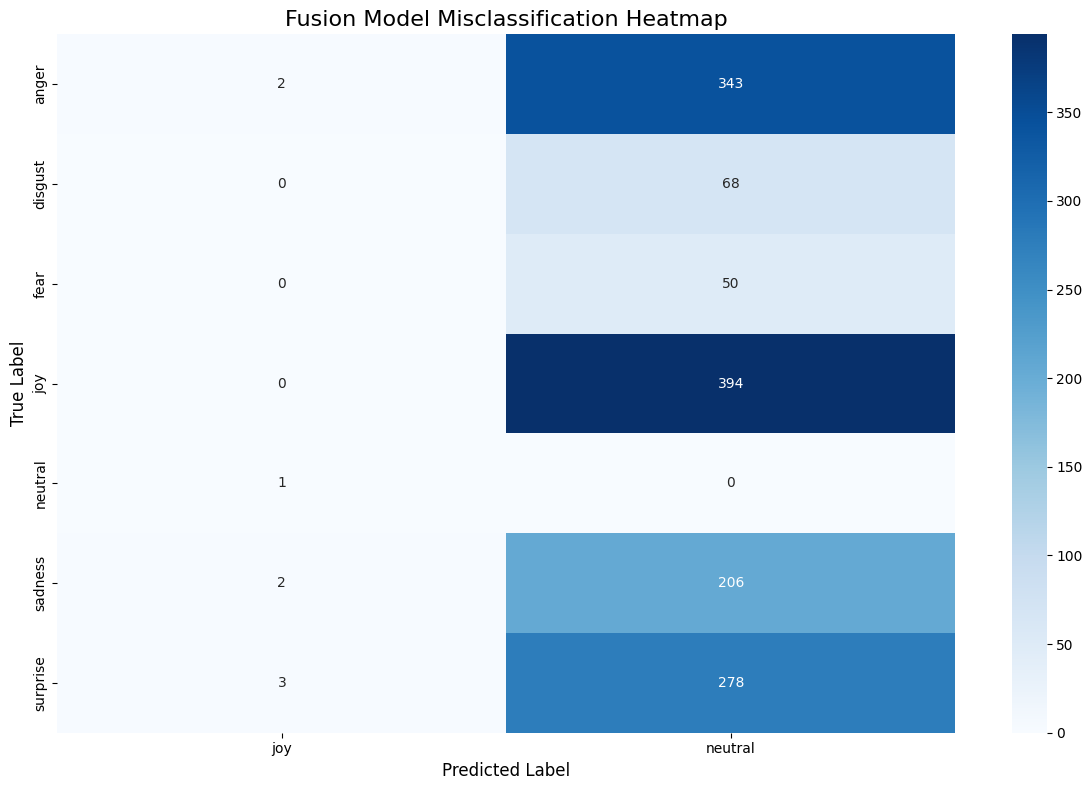

Finding examples:   6%|▌         | 20/327 [00:06<01:33,  3.29it/s]



=== Examples of neutral ===
Example 1:
Utterance: 'Okay. (Goes over and fluffs up the pillows on the couch.'
True emotion: neutral
Fusion prediction: neutral
Text prediction: neutral
Audio prediction: neutral
Video prediction: neutral

Example 2:
Utterance: 'Yeah, come on in. Molly?'
True emotion: neutral
Fusion prediction: neutral
Text prediction: neutral
Audio prediction: neutral
Video prediction: neutral

Example 3:
Utterance: 'A new grocery store.'
True emotion: neutral
Fusion prediction: neutral
Text prediction: neutral
Audio prediction: neutral
Video prediction: neutral


=== Examples of anger ===
Example 1:
Utterance: 'No way!'
True emotion: anger
Fusion prediction: neutral
Text prediction: neutral
Audio prediction: neutral
Video prediction: neutral

Example 2:
Utterance: 'Well, up yours too!'
True emotion: anger
Fusion prediction: neutral
Text prediction: neutral
Audio prediction: neutral
Video prediction: neutral

Example 3:
Utterance: 'Nothing!'
True emotion: anger
Fusion pr

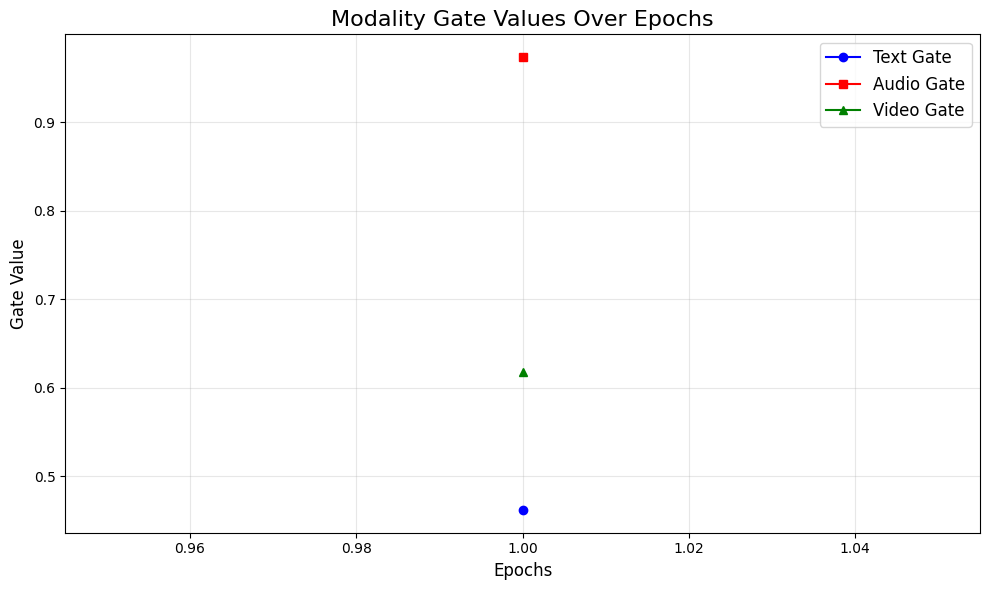


Fusion model accuracy: 0.4839
Text model accuracy: 0.4813 (Fusion improvement: 0.56%)
Audio model accuracy: 0.4839 (Fusion improvement: 0.00%)
Video model accuracy: 0.4813 (Fusion improvement: 0.56%)


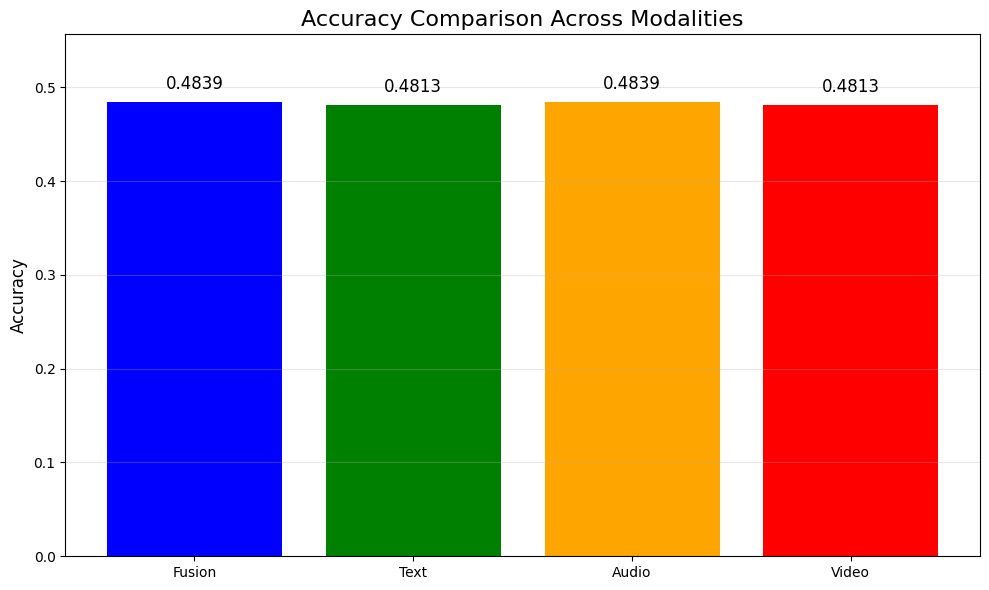

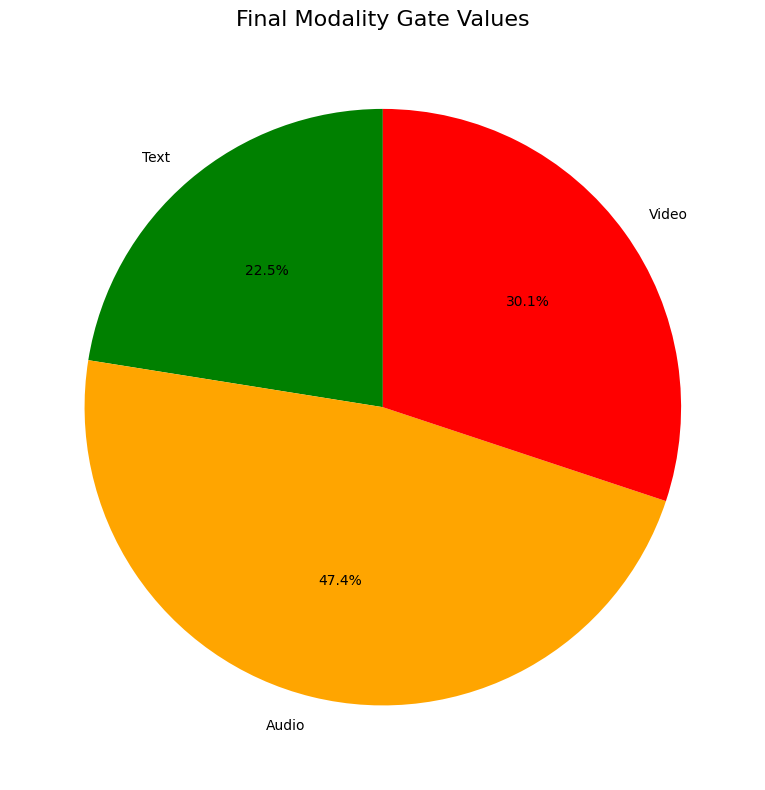

In [17]:
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix, classification_report
from tqdm import tqdm

# Import our model and dataset classes from the main file
# Assuming the previous code is saved as multimodal_emotion_detector.py
# from multimodal_emotion_detector import (
#     MELDMultimodalDataset, MultimodalEmotionDetector, 
#     DATA_PATHS, EMOTION_MAP, REVERSE_EMOTION_MAP, device,
#     plot_confusion_matrix, plot_accuracy_comparison,
#     plot_gate_values, plot_emotion_distribution,
#     plot_per_class_metrics, collate_fn
# )

def analyze_modality_contributions(test_metrics):
    """
    Analyze how each modality contributes to the final predictions
    by comparing predictions from each modality with the fusion model.
    """
    all_labels = test_metrics['all_labels']
    fusion_preds = test_metrics['all_fusion_preds']
    text_preds = test_metrics['all_text_preds']
    audio_preds = test_metrics['all_audio_preds']
    video_preds = test_metrics['all_video_preds']
    
    # Create a DataFrame for analysis
    df = pd.DataFrame({
        'true_label': [REVERSE_EMOTION_MAP[label] for label in all_labels],
        'fusion_pred': [REVERSE_EMOTION_MAP[pred] for pred in fusion_preds],
        'text_pred': [REVERSE_EMOTION_MAP[pred] for pred in text_preds],
        'audio_pred': [REVERSE_EMOTION_MAP[pred] for pred in audio_preds],
        'video_pred': [REVERSE_EMOTION_MAP[pred] for pred in video_preds],
    })
    
    # Calculate agreement between modalities and fusion
    df['text_agrees'] = df['text_pred'] == df['fusion_pred']
    df['audio_agrees'] = df['audio_pred'] == df['fusion_pred']
    df['video_agrees'] = df['video_pred'] == df['fusion_pred']
    
    # Calculate cases where individual modalities are correct but fusion is wrong
    df['text_correct_fusion_wrong'] = (df['text_pred'] == df['true_label']) & (df['fusion_pred'] != df['true_label'])
    df['audio_correct_fusion_wrong'] = (df['audio_pred'] == df['true_label']) & (df['fusion_pred'] != df['true_label'])
    df['video_correct_fusion_wrong'] = (df['video_pred'] == df['true_label']) & (df['fusion_pred'] != df['true_label'])
    
    # Calculate cases where fusion is correct but individual modalities are wrong
    df['fusion_correct_text_wrong'] = (df['fusion_pred'] == df['true_label']) & (df['text_pred'] != df['true_label'])
    df['fusion_correct_audio_wrong'] = (df['fusion_pred'] == df['true_label']) & (df['audio_pred'] != df['true_label'])
    df['fusion_correct_video_wrong'] = (df['fusion_pred'] == df['true_label']) & (df['video_pred'] != df['true_label'])
    
    # Calculate agreement percentages
    text_agreement = df['text_agrees'].mean() * 100
    audio_agreement = df['audio_agrees'].mean() * 100
    video_agreement = df['video_agrees'].mean() * 100
    
    print(f"Agreement with fusion - Text: {text_agreement:.2f}%, Audio: {audio_agreement:.2f}%, Video: {video_agreement:.2f}%")
    
    # Calculate cases where modalities are correct but fusion is wrong
    text_correct_fusion_wrong = df['text_correct_fusion_wrong'].mean() * 100
    audio_correct_fusion_wrong = df['audio_correct_fusion_wrong'].mean() * 100
    video_correct_fusion_wrong = df['video_correct_fusion_wrong'].mean() * 100
    
    print(f"Modality correct but fusion wrong - Text: {text_correct_fusion_wrong:.2f}%, Audio: {audio_correct_fusion_wrong:.2f}%, Video: {video_correct_fusion_wrong:.2f}%")
    
    # Calculate cases where fusion is correct but modalities are wrong
    fusion_correct_text_wrong = df['fusion_correct_text_wrong'].mean() * 100
    fusion_correct_audio_wrong = df['fusion_correct_audio_wrong'].mean() * 100
    fusion_correct_video_wrong = df['fusion_correct_video_wrong'].mean() * 100
    
    print(f"Fusion correct but modality wrong - Text: {fusion_correct_text_wrong:.2f}%, Audio: {fusion_correct_audio_wrong:.2f}%, Video: {fusion_correct_video_wrong:.2f}%")
    
    # Analyze agreement by emotion
    agreement_by_emotion = df.groupby('true_label')[['text_agrees', 'audio_agrees', 'video_agrees']].mean() * 100
    print("\nAgreement by emotion:")
    print(agreement_by_emotion)
    
    # Visualize agreement by emotion
    plt.figure(figsize=(12, 6))
    agreement_by_emotion.plot(kind='bar', figsize=(12, 6))
    plt.title('Modality Agreement with Fusion by Emotion', fontsize=16)
    plt.ylabel('Agreement Percentage (%)', fontsize=12)
    plt.xlabel('Emotion', fontsize=12)
    plt.ylim(0, 100)
    plt.grid(axis='y', alpha=0.3)
    plt.legend(fontsize=12)
    plt.tight_layout()
    plt.show()
    
    return df

def analyze_misclassifications(test_metrics):
    """
    Analyze the most common misclassifications for each model
    """
    all_labels = test_metrics['all_labels']
    fusion_preds = test_metrics['all_fusion_preds']
    text_preds = test_metrics['all_text_preds']
    audio_preds = test_metrics['all_audio_preds']
    video_preds = test_metrics['all_video_preds']
    
    # Create a DataFrame for misclassifications
    df = pd.DataFrame({
        'true_label': [REVERSE_EMOTION_MAP[label] for label in all_labels],
        'fusion_pred': [REVERSE_EMOTION_MAP[pred] for pred in fusion_preds],
        'text_pred': [REVERSE_EMOTION_MAP[pred] for pred in text_preds],
        'audio_pred': [REVERSE_EMOTION_MAP[pred] for pred in audio_preds],
        'video_pred': [REVERSE_EMOTION_MAP[pred] for pred in video_preds],
    })
    
    # Filter to only include misclassifications
    fusion_misclass = df[df['true_label'] != df['fusion_pred']]
    
    # Get the most common misclassifications
    fusion_confusion = fusion_misclass.groupby(['true_label', 'fusion_pred']).size().reset_index(name='count')
    fusion_confusion = fusion_confusion.sort_values('count', ascending=False).head(10)
    
    print("\nTop 10 most common fusion model misclassifications:")
    for _, row in fusion_confusion.iterrows():
        print(f"True: {row['true_label']}, Predicted: {row['fusion_pred']}, Count: {row['count']}")
    
    # Create a heatmap of misclassifications
    plt.figure(figsize=(12, 8))
    misclass_matrix = pd.crosstab(
        fusion_misclass['true_label'], 
        fusion_misclass['fusion_pred'], 
        values=fusion_misclass['true_label'].map(lambda x: 1), 
        aggfunc='count'
    ).fillna(0)
    
    sns.heatmap(misclass_matrix, annot=True, fmt='g', cmap='Blues')
    plt.title('Fusion Model Misclassification Heatmap', fontsize=16)
    plt.ylabel('True Label', fontsize=12)
    plt.xlabel('Predicted Label', fontsize=12)
    plt.tight_layout()
    plt.show()
    
    return fusion_misclass

def visualize_emotion_examples(model, dataloader, device, num_examples=5):
    """
    Visualize examples of each emotion with model predictions from different modalities
    """
    model.eval()
    examples_by_emotion = {emotion: [] for emotion in EMOTION_MAP}
    count_by_emotion = {emotion: 0 for emotion in EMOTION_MAP}
    
    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Finding examples"):
            # Move inputs to device
            text_input_ids = batch['text_input_ids'].to(device)
            text_attention_mask = batch['text_attention_mask'].to(device)
            audio = batch['audio'].to(device)
            face = batch['face'].to(device)
            labels = batch['emotion'].to(device)
            utterances = batch['utterance']
            
            # Forward pass
            outputs = model(text_input_ids, text_attention_mask, audio, face)
            
            # Get predictions
            fusion_preds = torch.argmax(outputs['logits'], dim=1)
            text_preds = torch.argmax(outputs['text_logits'], dim=1)
            audio_preds = torch.argmax(outputs['audio_logits'], dim=1)
            video_preds = torch.argmax(outputs['video_logits'], dim=1)
            
            # Convert to numpy
            fusion_preds = fusion_preds.cpu().numpy()
            text_preds = text_preds.cpu().numpy()
            audio_preds = audio_preds.cpu().numpy()
            video_preds = video_preds.cpu().numpy()
            labels = labels.cpu().numpy()
            
            # Save examples of each emotion
            for i in range(len(labels)):
                true_emotion = REVERSE_EMOTION_MAP[labels[i]]
                if count_by_emotion[true_emotion] < num_examples:
                    examples_by_emotion[true_emotion].append({
                        'utterance': utterances[i],
                        'true_emotion': true_emotion,
                        'fusion_pred': REVERSE_EMOTION_MAP[fusion_preds[i]],
                        'text_pred': REVERSE_EMOTION_MAP[text_preds[i]],
                        'audio_pred': REVERSE_EMOTION_MAP[audio_preds[i]],
                        'video_pred': REVERSE_EMOTION_MAP[video_preds[i]]
                    })
                    count_by_emotion[true_emotion] += 1
            
            # Check if we have enough examples of each emotion
            if all(count >= num_examples for count in count_by_emotion.values()):
                break
    
    # Print examples
    for emotion, examples in examples_by_emotion.items():
        print(f"\n=== Examples of {emotion} ===")
        for i, example in enumerate(examples):
            print(f"Example {i+1}:")
            print(f"Utterance: '{example['utterance']}'")
            print(f"True emotion: {example['true_emotion']}")
            print(f"Fusion prediction: {example['fusion_pred']}")
            print(f"Text prediction: {example['text_pred']}")
            print(f"Audio prediction: {example['audio_pred']}")
            print(f"Video prediction: {example['video_pred']}")
            print()

def visualize_modality_importance(test_metrics, history):
    """
    Visualize the importance of each modality based on gate values and performance
    """
    # Plot gate values over epochs
    plot_gate_values(history)
    
    # Calculate accuracy per modality
    fusion_acc = test_metrics['fusion_acc']
    text_acc = test_metrics['text_acc']
    audio_acc = test_metrics['audio_acc']
    video_acc = test_metrics['video_acc']
    
    # Calculate relative improvement of fusion over individual modalities
    improvement_over_text = (fusion_acc - text_acc) / text_acc * 100
    improvement_over_audio = (fusion_acc - audio_acc) / audio_acc * 100
    improvement_over_video = (fusion_acc - video_acc) / video_acc * 100
    
    print(f"\nFusion model accuracy: {fusion_acc:.4f}")
    print(f"Text model accuracy: {text_acc:.4f} (Fusion improvement: {improvement_over_text:.2f}%)")
    print(f"Audio model accuracy: {audio_acc:.4f} (Fusion improvement: {improvement_over_audio:.2f}%)")
    print(f"Video model accuracy: {video_acc:.4f} (Fusion improvement: {improvement_over_video:.2f}%)")
    
    # Plot accuracy comparison
    modalities = ['Fusion', 'Text', 'Audio', 'Video']
    accuracies = [fusion_acc, text_acc, audio_acc, video_acc]
    
    plt.figure(figsize=(10, 6))
    bars = plt.bar(modalities, accuracies, color=['blue', 'green', 'orange', 'red'])
    
    # Add accuracy values on top of bars
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                 f'{height:.4f}', ha='center', va='bottom', fontsize=12)
    
    plt.title('Accuracy Comparison Across Modalities', fontsize=16)
    plt.ylabel('Accuracy', fontsize=12)
    plt.ylim(0, max(accuracies) * 1.15)  # Add some space for the text
    plt.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    # Get gate values from the last epoch
    gate_text = history['gate_text'][-1]
    gate_audio = history['gate_audio'][-1]
    gate_video = history['gate_video'][-1]
    
    # Plot gate values as a pie chart
    plt.figure(figsize=(8, 8))
    plt.pie([gate_text, gate_audio, gate_video], 
            labels=['Text', 'Audio', 'Video'],
            autopct='%1.1f%%',
            startangle=90,
            colors=['green', 'orange', 'red'])
    plt.title('Final Modality Gate Values', fontsize=16)
    plt.tight_layout()
    plt.show()

# Example usage
if __name__ == "__main__":
    # Load the saved model or a newly trained model
    try:
        # Try to load a saved model
        model_path = "multimodal_emotion_model.pt"
        checkpoint = torch.load(model_path)
        model = MultimodalEmotionDetector(embedding_dim=256, num_classes=len(EMOTION_MAP))
        model.load_state_dict(checkpoint['model_state_dict'])
        model = model.to(device)
        history = checkpoint['history']
        test_metrics = checkpoint['test_metrics']
        print(f"Loaded saved model from {model_path}")
    except:
        print("No saved model found. Training a new model...")
        # Import the main function to train a new model
        from multimodal_emotion_detector import main
        model, history, test_metrics = main()
        
        # Save the model
        torch.save({
            'model_state_dict': model.state_dict(),
            'history': history,
            'test_metrics': test_metrics
        }, "multimodal_emotion_model.pt")
        print("Model saved to multimodal_emotion_model.pt")
    
    # Create a test dataloader
    test_dataset = MELDMultimodalDataset(DATA_PATHS['test'], split='test')
    test_dataloader = torch.utils.data.DataLoader(
        test_dataset,
        batch_size=8,
        shuffle=False,
        collate_fn=collate_fn,
        num_workers=2
    )
    
    # Analyze contributions of each modality
    modality_contributions_df = analyze_modality_contributions(test_metrics)
    
    # Analyze misclassifications
    misclassifications_df = analyze_misclassifications(test_metrics)
    
    # Visualize examples of each emotion
    visualize_emotion_examples(model, test_dataloader, device, num_examples=3)
    
    # Visualize modality importance
    visualize_modality_importance(test_metrics, history)

Loaded 2610 samples for test set


Finding interesting samples:  93%|█████████▎| 607/653 [01:36<00:07,  6.27it/s]

Processing sample from batch 76, index 1...



Utterance: 'Push 'em out, push 'em out, harder, harder.'
True Emotion: joy
Fusion Prediction: neutral
Text Prediction: neutral
Audio Prediction: joy
Video Prediction: neutral
Gate Values - Text: 0.1018, Audio: 0.9842, Video: 0.6933


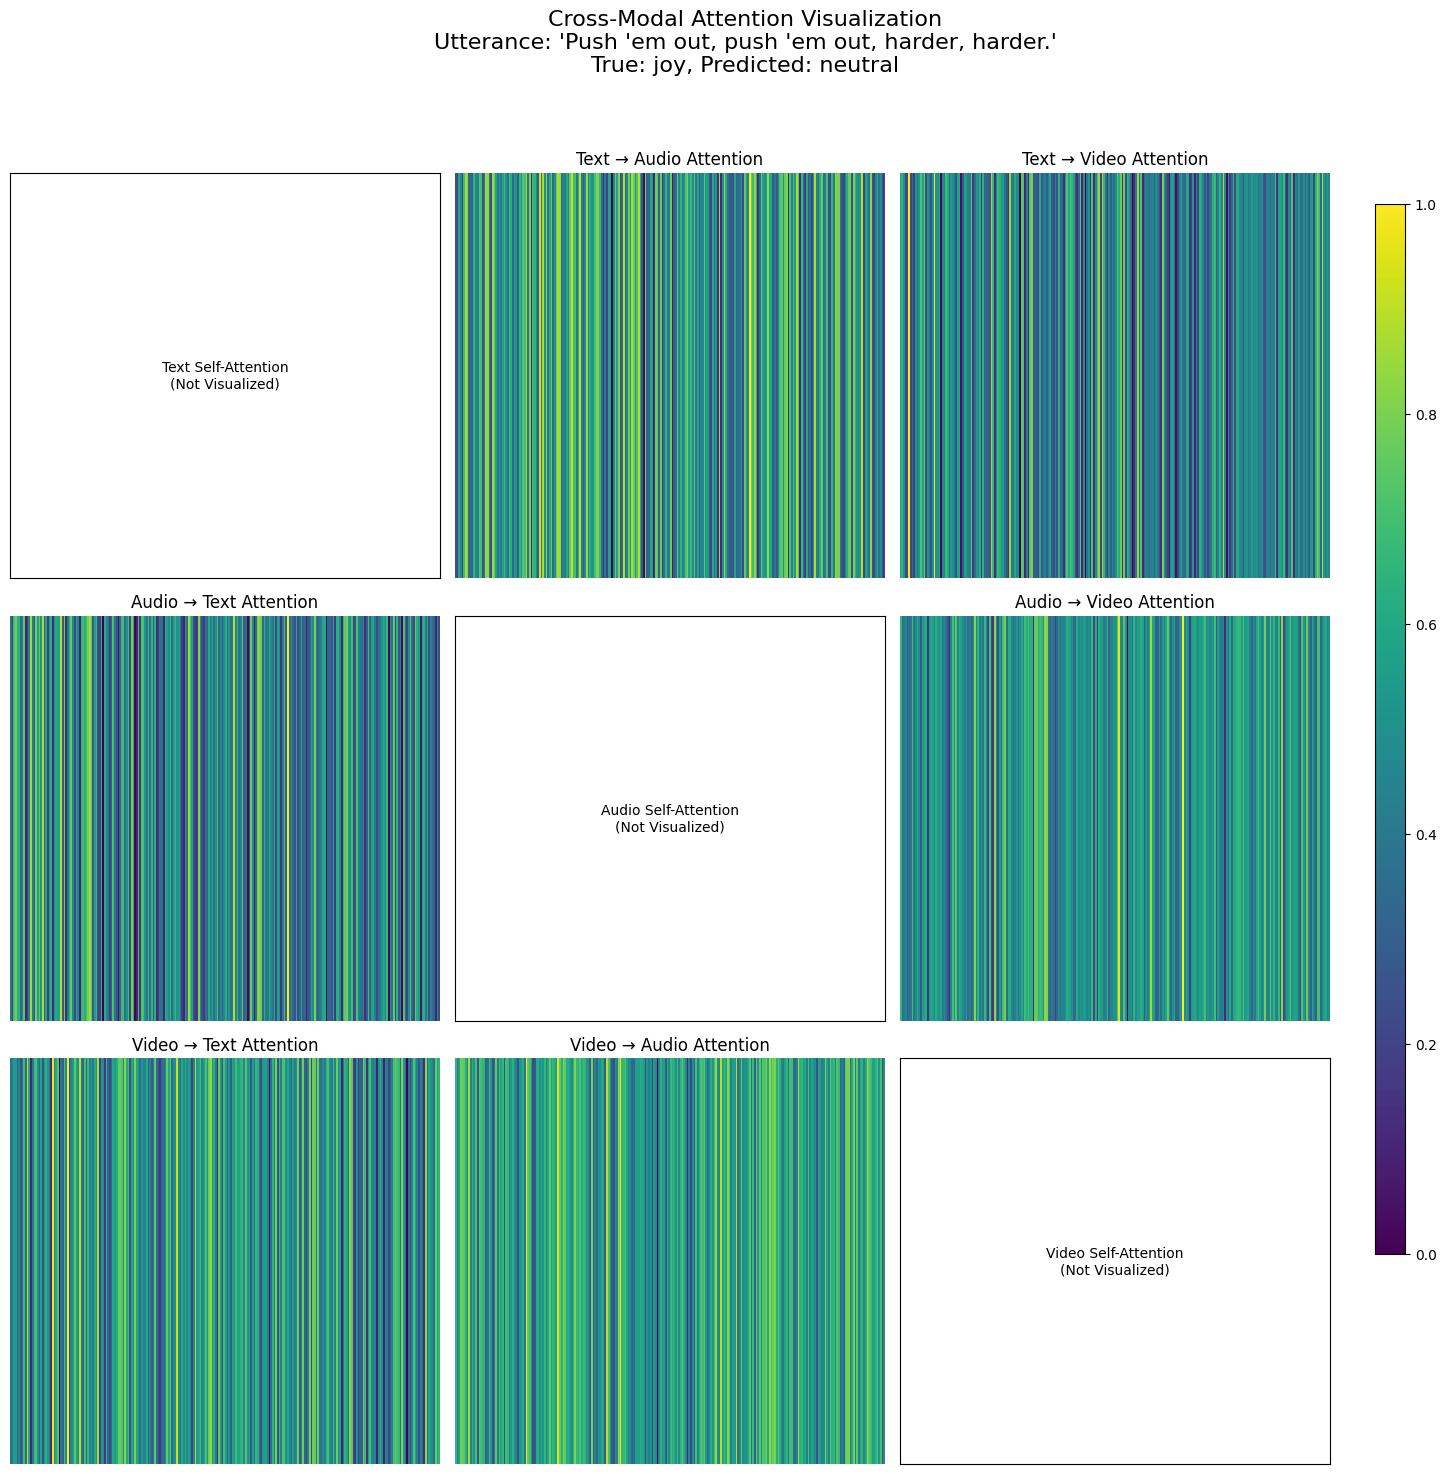

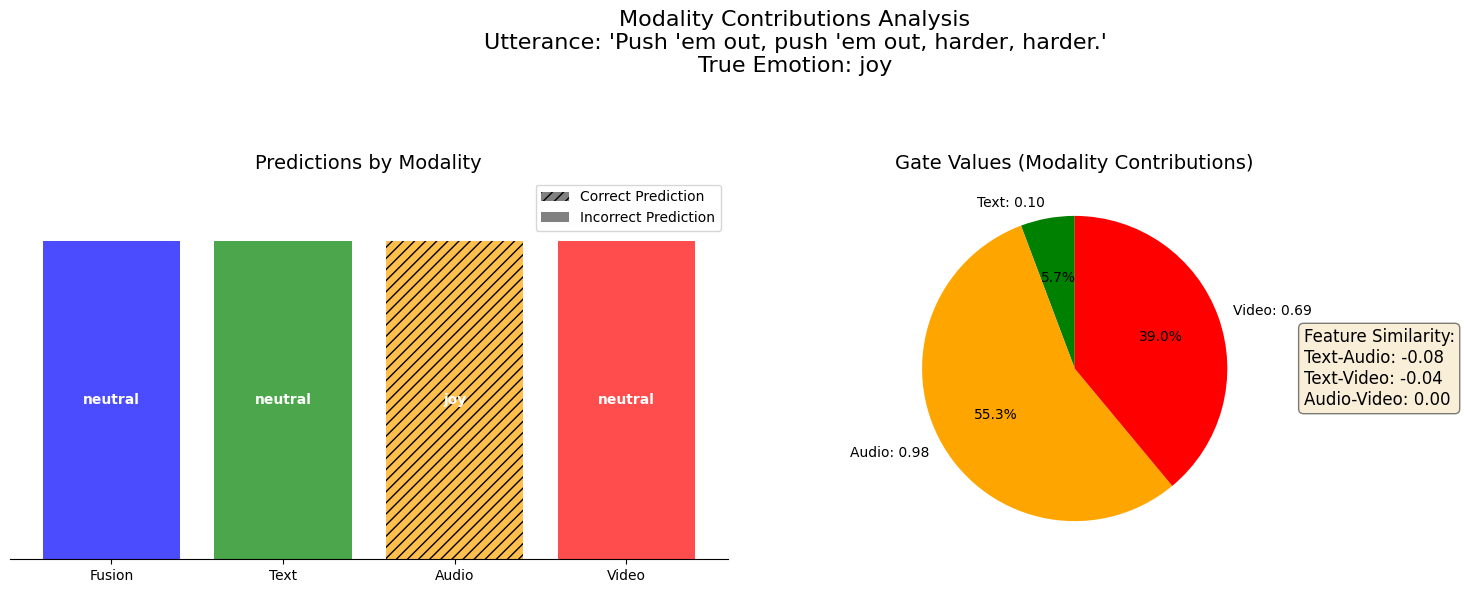



Processing sample from batch 0, index 0...

Utterance: 'Okay. (Goes over and fluffs up the pillows on the couch.'
True Emotion: neutral
Fusion Prediction: neutral
Text Prediction: neutral
Audio Prediction: neutral
Video Prediction: neutral
Gate Values - Text: 0.2050, Audio: 0.9807, Video: 0.7483


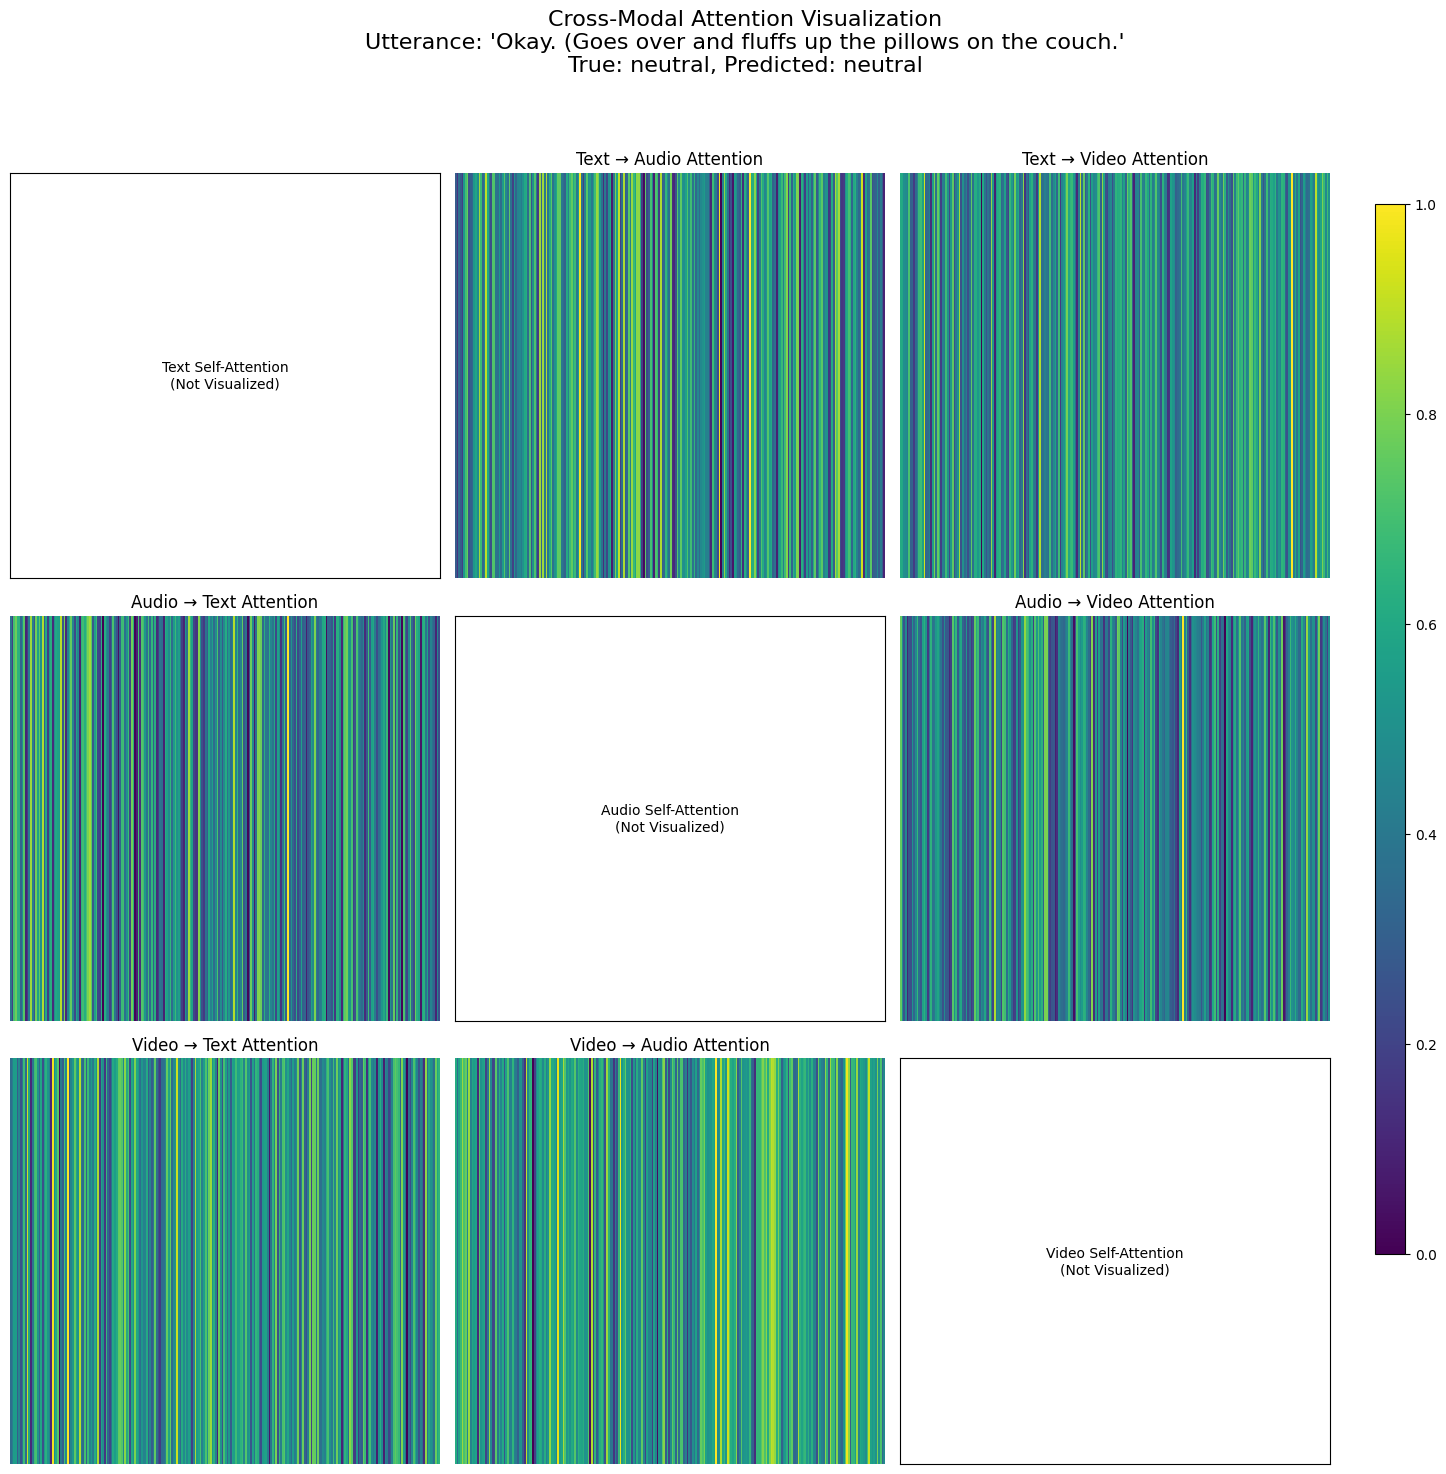

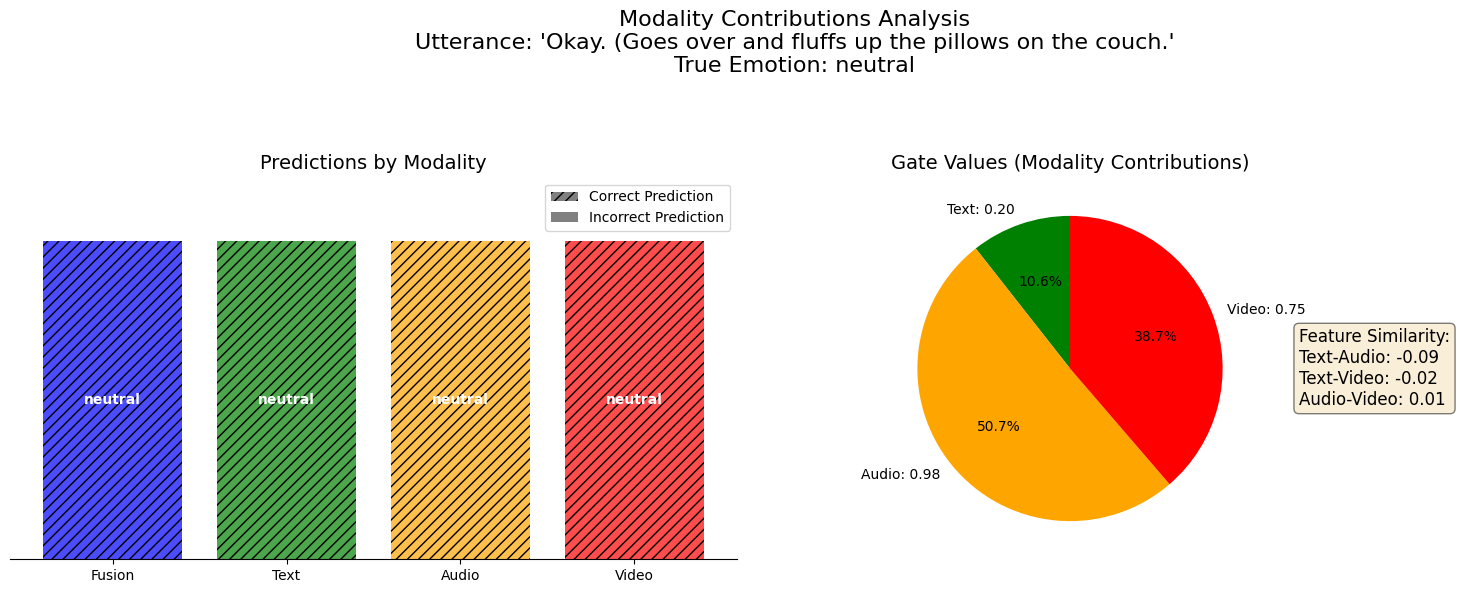



Processing sample from batch 0, index 2...

Utterance: 'No way!'
True Emotion: anger
Fusion Prediction: neutral
Text Prediction: neutral
Audio Prediction: neutral
Video Prediction: neutral
Gate Values - Text: 0.2201, Audio: 0.9795, Video: 0.7791


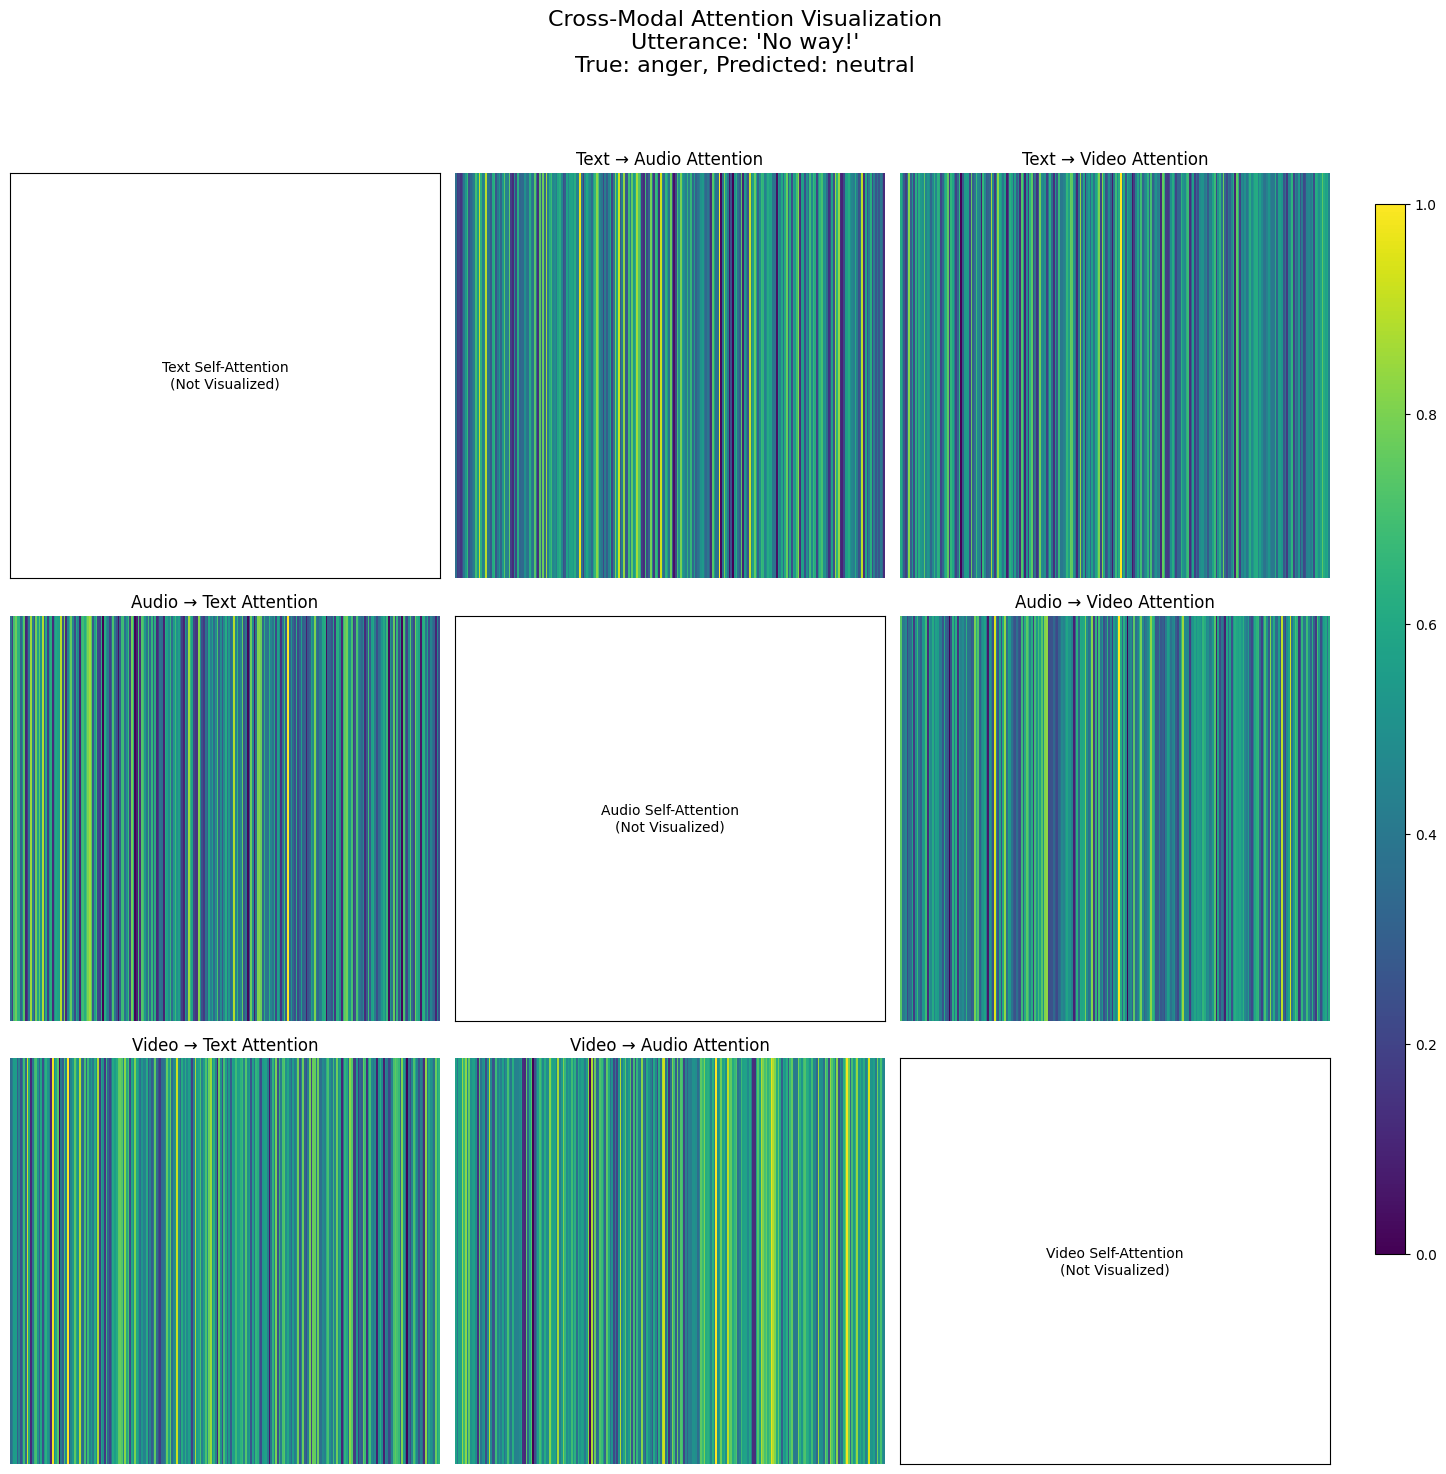

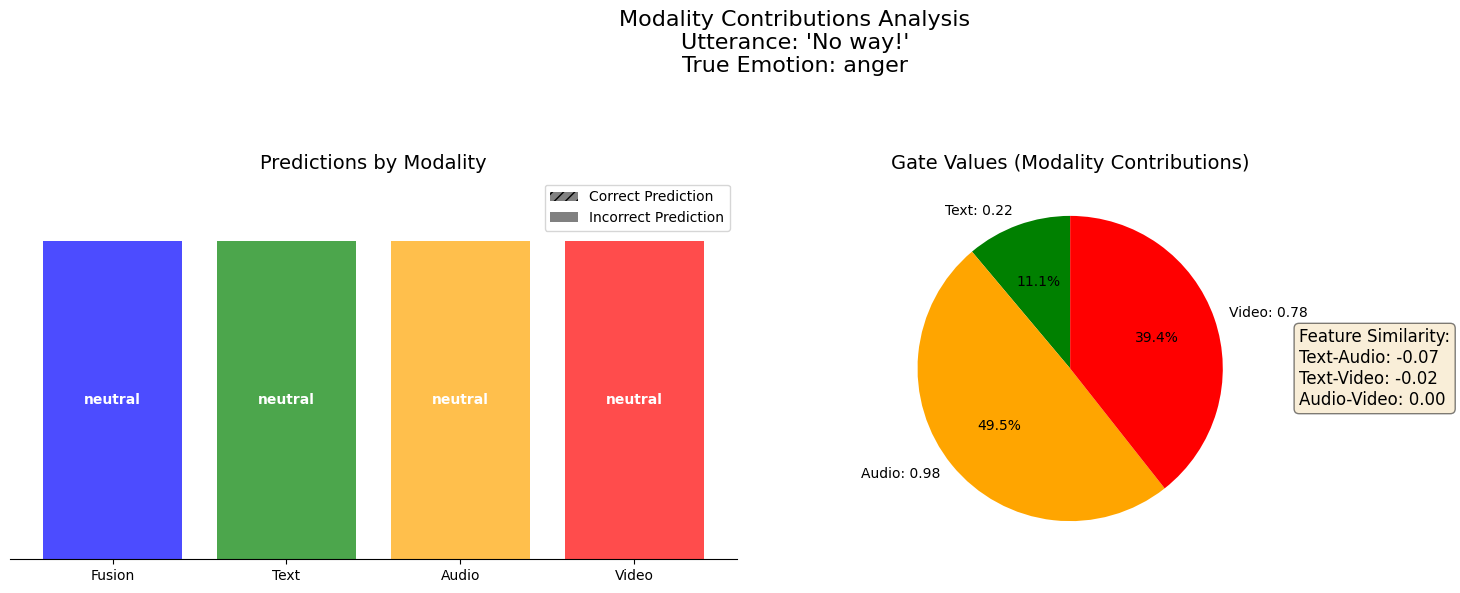

In [19]:
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.cm as cm

# Import our model and dataset classes from the main file
# from multimodal_emotion_detector import (
#     MELDMultimodalDataset, MultimodalEmotionDetector, 
#     DATA_PATHS, EMOTION_MAP, REVERSE_EMOTION_MAP, device,
#     collate_fn
# )

class AttentionVisualizer:
    """
    Class for visualizing attention in the multimodal model
    """
    def __init__(self, model, dataloader, device):
        self.model = model
        self.dataloader = dataloader
        self.device = device
        
        # Set model to evaluation mode
        self.model.eval()
        
    def extract_sample_with_attention(self, batch_idx=0, sample_idx=0):
        """
        Extract a single sample with attention weights
        
        Args:
            batch_idx (int): Index of the batch to use
            sample_idx (int): Index of the sample within the batch
            
        Returns:
            dict: Dictionary containing sample data and attention weights
        """
        # Get a batch
        for i, batch in enumerate(self.dataloader):
            if i == batch_idx:
                break
        
        # Extract a single sample
        text_input_ids = batch['text_input_ids'][sample_idx:sample_idx+1].to(self.device)
        text_attention_mask = batch['text_attention_mask'][sample_idx:sample_idx+1].to(self.device)
        audio = batch['audio'][sample_idx:sample_idx+1].to(self.device)
        face = batch['face'][sample_idx:sample_idx+1].to(self.device)
        emotion = batch['emotion'][sample_idx:sample_idx+1].to(self.device)
        utterance = batch['utterance'][sample_idx]
        
        # Register hooks to get attention weights
        text_cross_attn_weights = []
        audio_cross_attn_weights = []
        video_cross_attn_weights = []
        
        def get_text_to_audio_attn(module, input, output):
            text_cross_attn_weights.append(output.detach().cpu())
            
        def get_text_to_video_attn(module, input, output):
            text_cross_attn_weights.append(output.detach().cpu())
            
        def get_audio_to_text_attn(module, input, output):
            audio_cross_attn_weights.append(output.detach().cpu())
            
        def get_audio_to_video_attn(module, input, output):
            audio_cross_attn_weights.append(output.detach().cpu())
            
        def get_video_to_text_attn(module, input, output):
            video_cross_attn_weights.append(output.detach().cpu())
            
        def get_video_to_audio_attn(module, input, output):
            video_cross_attn_weights.append(output.detach().cpu())
        
        # Register hooks
        hook1 = self.model.fusion.text_to_audio.register_forward_hook(get_text_to_audio_attn)
        hook2 = self.model.fusion.text_to_video.register_forward_hook(get_text_to_video_attn)
        hook3 = self.model.fusion.audio_to_text.register_forward_hook(get_audio_to_text_attn)
        hook4 = self.model.fusion.audio_to_video.register_forward_hook(get_audio_to_video_attn)
        hook5 = self.model.fusion.video_to_text.register_forward_hook(get_video_to_text_attn)
        hook6 = self.model.fusion.video_to_audio.register_forward_hook(get_video_to_audio_attn)
        
        # Forward pass
        with torch.no_grad():
            outputs = self.model(text_input_ids, text_attention_mask, audio, face)
        
        # Remove hooks
        hook1.remove()
        hook2.remove()
        hook3.remove()
        hook4.remove()
        hook5.remove()
        hook6.remove()
        
        # Get predictions
        fusion_pred = outputs['logits'].argmax(dim=1).item()
        text_pred = outputs['text_logits'].argmax(dim=1).item()
        audio_pred = outputs['audio_logits'].argmax(dim=1).item()
        video_pred = outputs['video_logits'].argmax(dim=1).item()
        true_emotion = emotion.item()
        
        # Extract features for each modality
        text_features = self.model.text_encoder(text_input_ids, text_attention_mask).detach().cpu()
        audio_features = self.model.audio_encoder(audio).detach().cpu()
        video_features = self.model.video_encoder(face).detach().cpu()
        
        return {
            'utterance': utterance,
            'true_emotion': REVERSE_EMOTION_MAP[true_emotion],
            'fusion_pred': REVERSE_EMOTION_MAP[fusion_pred],
            'text_pred': REVERSE_EMOTION_MAP[text_pred],
            'audio_pred': REVERSE_EMOTION_MAP[audio_pred],
            'video_pred': REVERSE_EMOTION_MAP[video_pred],
            'text_features': text_features,
            'audio_features': audio_features,
            'video_features': video_features,
            'text_cross_attn': text_cross_attn_weights,
            'audio_cross_attn': audio_cross_attn_weights,
            'video_cross_attn': video_cross_attn_weights,
            'gate_values': outputs['gate_values'],
        }
    
    def visualize_cross_modal_attention(self, sample_data):
        """
        Visualize cross-modal attention weights
        
        Args:
            sample_data (dict): Sample data containing attention weights
        """
        # Create a 3x3 grid for cross-modal attention
        fig, axes = plt.subplots(3, 3, figsize=(15, 15))
        
        # Define modality names
        modalities = ['Text', 'Audio', 'Video']
        
        # Plot attention heatmaps
        for i, source_mod in enumerate(modalities):
            for j, target_mod in enumerate(modalities):
                if i == j:
                    # Diagonal - display self-attention placeholder
                    axes[i, j].text(0.5, 0.5, f"{source_mod} Self-Attention\n(Not Visualized)", 
                                  horizontalalignment='center', verticalalignment='center')
                    axes[i, j].set_xticks([])
                    axes[i, j].set_yticks([])
                else:
                    # Off-diagonal - display cross-attention
                    # Get the appropriate attention weights
                    if source_mod == 'Text':
                        if target_mod == 'Audio':
                            attn_weights = sample_data['text_cross_attn'][0].numpy()
                        else:  # target_mod == 'Video'
                            attn_weights = sample_data['text_cross_attn'][1].numpy()
                    elif source_mod == 'Audio':
                        if target_mod == 'Text':
                            attn_weights = sample_data['audio_cross_attn'][0].numpy()
                        else:  # target_mod == 'Video'
                            attn_weights = sample_data['audio_cross_attn'][1].numpy()
                    else:  # source_mod == 'Video'
                        if target_mod == 'Text':
                            attn_weights = sample_data['video_cross_attn'][0].numpy()
                        else:  # target_mod == 'Audio'
                            attn_weights = sample_data['video_cross_attn'][1].numpy()
                    
                    # Reshape to 2D for heatmap if needed
                    if len(attn_weights.shape) > 2:
                        attn_weights = attn_weights.reshape(attn_weights.shape[-2:])
                    
                    # Plot heatmap
                    sns.heatmap(attn_weights, ax=axes[i, j], cmap='viridis', cbar=False)
                    axes[i, j].set_title(f"{source_mod} → {target_mod} Attention")
                    axes[i, j].set_xticks([])
                    axes[i, j].set_yticks([])
        
        # Add colorbar
        cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
        sm = plt.cm.ScalarMappable(cmap='viridis')
        sm.set_array([])
        fig.colorbar(sm, cax=cbar_ax)
        
        # Add sample information
        plt.suptitle(f"Cross-Modal Attention Visualization\nUtterance: '{sample_data['utterance']}'\n" + 
                   f"True: {sample_data['true_emotion']}, Predicted: {sample_data['fusion_pred']}", 
                   fontsize=16, y=0.98)
        
        plt.tight_layout(rect=[0, 0, 0.9, 0.95])
        plt.show()
    
    def visualize_modality_contributions(self, sample_data):
        """
        Visualize the contributions of each modality to the final prediction
        
        Args:
            sample_data (dict): Sample data containing predictions and gate values
        """
        # Extract predictions and gate values
        true_emotion = sample_data['true_emotion']
        fusion_pred = sample_data['fusion_pred']
        text_pred = sample_data['text_pred']
        audio_pred = sample_data['audio_pred']
        video_pred = sample_data['video_pred']
        
        gate_text = sample_data['gate_values']['gate_text']
        gate_audio = sample_data['gate_values']['gate_audio']
        gate_video = sample_data['gate_values']['gate_video']
        
        # Calculate feature similarity between modalities
        text_features = sample_data['text_features'].numpy()
        audio_features = sample_data['audio_features'].numpy()
        video_features = sample_data['video_features'].numpy()
        
        text_audio_sim = np.corrcoef(text_features.flatten(), audio_features.flatten())[0, 1]
        text_video_sim = np.corrcoef(text_features.flatten(), video_features.flatten())[0, 1]
        audio_video_sim = np.corrcoef(audio_features.flatten(), video_features.flatten())[0, 1]
        
        # Create figure with subplots
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
        
        # Plot predictions
        predictions = [fusion_pred, text_pred, audio_pred, video_pred]
        models = ['Fusion', 'Text', 'Audio', 'Video']
        colors = ['blue', 'green', 'orange', 'red']
        correct_predictions = [pred == true_emotion for pred in predictions]
        
        # Add hatching to correct predictions
        bars = ax1.bar(models, [1] * 4, color=colors, alpha=0.7)
        for i, (bar, correct) in enumerate(zip(bars, correct_predictions)):
            if correct:
                bar.set_hatch('///')
        
        # Add labels inside bars
        for i, bar in enumerate(bars):
            height = bar.get_height()
            ax1.text(bar.get_x() + bar.get_width()/2., height/2,
                   predictions[i], ha='center', va='center', color='white', fontweight='bold')
        
        ax1.set_title('Predictions by Modality', fontsize=14)
        ax1.set_ylim(0, 1.2)
        ax1.set_yticks([])
        ax1.spines['top'].set_visible(False)
        ax1.spines['right'].set_visible(False)
        ax1.spines['left'].set_visible(False)
        
        # Add legend for correct predictions
        from matplotlib.patches import Patch
        legend_elements = [
            Patch(facecolor='gray', hatch='///', label='Correct Prediction'),
            Patch(facecolor='gray', label='Incorrect Prediction')
        ]
        ax1.legend(handles=legend_elements, loc='upper right')
        
        # Plot gate values as a pie chart
        gate_values = [gate_text, gate_audio, gate_video]
        labels = [f'Text: {gate_text:.2f}', f'Audio: {gate_audio:.2f}', f'Video: {gate_video:.2f}']
        ax2.pie(gate_values, labels=labels, autopct='%1.1f%%', startangle=90, colors=colors[1:])
        ax2.set_title('Gate Values (Modality Contributions)', fontsize=14)
        
        # Add feature similarity information
        textstr = '\n'.join([
            f'Feature Similarity:',
            f'Text-Audio: {text_audio_sim:.2f}',
            f'Text-Video: {text_video_sim:.2f}',
            f'Audio-Video: {audio_video_sim:.2f}'
        ])
        props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
        ax2.text(1.1, 0.5, textstr, transform=ax2.transAxes, fontsize=12,
                verticalalignment='center', bbox=props)
        
        # Add sample information
        plt.suptitle(f"Modality Contributions Analysis\nUtterance: '{sample_data['utterance']}'\n" + 
                   f"True Emotion: {true_emotion}", fontsize=16)
        
        plt.tight_layout(rect=[0, 0, 1, 0.9])
        plt.show()
    
    def find_interesting_samples(self, num_samples=5):
        """
        Find interesting samples for visualization:
        - Samples where the fusion model is correct but individual modalities are wrong
        - Samples with high disagreement between modalities
        - Samples with diverse emotions
        
        Args:
            num_samples (int): Number of interesting samples to find
            
        Returns:
            list: List of tuples (batch_idx, sample_idx) for interesting samples
        """
        interesting_samples = []
        emotion_counts = {emotion: 0 for emotion in EMOTION_MAP}
        max_per_emotion = max(1, num_samples // len(EMOTION_MAP))
        
        seen_pattern = set()  # Track the correctness pattern we've seen
        
        for batch_idx, batch in enumerate(tqdm(self.dataloader, desc="Finding interesting samples")):
            # Move inputs to device
            text_input_ids = batch['text_input_ids'].to(self.device)
            text_attention_mask = batch['text_attention_mask'].to(self.device)
            audio = batch['audio'].to(self.device)
            face = batch['face'].to(self.device)
            emotions = batch['emotion'].to(self.device)
            
            # Forward pass
            with torch.no_grad():
                outputs = self.model(text_input_ids, text_attention_mask, audio, face)
            
            # Get predictions
            fusion_preds = outputs['logits'].argmax(dim=1).cpu().numpy()
            text_preds = outputs['text_logits'].argmax(dim=1).cpu().numpy()
            audio_preds = outputs['audio_logits'].argmax(dim=1).cpu().numpy()
            video_preds = outputs['video_logits'].argmax(dim=1).cpu().numpy()
            true_emotions = emotions.cpu().numpy()
            
            # Check each sample in the batch
            for sample_idx in range(len(true_emotions)):
                true_emotion = true_emotions[sample_idx]
                fusion_correct = fusion_preds[sample_idx] == true_emotion
                text_correct = text_preds[sample_idx] == true_emotion
                audio_correct = audio_preds[sample_idx] == true_emotion
                video_correct = video_preds[sample_idx] == true_emotion
                
                # Calculate modality agreement
                preds = [fusion_preds[sample_idx], text_preds[sample_idx], audio_preds[sample_idx], video_preds[sample_idx]]
                unique_preds = len(set(preds))
                
                # Calculate a score for interestingness
                # Higher score means more interesting
                score = 0
                
                # Interesting cases:
                # 1. Fusion is correct but some modalities are wrong
                if fusion_correct and not (text_correct and audio_correct and video_correct):
                    score += 3
                
                # 2. High disagreement between modalities
                score += unique_preds - 1
                
                # 3. Rare or underrepresented emotions
                emotion_name = REVERSE_EMOTION_MAP[true_emotion]
                if emotion_counts[emotion_name] < max_per_emotion:
                    score += 2
                
                # Track correctness pattern
                pattern = (fusion_correct, text_correct, audio_correct, video_correct)
                if pattern not in seen_pattern:
                    score += 2
                    seen_pattern.add(pattern)
                
                # If score is high enough and we haven't seen too many of this emotion
                if score >= 3 and emotion_counts[emotion_name] < max_per_emotion:
                    interesting_samples.append((batch_idx, sample_idx, score, emotion_name))
                    emotion_counts[emotion_name] += 1
                
                # If we have enough samples, stop
                if len(interesting_samples) >= num_samples * 2:  # Get more than needed to choose from
                    break
            
            # If we have enough samples, stop
            if len(interesting_samples) >= num_samples * 2:
                break
        
        # Sort by score (highest first) and take top num_samples
        interesting_samples.sort(key=lambda x: x[2], reverse=True)
        return [(batch_idx, sample_idx) for batch_idx, sample_idx, _, _ in interesting_samples[:num_samples]]
    
    def visualize_interesting_samples(self, num_samples=5):
        """
        Find and visualize interesting samples
        
        Args:
            num_samples (int): Number of interesting samples to visualize
        """
        interesting_samples = self.find_interesting_samples(num_samples)
        
        for batch_idx, sample_idx in interesting_samples:
            print(f"Processing sample from batch {batch_idx}, index {sample_idx}...")
            sample_data = self.extract_sample_with_attention(batch_idx, sample_idx)
            
            print(f"\nUtterance: '{sample_data['utterance']}'")
            print(f"True Emotion: {sample_data['true_emotion']}")
            print(f"Fusion Prediction: {sample_data['fusion_pred']}")
            print(f"Text Prediction: {sample_data['text_pred']}")
            print(f"Audio Prediction: {sample_data['audio_pred']}")
            print(f"Video Prediction: {sample_data['video_pred']}")
            print(f"Gate Values - Text: {sample_data['gate_values']['gate_text']:.4f}, " +
                 f"Audio: {sample_data['gate_values']['gate_audio']:.4f}, " +
                 f"Video: {sample_data['gate_values']['gate_video']:.4f}")
            
            # Visualize cross-modal attention
            self.visualize_cross_modal_attention(sample_data)
            
            # Visualize modality contributions
            self.visualize_modality_contributions(sample_data)
            
            print("\n" + "="*50 + "\n")

# Example usage
if __name__ == "__main__":
    # Load the model and dataloader
    model_path = "multimodal_emotion_model.pt"
    checkpoint = torch.load(model_path)
    
    model = MultimodalEmotionDetector(embedding_dim=256, num_classes=len(EMOTION_MAP))
    model.load_state_dict(checkpoint['model_state_dict'])
    model = model.to(device)
    
    # Create a test dataloader
    test_dataset = MELDMultimodalDataset(DATA_PATHS['test'], split='test')
    test_dataloader = torch.utils.data.DataLoader(
        test_dataset,
        batch_size=4,  # Small batch size for visualization
        shuffle=False,
        collate_fn=collate_fn,
        num_workers=2
    )
    
    # Create visualizer
    visualizer = AttentionVisualizer(model, test_dataloader, device)
    
    # Visualize interesting samples
    visualizer.visualize_interesting_samples(num_samples=3)

In [26]:
import os
import torch
import numpy as np
import random
import argparse
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import pandas as pd
import seaborn as sns
from tqdm import tqdm
import gc

# # Import our model and utilities
# from multimodal_emotion_detector import (
#     MultimodalEmotionDetector, MELDMultimodalDataset, collate_fn,
#     DATA_PATHS, EMOTION_MAP, REVERSE_EMOTION_MAP, device,
#     train_model, evaluate, set_seed
# )

# # Import analysis and visualization utilities
# from model_execution import (
#     analyze_modality_contributions,
#     analyze_misclassifications,
#     visualize_emotion_examples,
#     visualize_modality_importance
# )

# from attention_visualization import AttentionVisualizer

def parse_args():
    import sys
    parser = argparse.ArgumentParser(description='Multimodal Emotion Detection')
    parser.add_argument('--mode', type=str, default='train', choices=['train', 'evaluate', 'visualize'],
                        help='Mode to run the script in')
    parser.add_argument('--model_path', type=str, default='multimodal_emotion_model.pt',
                        help='Path to save/load the model')
    parser.add_argument('--batch_size', type=int, default=8,
                        help='Batch size for training and evaluation')
    parser.add_argument('--epochs', type=int, default=1,
                        help='Number of epochs for training')
    parser.add_argument('--lr', type=float, default=1e-4,
                        help='Learning rate')
    parser.add_argument('--seed', type=int, default=42,
                        help='Random seed for reproducibility')
    parser.add_argument('--vis_samples', type=int, default=5,
                        help='Number of samples to visualize')
    
    # Add this to ignore unknown args (like -f in Jupyter/Colab)
    args, unknown = parser.parse_known_args()
    return args


def train(args):
    """
    Train the multimodal emotion detection model
    """
    print("=== Training Multimodal Emotion Detection Model ===")
    
    # Set random seed
    set_seed(args.seed)
    
    # Create dataloaders
    print("Creating dataloaders...")
    dataloaders = {}
    for split, path in DATA_PATHS.items():
        dataset = MELDMultimodalDataset(path, split=split)
        dataloaders[split] = torch.utils.data.DataLoader(
            dataset,
            batch_size=args.batch_size,
            shuffle=(split == 'train'),
            collate_fn=collate_fn,
            num_workers=2
        )
    
    # Create model
    print("Creating model...")
    model = MultimodalEmotionDetector(embedding_dim=256, num_classes=len(EMOTION_MAP))
    model = model.to(device)
    
    # Print model architecture summary
    print(f"Model has {sum(p.numel() for p in model.parameters())} parameters")
    print(f"Using device: {device}")
    
    # Define loss function and optimizer
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=args.lr, weight_decay=1e-5)
    
    # Learning rate scheduler
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.9)
    
    # Train model
    print("Starting training...")
    model, history = train_model(
        model=model,
        dataloaders=dataloaders,
        criterion=criterion,
        optimizer=optimizer,
        scheduler=scheduler,
        num_epochs=args.epochs,
        device=device
    )
    
    # Free up memory
    gc.collect()
    torch.cuda.empty_cache()
    
    # Evaluate on test set
    print("Evaluating on test set...")
    test_metrics = evaluate(model, dataloaders['test'], criterion, device)
    
    print("\n=== Test Set Results ===")
    print(f"Test Loss: {test_metrics['loss']:.4f}")
    print(f"Fusion Accuracy: {test_metrics['fusion_acc']:.4f}")
    print(f"Text Accuracy: {test_metrics['text_acc']:.4f}")
    print(f"Audio Accuracy: {test_metrics['audio_acc']:.4f}")
    print(f"Video Accuracy: {test_metrics['video_acc']:.4f}")
    
    # Save the model and results
    print(f"Saving model to {args.model_path}...")
    torch.save({
        'model_state_dict': model.state_dict(),
        'history': history,
        'test_metrics': test_metrics
    }, args.model_path)
    
    return model, history, test_metrics

def evaluate_model(args):
    """
    Evaluate a trained model
    """
    print("=== Evaluating Multimodal Emotion Detection Model ===")
    
    # Load model
    print(f"Loading model from {args.model_path}...")
    checkpoint = torch.load(args.model_path)
    model = MultimodalEmotionDetector(embedding_dim=256, num_classes=len(EMOTION_MAP))
    model.load_state_dict(checkpoint['model_state_dict'])
    model = model.to(device)
    history = checkpoint['history']
    
    # Create dataloader for test set
    print("Creating test dataloader...")
    test_dataset = MELDMultimodalDataset(DATA_PATHS['test'], split='test')
    test_dataloader = torch.utils.data.DataLoader(
        test_dataset,
        batch_size=args.batch_size,
        shuffle=False,
        collate_fn=collate_fn,
        num_workers=2
    )
    
    # Evaluate model
    print("Evaluating model...")
    criterion = torch.nn.CrossEntropyLoss()
    test_metrics = evaluate(model, test_dataloader, criterion, device)
    
    print("\n=== Test Set Results ===")
    print(f"Test Loss: {test_metrics['loss']:.4f}")
    print(f"Fusion Accuracy: {test_metrics['fusion_acc']:.4f}")
    print(f"Text Accuracy: {test_metrics['text_acc']:.4f}")
    print(f"Audio Accuracy: {test_metrics['audio_acc']:.4f}")
    print(f"Video Accuracy: {test_metrics['video_acc']:.4f}")
    
    # Print classification report
    print("\n=== Fusion Model Classification Report ===")
    print(classification_report(test_metrics['all_labels'], test_metrics['all_fusion_preds'], 
                            target_names=list(EMOTION_MAP.keys())))
    
    # Analyze contributions of each modality
    print("\n=== Analyzing Modality Contributions ===")
    modality_contributions_df = analyze_modality_contributions(test_metrics)
    
    # Analyze misclassifications
    print("\n=== Analyzing Misclassifications ===")
    misclassifications_df = analyze_misclassifications(test_metrics)
    
    # Update checkpoint with new test metrics
    checkpoint['test_metrics'] = test_metrics
    torch.save(checkpoint, args.model_path)
    
    return model, history, test_metrics

def visualize(args):
    """
    Visualize the model's predictions and attention patterns
    """
    print("=== Visualizing Multimodal Emotion Detection Model ===")
    
    # Load model
    print(f"Loading model from {args.model_path}...")
    checkpoint = torch.load(args.model_path)
    model = MultimodalEmotionDetector(embedding_dim=256, num_classes=len(EMOTION_MAP))
    model.load_state_dict(checkpoint['model_state_dict'])
    model = model.to(device)
    history = checkpoint['history']
    test_metrics = checkpoint['test_metrics']
    
    # Create dataloader for test set
    print("Creating test dataloader...")
    test_dataset = MELDMultimodalDataset(DATA_PATHS['test'], split='test')
    test_dataloader = torch.utils.data.DataLoader(
        test_dataset,
        batch_size=4,  # Small batch size for visualization
        shuffle=False,
        collate_fn=collate_fn,
        num_workers=2
    )
    
    # Visualize emotion distribution
    print("\n=== Emotion Distribution ===")
    plt.figure(figsize=(10, 6))
    counts = pd.Series([REVERSE_EMOTION_MAP[label] for label in test_metrics['all_labels']]).value_counts().sort_index()
    sns.barplot(x=counts.index, y=counts.values)
    plt.title('Emotion Distribution in Test Dataset', fontsize=16)
    plt.xlabel('Emotion', fontsize=12)
    plt.ylabel('Count', fontsize=12)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    
    # Visualize confusion matrices
    print("\n=== Confusion Matrices ===")
    for name, cm in [
        ('Fusion Model', test_metrics['fusion_cm']),
        ('Text Model', test_metrics['text_cm']),
        ('Audio Model', test_metrics['audio_cm']),
        ('Video Model', test_metrics['video_cm'])
    ]:
        plt.figure(figsize=(10, 8))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                  xticklabels=list(EMOTION_MAP.keys()), 
                  yticklabels=list(EMOTION_MAP.keys()))
        plt.title(f'{name} Confusion Matrix', fontsize=16)
        plt.ylabel('True Labels', fontsize=12)
        plt.xlabel('Predicted Labels', fontsize=12)
        plt.tight_layout()
        plt.show()
    
    # Visualize per-class metrics
    print("\n=== Per-Class Metrics ===")
    for name, report in [
        ('Fusion Model', test_metrics['fusion_report']),
        ('Text Model', test_metrics['text_report']),
        ('Audio Model', test_metrics['audio_report']),
        ('Video Model', test_metrics['video_report'])
    ]:
        # Extract per-class F1 scores
        classes = []
        f1_scores = []
        
        for class_name, metrics in report.items():
            if class_name not in ['accuracy', 'macro avg', 'weighted avg']:
                classes.append(class_name)
                f1_scores.append(metrics['f1-score'])
        
        plt.figure(figsize=(10, 6))
        sns.barplot(x=classes, y=f1_scores)
        plt.title(f'{name}: Per-Class F1 Scores', fontsize=16)
        plt.xlabel('Class', fontsize=12)
        plt.ylabel('F1 Score', fontsize=12)
        plt.ylim(0, 1.0)
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()
    
    # Visualize modality importance
    print("\n=== Modality Importance ===")
    visualize_modality_importance(test_metrics, history)
    
    # Visualize attention patterns
    print("\n=== Attention Visualization ===")
    visualizer = AttentionVisualizer(model, test_dataloader, device)
    visualizer.visualize_interesting_samples(num_samples=args.vis_samples)
    
    # Visualize examples of each emotion
    print("\n=== Emotion Examples ===")
    visualize_emotion_examples(model, test_dataloader, device, num_examples=3)

def main():
    args = parse_args()
    
    if args.mode == 'train':
        model, history, test_metrics = train(args)
    elif args.mode == 'evaluate':
        model, history, test_metrics = evaluate_model(args)
    elif args.mode == 'visualize':
        visualize(args)
    else:
        raise ValueError(f"Unknown mode: {args.mode}")

if __name__ == "__main__":
    main()

=== Training Multimodal Emotion Detection Model ===
Creating dataloaders...
Loaded 9988 samples for train set
Loaded 1108 samples for dev set
Loaded 2610 samples for test set
Creating model...
Model has 292323999 parameters
Using device: cuda:0
Starting training...
Epoch 1/1
--------------------------------------------------


Evaluating: 100%|██████████| 139/139 [00:44<00:00,  3.10it/s, loss=1.5094, fusion_acc=0.5000]


Train Loss: 1.5331 | Fusion Acc: 0.4788
Text Acc: 0.4784 | Audio Acc: 0.4716 | Video Acc: 0.4654
Gate Values - Text: 0.5406 | Audio: 0.5912 | Video: 0.5553
Val Loss: 1.6116 | Fusion Acc: 0.4191
Text Acc: 0.4236 | Audio Acc: 0.4173 | Video Acc: 0.4236
Gate Values - Text: 0.4947 | Audio: 0.9252 | Video: 0.5401
New best validation accuracy: 0.4191

Best validation accuracy: 0.4191
Evaluating on test set...


Evaluating: 100%|██████████| 327/327 [01:45<00:00,  3.10it/s, loss=1.6411, fusion_acc=0.5000]



=== Test Set Results ===
Test Loss: 1.5058
Fusion Accuracy: 0.4801
Text Accuracy: 0.4813
Audio Accuracy: 0.4771
Video Accuracy: 0.4813
Saving model to multimodal_emotion_model.pt...
